<a href="https://colab.research.google.com/github/AmandineLecerfDefer/OC_P6_Classifiez_automatiquement_des_biens_de_consommation/blob/main/P6_01_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><u><font color='red'>Projet 6 : Classifiez automatiquement des biens de consommation</font></u><br> <br><font color='red'>Partie 1 : Classification par analyse de texte : NLP</font></center> 

NLP = Natural Language Processing

L’entreprise « Place de marché » lance un marketplace e-commerce où les vendeurs proposent des articles en postant une photo et une description. Actuellement la catégorisation du faible nombre de produits se fait manuellement. Le site e-commerce a pour objectif de s’étendre et d’agrandir considérablement le nombre de produits et une catégorisation manuelle serait une étape longue et peu fiable. Pour faciliter la mise en ligne de nouveaux articles et la recherche de produits, il devient nécessaire d'automatiser cette tâche. Cette catégorisation se fera à partir des descriptions et des images des produits.

# <font color='green'>Setting up the work environment</font>

## <font color='blue'>Library</font>

In [ ]:
# import packages
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import spacy
from sklearn import preprocessing
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import nltk
import string
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import collections
from scipy.stats import variation
from scipy import stats
from scipy.stats.stats import pearsonr
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import missingno as msno
import pandas as pd
import numpy as np
import re
import math
#from termcolor import colored
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.options.display.width = 0
%matplotlib inline

import pickle
from termcolor import colored
from matplotlib import cm

In [ ]:
# Format & option.
sns.set(rc={'figure.figsize': (16, 9)})
pd.options.display.max_columns = 50

# Style use.
sns.set_style('darkgrid')
plt.style.use('ggplot')

## <font color='blue'>Function</font>

In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')
#!ls /content/drive/My\ Drive/*.py
import sys
sys.path.append('/content/drive/My Drive')
from P6_NLP_function import * 

Ne fonctionne pas"""

"from google.colab import drive\ndrive.mount('/content/drive')\n#!ls /content/drive/My\\ Drive/*.py\nimport sys\nsys.path.append('/content/drive/My Drive')\nfrom P6_NLP_function import * \n\nNe fonctionne pas"

In [ ]:
def informations(dataframe):    
    """This function gives the general information of a dataset.
    It returns the number of rows and columns of the dataset.
    dataframe : dataset"""
    print(colored("\n Overview of the dataset : \n", 'red'))
    print(dataframe.head())
    lines = dataframe.shape[0]
    columns = dataframe.shape[1]
    print(colored("The dataset has {} rows and {} "
                  "columns. \n \n".format(lines, columns), 'blue'))
    print(colored("Column's name : \n", 'green'))
    print(dataframe.columns)
    print("\n")
    print(colored("Column's Type : \n", 'green'))
    print(dataframe.dtypes)
    print("\n \n")
    
    
def pie_NaN(dataframe, size):
    """This function allows to make a pie plot showing the
    proportion of missing data on the whole dataset.
    dataframe : dataset
    size : size of the figure (X,X)"""
    lines = dataframe.shape[0]
    columns = dataframe.shape[1]
    # NAN data
    nb_data = dataframe.count().sum()
    # Total data = (colonnes*lignes)
    nb_totale = (columns*lines)
    # Filling rate
    rate_dataOK = (nb_data/nb_totale)
    print("The data set is filled in at {:.2%}".format(rate_dataOK))
    print("and it has {:.2%} of missing data".format(1-rate_dataOK))
    print("\n \n ")
    # Pie Plot
    rates = [rate_dataOK, 1 - rate_dataOK]
    labels = ["Données", "NAN"]
    explode = (0, 0.1)
    colors = ['gold', 'pink']
    # Plot
    plt.figure(figsize=size)
    plt.pie(rates, explode=explode, labels=labels, colors=colors,
            autopct='%.2f%%', shadow=True, textprops={'fontsize': 26})
    ttl = plt.title("Fill rate of the dataset", fontsize=32)
    ttl.set_position([0.5, 0.85])
    plt.axis('equal')
    # ax.legend(labels, loc = "upper right", fontsize = 18)
    plt.tight_layout()
    plt.show()


def plot_multiple_histograms(dataframe, size):
    """This function allows you to see graphically
    the shape of numerical variables by representing their density.
    dataframe : dataser
    size : size of the figure (x,x)"""
    cols = dataframe.select_dtypes(include='number').columns.tolist()
    if cols is None:
        print("There are no numeric columns.")
        pass
    else:
        num_plots = len(cols)
        num_cols = math.ceil(np.sqrt(num_plots))
        num_rows = math.ceil(num_plots/num_cols)
        fig, axs = plt.subplots(num_rows, num_cols, figsize=size)
        for ind, col in enumerate(cols):
            i = math.floor(ind/num_cols)
            j = ind - i*num_cols
            if num_rows == 1:
                if num_cols == 1:
                    sns.distplot(dataframe[col], kde=True, ax=axs)
                else:
                    sns.distplot(dataframe[col], kde=True, ax=axs[j])
            else:
                sns.distplot(dataframe[col], kde=True, ax=axs[i, j])


def description_var(df):
    """This function allows the statistical analysis of
    numerical variables and the creation of an associated boxplot.
    """
    df = data.select_dtypes(include='number')
    for col in df:
        colData = df[col]
        mean = np.mean(colData)
        median = np.median(colData)
        Q1 = np.percentile(colData, 25)
        Q3 = np.percentile(colData, 75)
        max = colData.max()
        min = colData.min()
        variance = np.var(colData)
        standard_deviation = np.std(colData)
        skew = pd.DataFrame(colData).skew()[0]
        kurt = pd.DataFrame(colData).kurtosis()[0]
        print("Statistical measures for the variable {} \n" .format(col))
        print("The average of the variable {} is : {}".format(
            col, round(mean, 2)))
        print("The median of the variable {} is : {}".format(
            col, round(median, 2)))
        print("Quartile Q1 is : {} ".format(round(Q1, 2)))
        print("Quartile Q3 is : : {} ".format(round(Q3, 2)))
        print("The maximum is : {} ".format(max))
        print("The minimum is : {} \n \n".format(min))
        print("Measures of dispersion for the variable {} \n" .format(col))
        print("The variance of the variable {} is : {} " .format(
            col, round(variance, 2)))
        print("The standard deviation of the variable {} is : {} " .format(
            col, round(standard_deviation, 2)))
        print("The coefficient of variation of the variable {} is : {}"
              .format(col, round(variation(colData), 2)))
        print("The interquartile range of the variable {} is : {} \n \n"
              .format(col, round(Q3-Q1, 2)))
        print("Shape measures for the variable {}\n" .format(col))
        print("The empirical skewness for the variable {} is {} " .format(
            col, round(skew, 4)))
        if (skew == 0):
            print("The distribution of the variable {} is symmetric.\n"
                  .format(col))
        elif (skew > 0):
            print("The distribution of the variable {} is spread"
                  "to the right. \n".format(col))
        else:
            print("The distribution of the variable {} is spread"
                  "to the left.\n" .format(col))
        print("The empirical Kurtosis for the variable {} is {} " .format(
            col, round(kurt, 4)))
        if kurt == 0:
            print("The distribution of the variable {} has the same smoothness"
                  "as the normal distribution.\n" .format(col))
        elif kurt > 0:
            print("The distribution of the variable {} is less flat"
                  "than the normal distribution, the observations"
                  "are more concentrated.\n"
                  .format(col))
        else:
            print("The distribution of the variable {} is flatter"
                  " than the normal distribution, the observations"
                  "are less concentrated.\n"
                  .format(col))
        plt.figure(figsize=(10, 8))
        df[col].hist(color='pink', edgecolor='red', log=True, )
        plt.title("Statistical representation of the variable {}"
                  "\n".format(col))
        plt.show()
        print("Boxplot of the variable {}".format(col))
        plt.figure(figsize=(6, 6))
        df.boxplot(column=[col], return_type='axes', vert=True,
                   showfliers=False, showcaps=True, patch_artist=True,
                   color='tan', medianprops={'linestyle': '-',
                                             'linewidth': 2, 'color': 'red'},
                   whiskerprops={'linestyle': '-', 'linewidth': 2,
                                 'color': 'blue'},
                   capprops={'linestyle': '-', 'linewidth': 2,
                             'color': 'blue'})
        plt.show()
        print("\n \n")

def get_df_name(df):
    name = [x for x in globals() if globals()[x] is df][0]
    return name

def graphe_remplissage_variable(dataframe):
    """Distribution of the filling rate of the columns"""
    df = pd.DataFrame(round(dataframe.shape[0] - dataframe.isna().sum())/dataframe.shape[0], columns=[
                      'Taux de remplissage']).sort_values('Taux de remplissage', ascending=False).reset_index()
    fig, ax = plt.subplots(figsize=(10, 15))
    sns.barplot(y=df['index'], x='Taux de remplissage', data=df)
    plt.title('Fill rate of the variables - %', fontsize=30)
    plt.show()


def graph_fill_variable(dataframe, size):
    """This function allows to make barplot to show the distribution
    of the data between the different columns of the dataset.
    dataframe : dataset
    size : size of the figure (X, X)
    """
    df = pd.DataFrame(round(
        dataframe.shape[0] - dataframe.isna().sum())/dataframe.shape[0],
        columns=['Filling rate']).sort_values(
        'Filling rate', ascending=False).reset_index()
    fig, ax = plt.subplots(figsize=size)
    sns.barplot(y=df['index'], x='Filling rate', data=df)
    plt.title('Fill rate of the variables - %', fontsize=30)
    plt.show()


def plot_date_dist(df, feature_w_date):
    """plot the distribution of one feature date
    df : dataframe
    feature_w_date : Date column to plot"""

    df_tmp = pd.DataFrame(pd.DatetimeIndex(df[feature_w_date]).to_period('M'))
    tmp = df_tmp[feature_w_date].value_counts()
    df_tmp = pd.DataFrame({
        feature_w_date: tmp.index,
        'Quantity': tmp.values
    })
    df_tmp = df_tmp.sort_values(by=feature_w_date)

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.set_color_codes("pastel")

    s = sns.barplot(ax=ax,
                    x=feature_w_date,
                    y='Quantity',
                    data=df_tmp)
    plt.xticks(rotation=45)
    plt.show()

def graphe_objet(dataframe, col, wordcloud=False, barplot=False):
    """This function allows the creation of
    WordCloud and histograms 
    for the most common occurrences.
    dataframe : dataset"""
    from wordcloud import WordCloud, STOPWORDS
    if wordcloud != False:
        counts = dataframe[col].value_counts()
        counts.index = counts.index.map(str)
        wordcloud = WordCloud(
            background_color='white',
            stopwords=STOPWORDS,
            max_words=200,
            max_font_size=40,
            scale=3,
            random_state=5  # chosen at random by flipping a coin; it was heads
        ).generate_from_frequencies(counts)
        fig = plt.figure(1, figsize=(12, 12))
        plt.axis('off')
        fig.suptitle("WordCloud of the variable {}" .format(col), fontsize=20)
        fig.subplots_adjust(top=2.3)
        plt.imshow(wordcloud)
        plt.show()
        print("\n \n")

    if barplot != False:
        count = dataframe[col].value_counts()
        count = count[:20, ]
        plt.figure(figsize=(15, 10))
        sns.set(style="whitegrid")
        sns.barplot(count.values, count.index, alpha=0.8, orient='h')
        plt.title("Top 20 number of occurrences for the variable {}" .format(col))
        plt.xlabel('Number of Occurrences', fontsize=12)
        plt.show()
        print("\n \n \n \n \n")


def pie_col_category(dataframe, col, size):
    """This function represents the categorical variables as a pie plot.
    dataframe : dataset
    size : size of the figure (X,X)"""
    values = dataframe[col].value_counts()
    labels = dataframe[col].value_counts().index
    # Plot
    plt.figure(figsize=size)
    plt.title("Représentation de la variable {}" .format(
        col), fontsize=20)
    plt.pie(values, labels=labels,
            autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    print("\n \n \n")

def untokenize(words):
    """
    Untokenizing a text undoes the tokenizing operation, restoring
    punctuation and spaces to the places that people expect them to be.
    Ideally, `untokenize(tokenize(text))` should be identical to `text`,
    except for line breaks.
    """
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(
        " ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
        "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

#text_data['description_tokenize_graph'] = text_data['description_tokenize_clean'].apply(untokenize)
# text_data['description_tokenize_graph_new'] = text_data['description_tokenize_graph'].apply(
# word_tokenize)


def display_scree_plot(pca):
    """
    Graph representing the eigenvalues of the pca model based on the file
    under study
    pca : pca of the model"""
    scree = pca.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")
    plt.xlabel("rank of the axis of inertia")
    plt.ylabel("percentage of inertia")
    plt.title("Eigenvalue decay")  # Eboulis des valeurs propres
    plt.show(block=False)

def clustering(algo, data, true_category, label_true_category, algo_name, file_name=None):

    print(colored("Exécution \n ", 'red'))
    model = algo.fit(data)

    if file_name is None:
        pass
    else :
        # save the model to disk
        filename = file_name
        pickle.dump(model, open(filename, 'wb'))
 
    label = algo.fit_predict(data)

    lines = model.labels_.shape[0]
    print(colored(
        "Nombre de lignes pris en compte pour le clustering {} \n \n".format(lines), 'blue'))

    labels = pd.DataFrame(model.labels_, columns=['algo_cluster'])

    mylist = model.labels_
    mylist = list(set(mylist))
    nb_cluster = len(mylist)

    print(colored("Qualité du Clustering \n \n ", 'red'))
    # mean Silhouette Coefficient of all samples
    silhouette = silhouette_score(X=data, labels=model.labels_)
    print(colored('Le coefficient de silhouette moyen est de {} pour la méthode {}.\n \n '.format(
        silhouette, algo_name), 'blue'))

    tot_data_label = pd.concat([true_category, label_true_category, labels], axis=1, names=[
        'category', 'label_category', 'algo_cluster'])
    tot_data_label.reset_index(drop=True)

    # Indice de Rand ajusté.
    ARI = adjusted_rand_score(
        tot_data_label['label_category'], tot_data_label['algo_cluster'])
    print(colored('Le score ARI est de {} pour la méthode {}. \n \n'.format(
        ARI, algo_name), 'blue'))

    print(colored("Visualisation \n \n ", 'red'))

    tsne = TSNE(n_components=2, init="pca")
    X_trans = tsne.fit_transform(data)

    plt.figure(figsize=(10, 10))
    plt.title(
        "T-SNE representation of the dataset separation via {}.\n" .format(algo_name), fontsize=30)
    sns.scatterplot(
        X_trans[:, 0],
        X_trans[:, 1],
        hue=model.labels_,
        legend="full",
        palette=sns.color_palette("husl", nb_cluster),

    )
    sns.set_context("paper", font_scale=1)
    plt.xlabel("Feature space for the 1st feature")
    plt.xlabel("Feature space for the 2nd feature")
    plt.show()

    from matplotlib import rcParams
    rcParams['axes.titlepad'] = 40

    values = tot_data_label['algo_cluster'].value_counts()
    labels = tot_data_label['algo_cluster'].value_counts().index

    #color = ['gold', 'pink', 'grey', 'orange', 'green', 'blue', 'purple', 'yellow', 'red', 'brown', 'violet']
    #colors = color[:nb_cluster]

    # Plot
    from matplotlib import cm
    cs = cm.Set2(np.arange(nb_cluster))

    plt.figure(figsize=(10, 10))
    plt.pie(values, labels=labels, colors=cs,
            autopct='%.2f%%', shadow=True, textprops={'fontsize': 24})

    plt.title(
        "Répartition des produits entre les différentes catégories déterminées par l'algorithme {}" .format(algo_name), fontsize=30)

    plt.axis('equal')
    plt.tight_layout()

    plt.show()

    return silhouette, ARI, tot_data_label


def classification(best_param, X_train, y_train, X_test, y_test, algo_name, file_name=None):
    print(colored("Exécution \n ", 'red'))
    model = best_param.fit(X_train, y_train)
    
    if file_name is None:
        pass
    else :
        # save the model to disk
        filename = file_name
        pickle.dump(model, open(filename, 'wb'))

    prediction = best_param.predict(X_test)
    resume_class = pd.DataFrame(
        {'cat_reel': y_test, 'cat_predit': prediction}).reset_index()

    print(colored("Qualité de la classification \n \n ", 'red'))
    accuracy = accuracy_score(y_test, prediction)
    print(colored('L\'accuracy score est de {} pour la méthode {}.\n \n '.format(
        accuracy, algo_name), 'blue'))

    precision = precision_score(y_test, prediction, average='weighted')
    print(colored('Le score de précision est de {} pour la méthode {}.\n \n '.format(
        precision, algo_name), 'blue'))

    recall = recall_score(y_test, prediction, average='weighted')
    print(colored('Le score recall est de {} pour la méthode {}.\n \n '.format(
        recall, algo_name), 'blue'))

    f1 = f1_score(y_test, prediction, average='weighted')
    print(colored('Le score f1 est de {} pour la méthode {}.\n \n '.format(
        f1, algo_name), 'blue'))

    le = preprocessing.LabelEncoder()
    resume_class['label_cat_reel'] = le.fit_transform(
        np.array(resume_class['cat_reel']))
    resume_class['label_cat_predit'] = le.transform(
        np.array(resume_class['cat_predit']))

    print(colored("Visualisation \n \n ", 'red'))
    plt.figure(figsize=(10, 10))
    plt.title('Répartition des catégories après classification par la méthode {}.\n \n '.format(
        algo_name), fontsize=18, fontweight="bold")
    sns.distplot(resume_class['label_cat_reel'], bins=20, rug=True)
    sns.distplot(resume_class['label_cat_predit'], bins=20, rug=True)
    plt.xlabel("Catégories")
    plt.legend(['reel', 'prediction'])

    from matplotlib import cm
    fig = plt.figure(figsize=(30, 15))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    nb_label_real = resume_class['cat_reel'].nunique()
    cs_nb_label_real = cm.Set2(np.arange(nb_label_real))
    nb_label_predit = resume_class['cat_predit'].nunique()
    cs_nb_label_predit = cm.Set2(np.arange(nb_label_predit))

    ax1 = resume_class.groupby('cat_reel').count().plot(kind='pie',
                                                        y='label_cat_reel',
                                                        ax=ax1,
                                                        legend=False,
                                                        shadow=True,
                                                        startangle=0,
                                                        autopct='%1.1f%%',
                                                        textprops={
                                                            'fontsize': 26},
                                                        colors=cs_nb_label_real)
    ax1.axis('equal')
    ax1.set_xlabel("classes réelles", fontsize=22)
    ax1.set_ylabel(" ")

    ax2 = resume_class.groupby('cat_predit').count().plot(kind='pie',
                                                          y='label_cat_predit',
                                                          ax=ax2,
                                                          legend=False,
                                                          shadow=True,
                                                          startangle=0,
                                                          autopct='%1.1f%%',
                                                          textprops={
                                                              'fontsize': 26},
                                                          colors=cs_nb_label_predit)
    ax2.axis('equal')
    ax2.set_xlabel("classes prédites par {}" .format(
        algo_name), fontsize=22)
    ax2.set_ylabel(" ")

    plt.suptitle('Répartition des produits (test data) entre les différentes catégories déterminées',
                 fontsize=30)

    plt.subplots_adjust(wspace=1.5)

    plt.show()

    cf_matrix = confusion_matrix(
        resume_class["cat_reel"], resume_class["cat_predit"], normalize='true')
    plt.figure(figsize=(18, 12))
    plt.title('Matrice de confusion', size=20, weight='bold')
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(cf_matrix, annot=True,
                fmt='.2%', cmap='BuPu',
                annot_kws={"size": 15, 'weight': 'bold'})
    plt.ylabel("Vraie catégorie", weight='bold', size=20)
    plt.xlabel('Prediction', weight='bold', size=17)
    plt.show()

    return accuracy, precision, recall, f1, resume_class


# <font color='green'>CSV Importation</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\Drive/Data_projet_OC
!ls

data = pd.read_csv(
    '/content/drive/MyDrive/Data_projet_OC/Flipkart/flipkart_com-ecommerce_sample_1050.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Data_projet_OC
 cheval.png			 Flipkart	  X_train_nt3.csv
 df_tfidfvect.csv		'Testing Set'	  y_test_nt3.csv
 df_tfidfvect_total.csv		'Training Set'	  y_train_nt3.csv
 df_untokenize_description.csv	 X_test_nt3.csv


In [ ]:
"""data = pd.read_csv(
    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC"
    "/WORK-projet6/Data/Flipkart/flipkart_com-ecommerce_sample_1050.csv")"""

'data = pd.read_csv(\n    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC"\n    "/WORK-projet6/Data/Flipkart/flipkart_com-ecommerce_sample_1050.csv")'

# <font color='green'>Informations sur le dataset</font>

## <font color='blue'>Informations générales</font>

In [ ]:
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...


Chaque ligne correspond à une image, avec son nom et ses caractéristiques associées

In [ ]:
# %%flake8
list_names = ['data']
datasets = [data]

General presentation of the dataset data.

 Overview of the dataset : 

                            uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa C

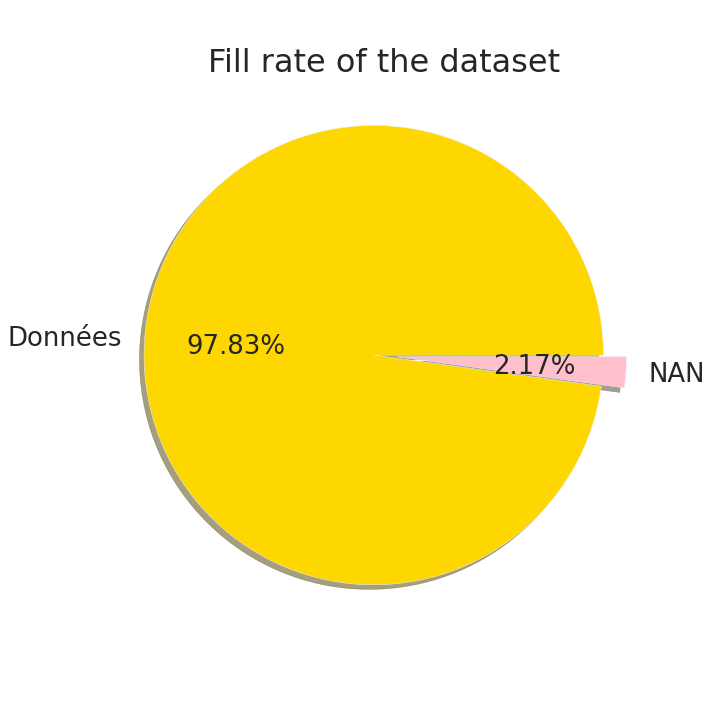

Dataset  Lines  Columns
0    data   1050       15

In [ ]:
resume = []
for name in list_names:
    pos = list_names.index(name)
    dataset = datasets[pos]
    print("General presentation of the dataset {}." .format(name))
    informations(dataset)
    print("Missing Data Rate {}." .format(name))
    pie_NaN(dataset, (10, 10))
    resume.append(
        {
            'Dataset': name,
            'Lines': dataset.shape[0],
            'Columns': dataset.shape[1]
        }
    )

pd.DataFrame(resume)

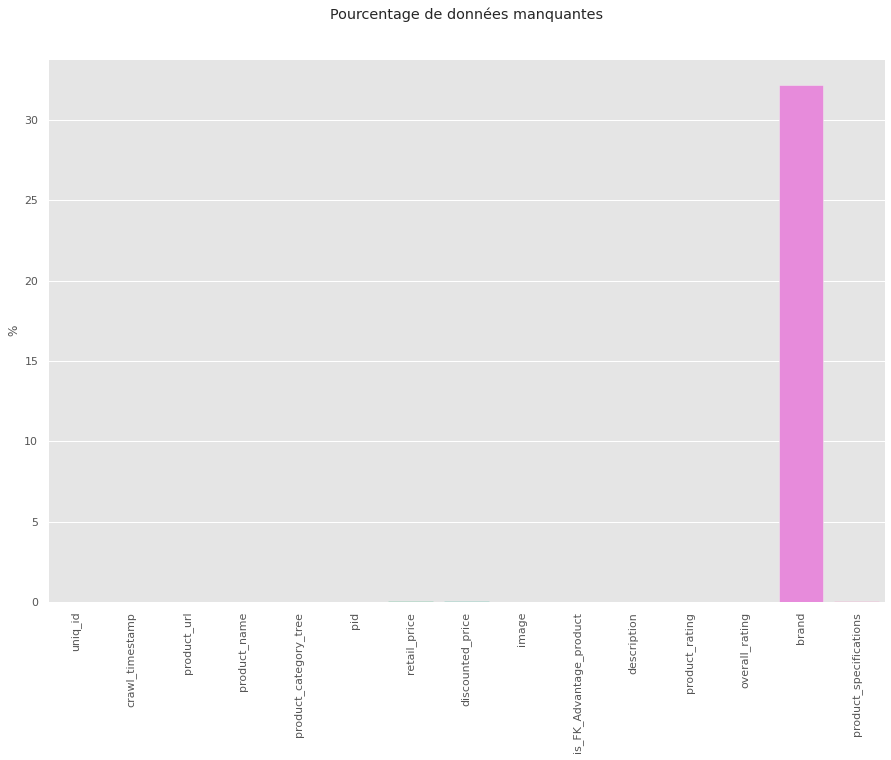

In [ ]:
df_na = data.isna().sum()/len(data)*100

fig = plt.figure(figsize=(15, 10))
sns.barplot(x=df_na.index, y=df_na.values)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("%")
plt.title("Pourcentage de données manquantes")
plt.show()

La feature 'brand' contient plus de 30 % de données manquantes mais il y a aussi des données manquantes pour retail_price, discounted_price, product_specification. 

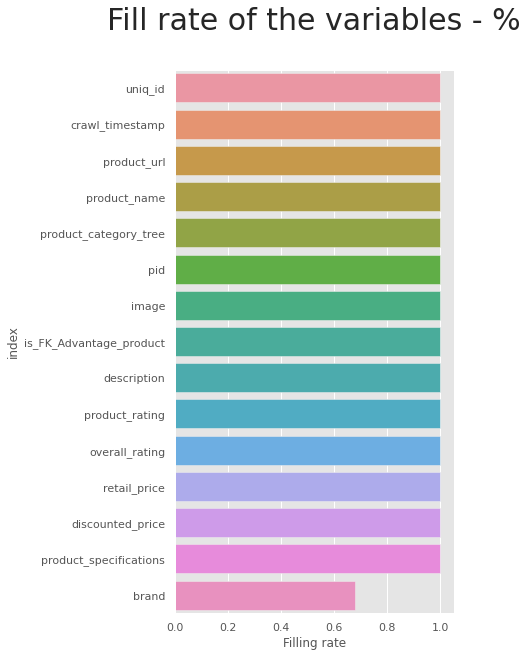

In [ ]:
# # %%flake8
graph_fill_variable(data, (5, 10))

In [ ]:
data.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

uniq_id : id de chaque image

crawl_timestamp : date d'ajout

product_url : url du produit sur le site

product_name : nom du produit

product_category_tree : catégorie donnée sous forme d'arbre (catégorie, sous-catégorie; sous-sous catégorie, ...) = plusieurs profondeurs de catégorisation

pid : identifiant processus

retail_price : prix au détail de l'article

discounted_price : Prix réduit (promotion, rabais, pour l'achat du produit en grande quantité ?)

image : nom de l'image que l'on peut retrouver dans le dossier regroupant les images.

description : description précise du produit

product_rating : note donnée au produit

overall_rating : note globale

brand : marque

product_specifications : Type de produit


In [ ]:
data.describe(include='all')

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     8e961e4fd248c9496ca54808d2d2b25f  2015-12-01 12:40:44 +0000   
freq                                   1                        150   
mean                                 NaN                        NaN   
std                                  NaN                        NaN   
min                                  NaN                        NaN   
25%                                  NaN                        NaN   
50%                                  NaN                        NaN   
75%                                  NaN                        NaN   
max                                  NaN                        NaN   

                                              product_url  \
count                                                1050   
unique                                               1050   
top     http://www.flipkart.com/my-newborn-solid-singl...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                      product_name  \
count                                         1050   
unique                                        1050   
top     Rockmantra Vintage Sea Evening Ceramic Mug   
freq                                             1   
mean                                           NaN   
std                                            NaN   
min                                            NaN   
25%                                            NaN   
50%                                            NaN   
75%                                            NaN   
max                                            NaN   

                                    product_category_tree               pid  \
count                                                1050              1050   
unique                                                642              1050   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...  MUGEACY87HUCUYCD   
freq                                                   56                 1   
mean                                                  NaN               NaN   
std                                                   NaN               NaN   
min                                                   NaN               NaN   
25%                                                   NaN               NaN   
50%                                                   NaN               NaN   
75%                                                   NaN               NaN   
max                                                   NaN               NaN   

         retail_price  discounted_price                                 image  \
count     1049.000000       1049.000000                                  1050   
unique            NaN               NaN                                  1050   
top               NaN               NaN  dd0e3470a7e6ed76fd69c2da27721041.jpg   
freq              NaN               NaN                                     1   
mean      2186.197331       1584.527169                                   NaN   
std       7639.229411       7475.099680                                   NaN   
min         35.000000         35.000000                                   NaN   
25%        555.000000        340.000000                                   NaN   
50%        999.000000        600.000000                                   NaN   
75%       1999.000000       1199.000000

## <font color='blue'>Duplicats de produit</font>

In [ ]:
for name in list_names:
    pos = list_names.index(name)
    dataset = datasets[pos]
    print("Duplicate of the dataset {}." .format(name))
    print(dataset.duplicated('uniq_id').sum())
    print("\n")

Duplicate of the dataset data.
0




Il n'y a pas de produit en doublon dans le jeu de données.

## <font color='blue'>données manquantes</font>

##### <font color='olive'> **Répartition**</font>

In [ ]:
data.isna().sum(axis=0)

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

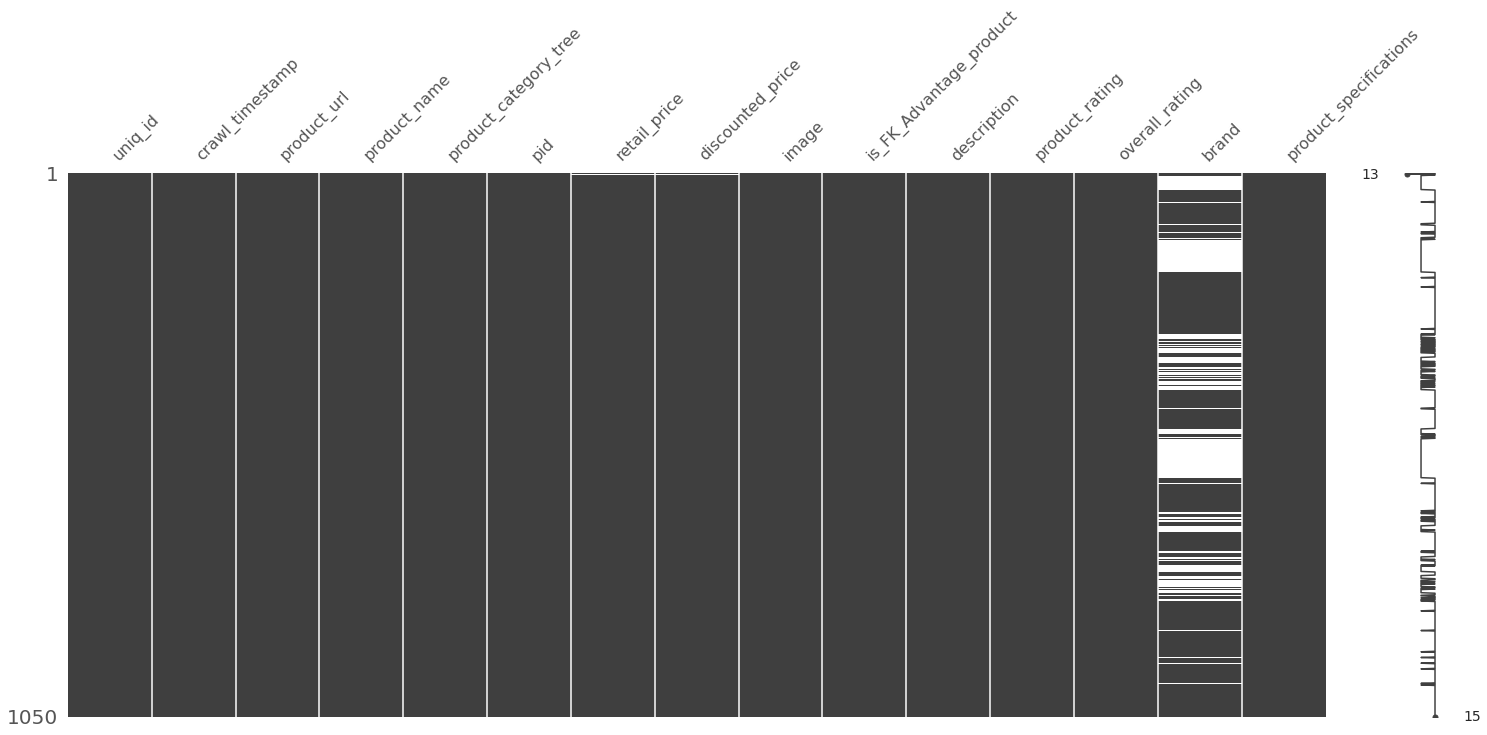

In [ ]:
msno.matrix(data)

Il y a des données manquantes pour le prix du produit, les promotions, les marques et la spécificité du produit.

In [ ]:
for name in list_names:
    pos = list_names.index(name)
    dataset = datasets[pos]
    lines = dataset.shape[0]
    columns = dataset.shape[1]
    nb_data = dataset.count().sum()
    nb_totale = (columns*lines)
    rate_dataOK = (nb_data/nb_totale)
    print("NAN of the dataset {}." .format(name))
    print("There is {:.2%} of missing data".format(1-rate_dataOK))
    print("\n")

NAN of the dataset data.
There is 2.17% of missing data




##### <font color='olive'> **Imputation**</font>

Je décide d'imputer les données manquantes du prix des produits et des promotions par la moyenne de chacune de ces colonnes.

In [ ]:
data['retail_price'].fillna((data['retail_price'].mean()), inplace=True)
data['discounted_price'].fillna(
    (data['discounted_price'].mean()), inplace=True)

Je décide d'imputer les données manquantes de brand et de de product_specifications par "unknow".

In [ ]:
data['brand'].fillna('Unknown', inplace=True)
data['product_specifications'].fillna('Unknown', inplace=True)

In [ ]:
data.isna().sum(axis=0)

uniq_id                    0
crawl_timestamp            0
product_url                0
product_name               0
product_category_tree      0
pid                        0
retail_price               0
discounted_price           0
image                      0
is_FK_Advantage_product    0
description                0
product_rating             0
overall_rating             0
brand                      0
product_specifications     0
dtype: int64

## <font color='blue'>types de données</font>

In [ ]:
data.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [ ]:
data['crawl_timestamp'] = data[
    'crawl_timestamp'].astype('datetime64')

## <font color='blue'>Exploration univariée</font>

### <font color='olive'>variables numériques</font>

In [ ]:
data['product_name'].nunique()

1050

il y a en tout 1050 produits.

In [ ]:
data['retail_price'].nunique()

355

plusieurs produits ont le même prix

In [ ]:
data['discounted_price'].nunique()

425

plusieurs produits ont le même rabais

Analyze of the dataset : data.
Statistical measures for the variable retail_price 

The average of the variable retail_price is : 2186.2
The median of the variable retail_price is : 999.0
Quartile Q1 is : 555.75 
Quartile Q3 is : : 1999.0 
The maximum is : 201000.0 
The minimum is : 35.0 
 

Measures of dispersion for the variable retail_price 

The variance of the variable retail_price is : 58246668.23 
The standard deviation of the variable retail_price is : 7631.95 
The coefficient of variation of the variable retail_price is : 3.49
The interquartile range of the variable retail_price is : 1443.25 
 

Shape measures for the variable retail_price

The empirical skewness for the variable retail_price is 19.7883 
The distribution of the variable retail_price is spreadto the right. 

The empirical Kurtosis for the variable retail_price is 474.1471 
The distribution of the variable retail_price is less flatthan the normal distribution, the observationsare more concentrated.



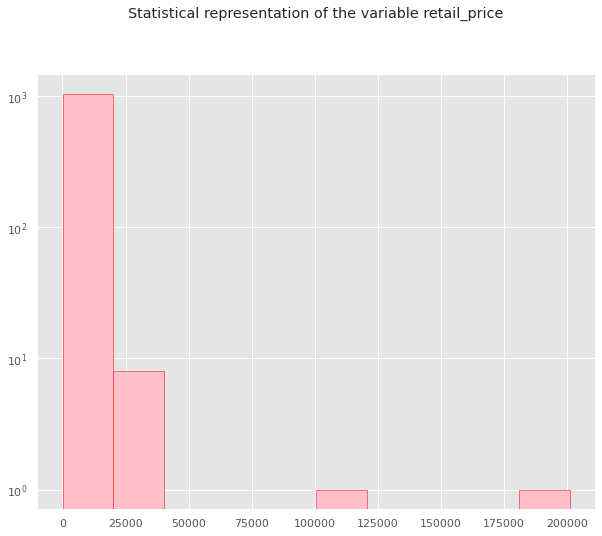

Boxplot of the variable retail_price


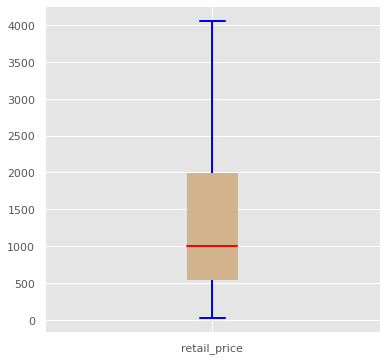


 

Statistical measures for the variable discounted_price 

The average of the variable discounted_price is : 1584.53
The median of the variable discounted_price is : 600.0
Quartile Q1 is : 340.0 
Quartile Q3 is : : 1199.75 
The maximum is : 201000.0 
The minimum is : 35.0 
 

Measures of dispersion for the variable discounted_price 

The variance of the variable discounted_price is : 55770682.63 
The standard deviation of the variable discounted_price is : 7467.98 
The coefficient of variation of the variable discounted_price is : 4.71
The interquartile range of the variable discounted_price is : 859.75 
 

Shape measures for the variable discounted_price

The empirical skewness for the variable discounted_price is 21.2324 
The distribution of the variable discounted_price is spreadto the right. 

The empirical Kurtosis for the variable discounted_price is 523.8899 
The distribution of the variable discounted_price is less flatthan the normal distribution, the observationsare more co

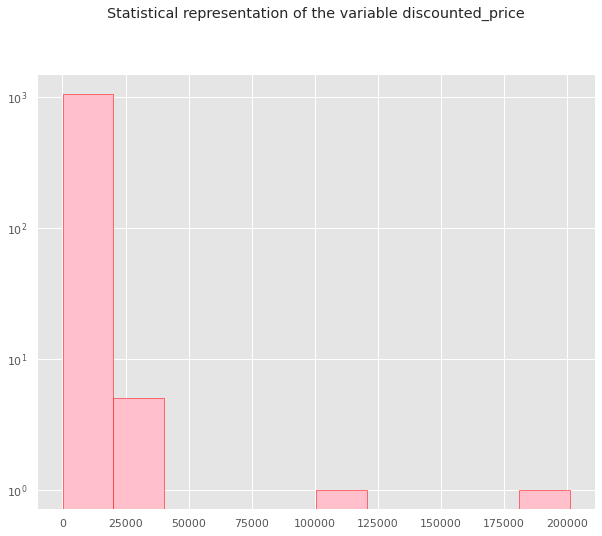

Boxplot of the variable discounted_price


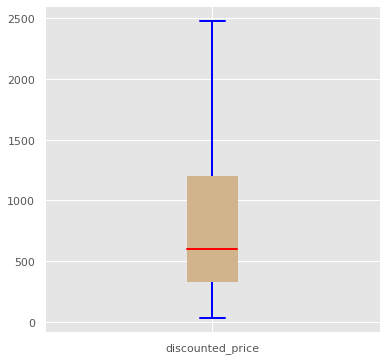


 

None


In [ ]:
print("Analyze of the dataset : {}.".format(get_df_name(data)))
print(description_var(data))

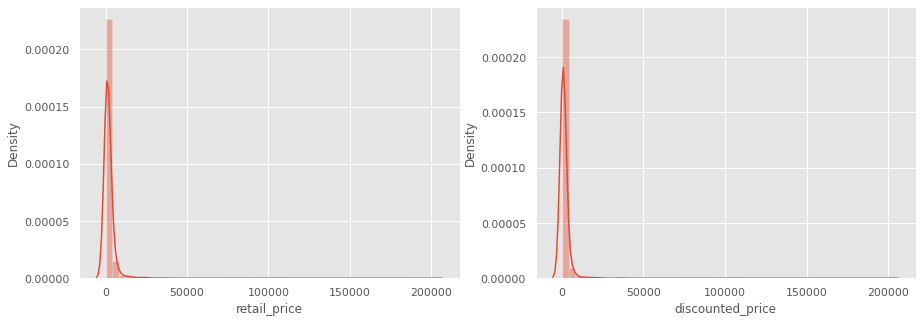

In [ ]:
plot_multiple_histograms(data, (15, 5))

### <font color='olive'>variables nominale</font>

In [ ]:
df_non_numeric = data.select_dtypes(exclude='number')
df_non_numeric.head(5)

uniq_id     crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7 2016-04-30 03:22:56   
1  7b72c92c2f6c40268628ec5f14c6d590 2016-04-30 03:22:56   
2  64d5d4a258243731dc7bbb1eef49ad74 2016-04-30 03:22:56   
3  d4684dcdc759dd9cdf41504698d737d8 2016-06-20 08:49:52   
4  6325b6870c54cd47be6ebfbffa620ec7 2016-06-20 08:49:52   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False   
3  d4684dcdc759dd9cdf41504698d737d8.jpg                    False   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg                    False   

                                         description       product_rating  \
0  Key Features of Elegance Polyester Multicolor ...  No rating available   
1  Specifications of Sathiyas Cotton Bath Towel (...  No rating available   
2  Key Features of Eurospa Cotton Terry Face Towe...  No rating available   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  No rating available   
4  Key Features of Jaipur Print Cotton Floral Kin...  No rating available   

        overall_rating                  brand  \
0  No rating available               Elegance   
1  No rating available               Sathiyas   
2  No rating available                Eurospa   
3  No rating available  SANTOSH ROYAL FASHION   
4  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

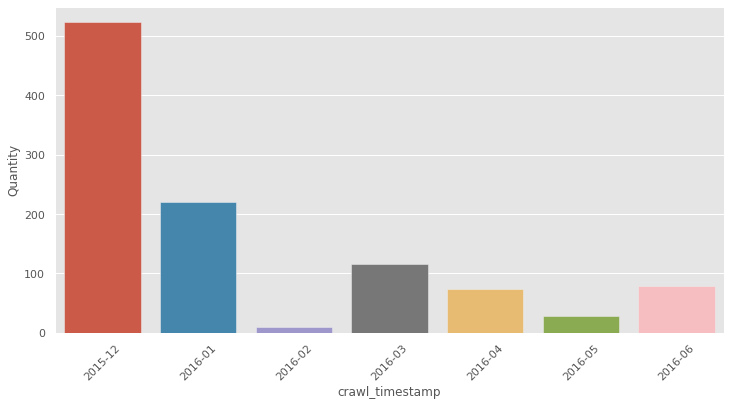

In [ ]:
plot_date_dist(df_non_numeric, 'crawl_timestamp')

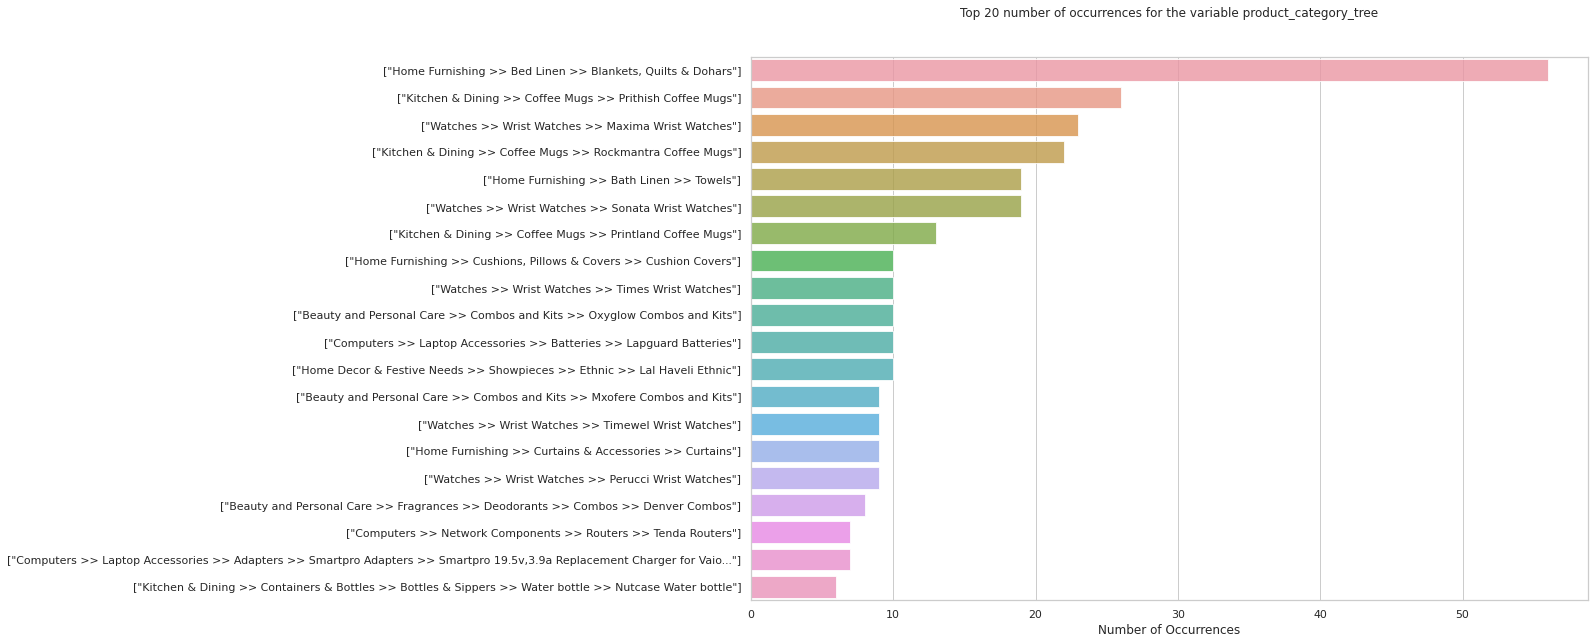

In [ ]:
graphe_objet(df_non_numeric, 'product_category_tree', False, True)

In [ ]:
df_non_numeric['product_category_tree'].nunique()

642

il y a plus de produits que d'arbres de catégories, ce qui veut dire que plusieurs produits ont le même arbre de catégories.

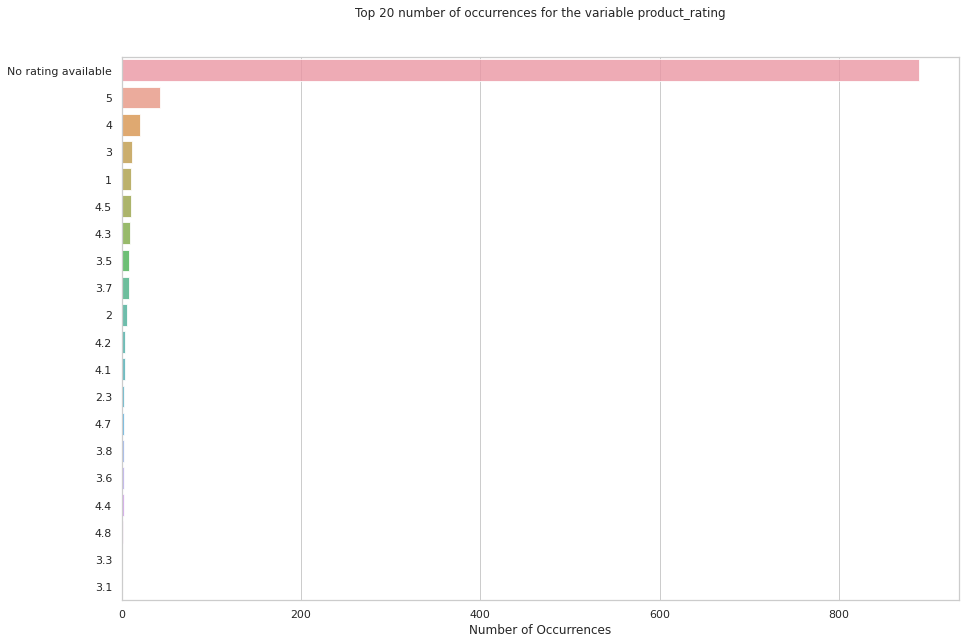

In [ ]:
graphe_objet(df_non_numeric, 'product_rating', False, True)

In [ ]:
df_non_numeric['is_FK_Advantage_product'].unique()

array([False,  True])

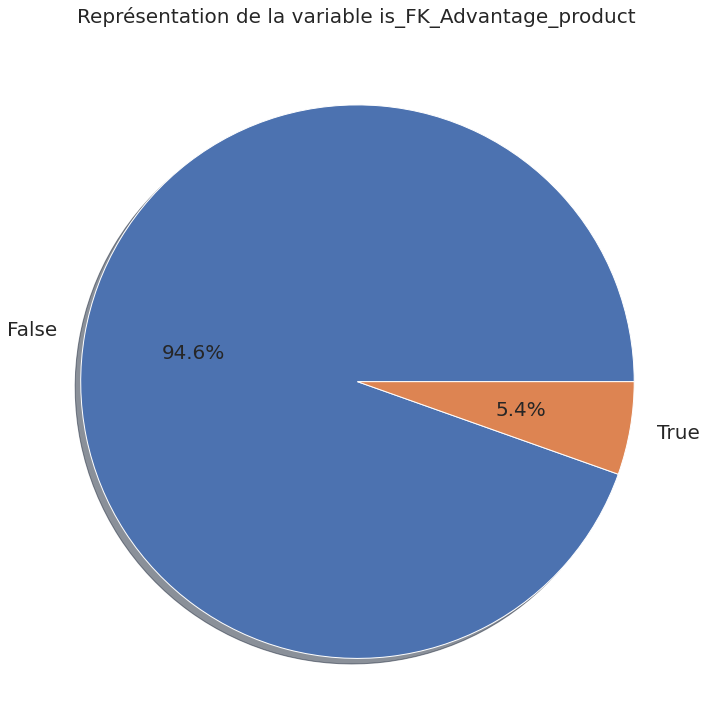

In [ ]:
pie_col_category(df_non_numeric, 'is_FK_Advantage_product', (10, 10))

In [ ]:
df_non_numeric['brand'].nunique()

491

il y a 490 marques représentées dans le jeu de données mais de nombreuses marques sont manquantes et 1 groupe de marques est inconnue.

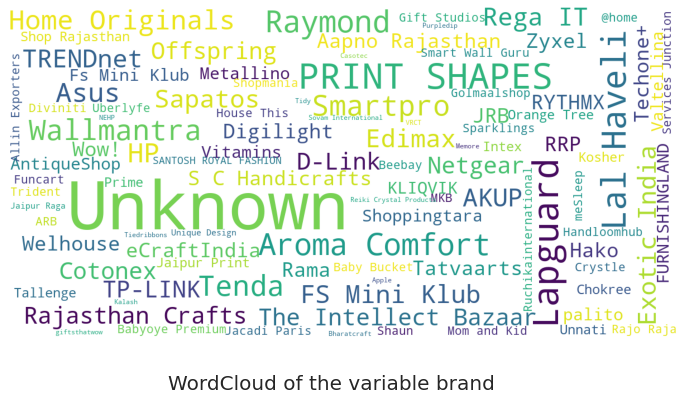

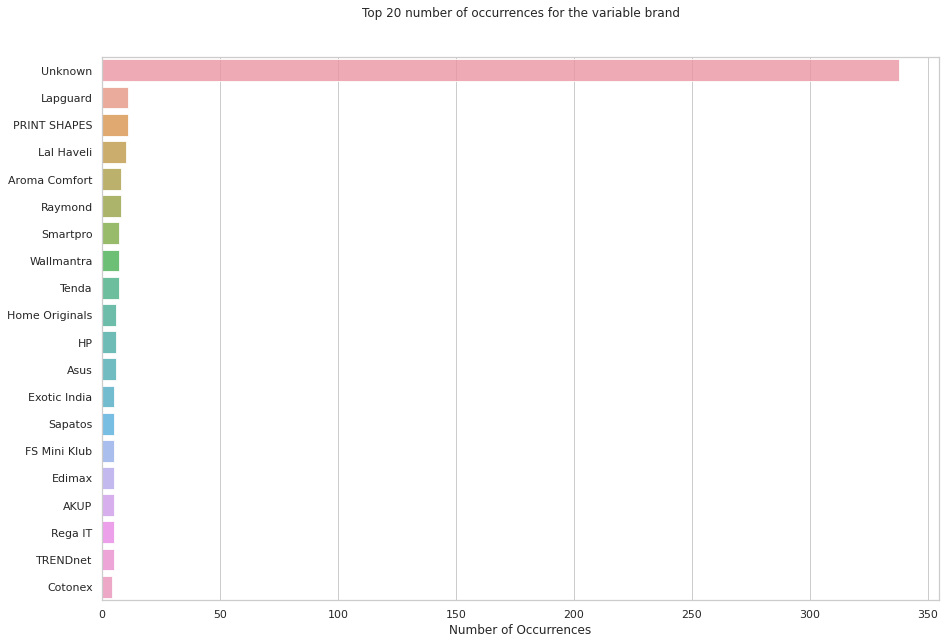

In [ ]:
graphe_objet(df_non_numeric, 'brand', True, True)

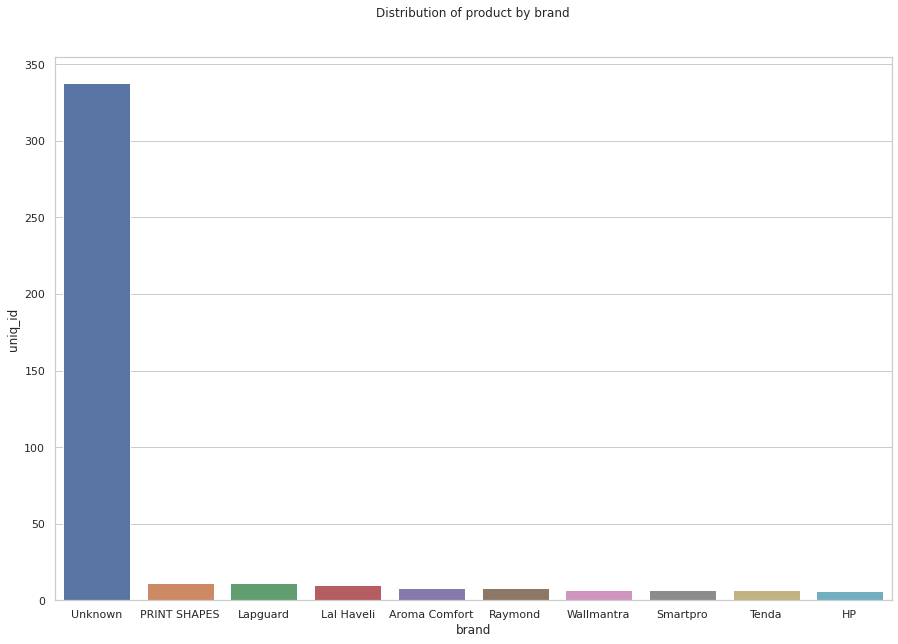

In [ ]:
# %%flake8
product_by_brand = data[['uniq_id', 'brand']]\
    .groupby('brand').count().reset_index()
product_by_brand = product_by_brand.sort_values(by=['uniq_id'],
                                                ascending=False).head(10)
plt.figure(figsize=(15, 10))
sns.barplot(x='brand',
            y='uniq_id',
            data=product_by_brand)
plt.title("Distribution of product by brand")
plt.show()

La très grande majorité des produits n'a pas de marque connue.

In [ ]:
data['product_specifications'].nunique()

985

Exemple pour un produit :

In [ ]:
data.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [ ]:
print("Exemple pour le produit : {} \n".format(data['product_name'].iloc[1]))

print("L'arbre de catégorie du produit est : {} \n".format(
    data['product_category_tree'].iloc[1]))

print("La marque du produit est : {} \n".format(data["brand"].iloc[1]))

print("Le descriptif du produit est : \n {}".format(
    data["product_specifications"].iloc[1]))

Exemple pour le produit : Sathiyas Cotton Bath Towel 

L'arbre de catégorie du produit est : ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."] 

La marque du produit est : Sathiyas 

Le descriptif du produit est : 
 {"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "value"=>"Cotton"}, {"key"=>"Design", "value"=>"Self Design"}, {"key"=>"Brand", "value"=>"Sathiyas"}, {"key"=>"Type", "value"=>"Bath Towel"}, {"key"=>"GSM", "value"=>"500"}, {"key"=>"Model Name", "value"=>"Sathiyas cotton bath towel"}, {"key"=>"Ideal For", "value"=>"Men, Women, Boys, Girls"}, {"key"=>"Model ID", "value"=>"asvtwl322"}, {"key"=>"Color", "value"=>"Red, Yellow, Blue"}, {"key"=>"Size", "value"=>"Mediam"}, {"key"=>"Length", "value"=>"30 inch"}, {"key"=>"Width", "value"=>"60 inch"}, {"key"=>"Number of Contents in Sales Package", "value"=>"3"}, {"key"=>"Sales Package", "value"=>"3 Bath To

# <font color='green'>Nettoyage du dataset et visualisation</font>

In [ ]:
data = data.copy()

In [ ]:
def remove_columns(dataframe):
    new = pd.DataFrame()
    columns_to_keep = [
        'image', 'product_name', 'product_category_tree', 'description']

    for column in columns_to_keep:
        try:
            new[column] = dataframe[column]
        except:
            print('...colonne non présente : ', column)
            print('\n')
    print("All selected columns have been kept from the dataset")
    return new

In [ ]:
text_data = remove_columns(data)

All selected columns have been kept from the dataset


In [ ]:
text_data.head()

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >>...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...   

                                         description  
0  Key Features of Elegance Polyester Multicolor ...  
1  Specifications of Sathiyas Cotton Bath Towel (...  
2  Key Features of Eurospa Cotton Terry Face Towe...  
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  
4  Key Features of Jaipur Print Cotton Floral Kin...

La "racine" de chaque arbre de catégorisation sera prise comme base pour vérifier la bonne prédiction des catégories futures.

In [ ]:
text_data["product_category_tree"][0]

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [ ]:
def recover_root_cat(column):
    categorie = column.split('["')[1].split('"]')[0]
    cat = categorie.split(' >> ')[0]
    return cat

In [ ]:
def recover_cat1(column):
    categorie = column.split('["')[1].split('"]')[0]
    cat = categorie.split(' >> ')[1]
    return cat

In [ ]:
text_data['category'] = text_data['product_category_tree'].apply(
    recover_root_cat)
text_data['manual_cat1'] = text_data['product_category_tree'].apply(
    recover_cat1)

del text_data['product_category_tree']

In [ ]:
text_data

image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                            description         category  \
0     Key Features of Elegance Polyester Multicolor ...  Home Furnishing   
1     Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2     Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing   
4     Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing   
...                                                 ...              ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...        Baby Care   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...        Baby Care   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...        Baby Care   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...        Baby Care   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...        Baby Care   

                 manual_cat1  
0     Curtains & Accessories  
1           Baby Bath & Skin  
2           Baby Bath & Skin  
3                  Bed Linen  
4                  Bed Linen  
...                      ...  
1045       Baby & Kids Gifts  
1046       Baby & Kids Gifts  
1047       Baby & Kids Gifts  
1048       Baby & Kids Gifts  
1049       Baby & Kids Gifts  

[1050 rows x 5 columns]

In [ ]:
text_data['category'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [ ]:
#text_data['category'] = text_data['category'].replace({'a':'b', 'c':'d'})
#text_data['category'] = text_data['category'].apply(lambda x: x.replace('&', 'and'))

text_data['category'] = text_data['category'].str.replace(
    '&', 'and')
text_data['category'] = text_data['category'].str.replace(
    ' ', '_')
text_data['category'] = text_data['category'].str.lower()
text_data['category'].unique()

array(['home_furnishing', 'baby_care', 'watches',
       'home_decor_and_festive_needs', 'kitchen_and_dining',
       'beauty_and_personal_care', 'computers'], dtype=object)

In [ ]:
text_data['manual_cat1'] = text_data['manual_cat1'].str.replace(' ', '_')
text_data['manual_cat1'] = text_data['manual_cat1'].str.lower()
text_data['manual_cat1'].unique()

array(['curtains_&_accessories', 'baby_bath_&_skin', 'bed_linen',
       'wrist_watches', 'living_room_furnishing', 'bath_linen',
       'candles_&_fragrances', 'tableware_&_cutlery', 'lighting',
       'jmd_home_furnishing', 'infant_wear', "kripa's_home_furnishing",
       'hair_care', 'coffee_mugs', 'network_components',
       'tablet_accessories', 'cookware', 'laptop_accessories', 'makeup',
       'combos_and_kits', 'feeding_&_nursing', 'baby_bedding',
       'kitchen_&_dining_linen', 'containers_&_bottles',
       'consumables_&_disposables', 'wall_decor_&_clocks',
       'table_decor_&_handicrafts', 'flowers,_plants_&_vases', 'software',
       'showpieces', 'furniture_&_furnishings',
       'decorative_lighting_&_lamps', 'baby_grooming',
       'computer_peripherals', 'cushions,_pillows_&_covers', 'storage',
       'health_care', 'body_and_skin_care', 'kitchen_tools',
       'true_home_decor_&_festive_needs', 'living', 'showpiece',
       'bar_&_glassware', 'fragrances', "women'

In [ ]:
text_data['category'].nunique()

7

In [ ]:
text_data['manual_cat1'].nunique()

62

In [ ]:
text_data['category'].value_counts()

home_decor_and_festive_needs    150
watches                         150
kitchen_and_dining              150
baby_care                       150
home_furnishing                 150
computers                       150
beauty_and_personal_care        150
Name: category, dtype: int64

In [ ]:
text_data['manual_cat1'].value_counts()

wrist_watches              149
laptop_accessories          87
infant_wear                 84
coffee_mugs                 74
showpieces                  71
                          ... 
women's_hygiene              1
kripa's_home_furnishing      1
housekeeping_&_laundry       1
beauty_accessories           1
garden_&_leisure             1
Name: manual_cat1, Length: 62, dtype: int64

In [ ]:
text_data

image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                           product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                            description         category  \
0     Key Features of Elegance Polyester Multicolor ...  home_furnishing   
1     Specifications of Sathiyas Cotton Bath Towel (...        baby_care   
2     Key Features of Eurospa Cotton Terry Face Towe...        baby_care   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...  home_furnishing   
4     Key Features of Jaipur Print Cotton Floral Kin...  home_furnishing   
...                                                 ...              ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...        baby_care   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...        baby_care   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...        baby_care   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...        baby_care   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...        baby_care   

                 manual_cat1  
0     curtains_&_accessories  
1           baby_bath_&_skin  
2           baby_bath_&_skin  
3                  bed_linen  
4                  bed_linen  
...                      ...  
1045       baby_&_kids_gifts  
1046       baby_&_kids_gifts  
1047       baby_&_kids_gifts  
1048       baby_&_kids_gifts  
1049       baby_&_kids_gifts  

[1050 rows x 5 columns]

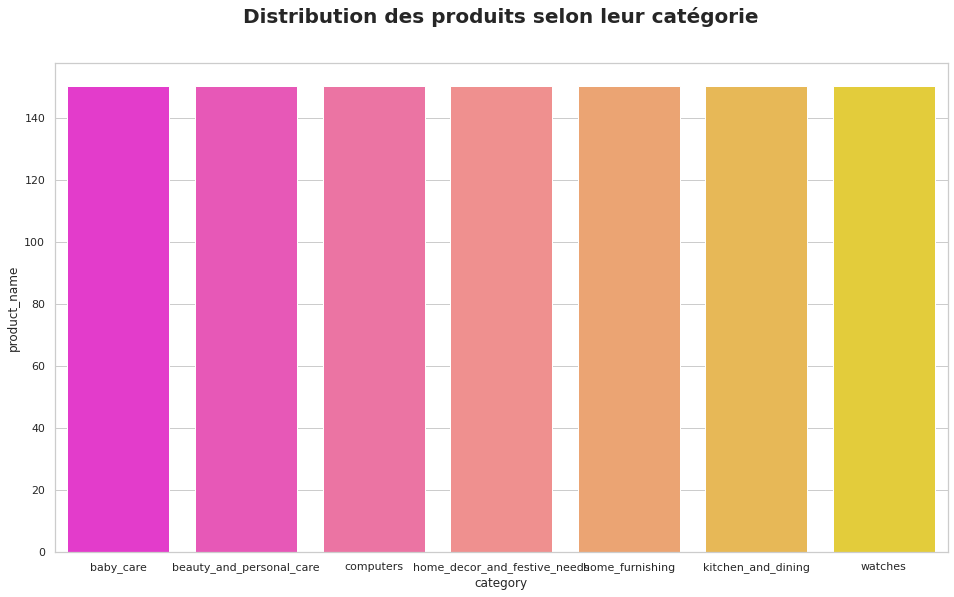

In [ ]:
producy_by_root = text_data[['product_name', 'category']]\
    .groupby('category').count().reset_index()
producy_by_root = producy_by_root.sort_values(by=['product_name'],
                                                ascending=False)
sns.barplot(x='category',
            y='product_name',
            data=producy_by_root,
            palette='spring')
plt.title("Distribution des produits selon leur catégorie",
          weight='bold', size=20)
plt.show()

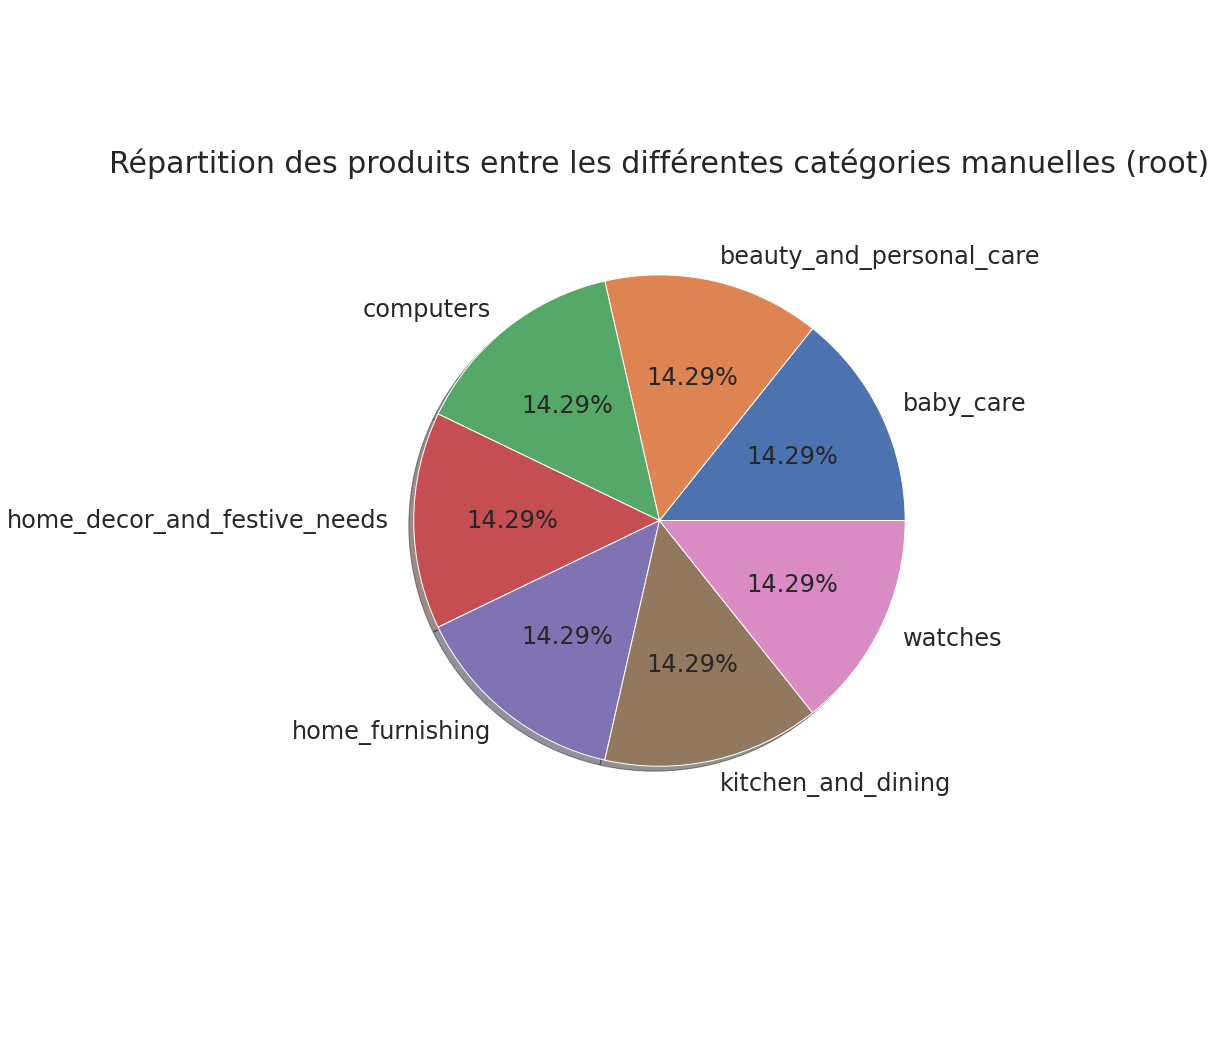

In [ ]:
values = text_data[['product_name', 'category']]\
    .groupby('category').count()
labels = text_data[['product_name', 'category']]\
    .groupby('category').count().index

# Plot
plt.figure(figsize=(15, 15))
plt.pie(values, labels=labels,
        autopct='%.2f%%', shadow=True, textprops={'fontsize': 24})

ttl = plt.title(
    "Répartition des produits entre les différentes catégories manuelles (root)", fontsize=30)
ttl.set_position([0.5, 0.8])

plt.axis('equal')
plt.tight_layout()

plt.show()

Il y a le même nombre de produit par catégorie racine (150).

Text(0, 0.5, 'Nbr de produits')

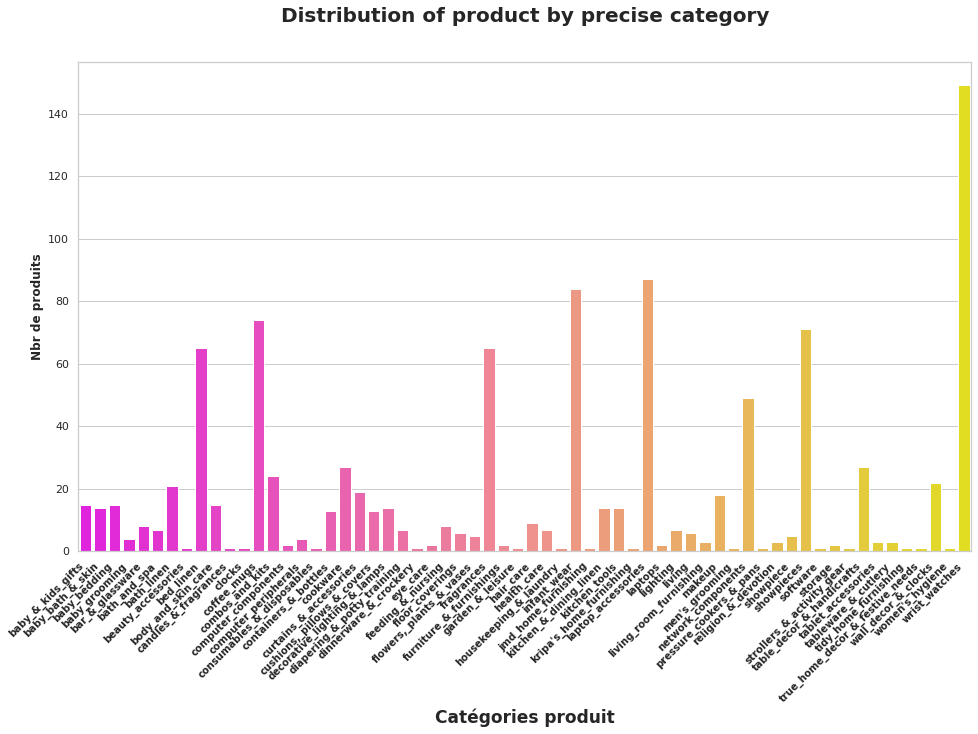

In [ ]:
plt.title('Distribution of product by precise category',
          weight='bold', size=20)
plt.xticks(rotation=45, ha='right', size=10, weight='bold')
sns.barplot(x=text_data.groupby('manual_cat1').size().index,
            y=text_data.groupby('manual_cat1').size(),
            palette='spring')
plt.xlabel('Catégories produit', weight='bold', size=17)
plt.ylabel('Nbr de produits', weight='bold', size=12)

Il y a en tout 62 catégories précises. Quelques catégories se détachent des autres par un nombre de produits importants entre autre 1 catégorie qui à elle seule regroupe 150 poduits. 

In [ ]:
del text_data['manual_cat1']

In [ ]:
#text_data.set_index('product_name', inplace=True)

# <font color='green'>Prétraitement des données textuelles</font>

étapes à faire : 
- mettre tous les mots en minuscule
- ne garder que les caractères alphabétiques
- supprimer les stopwords et les lettres isolées
- lemmatisation
- ne garder que les formes canoniques des mots

## <font color='blue'>Mise en place de la liste de caractères à supprimer (stopwords, ponctuation, lettres isolées )</font>

In [ ]:
# on récupère les stopword de WordCloud
#from wordcloud import WordCloud, STOPWORDS
stopwords = list(set(STOPWORDS))
stopwords = [l.lower() for l in list(stopwords)]

In [ ]:
# on récupère les lettres isolées
#import string
alphabet_string = list(string.ascii_lowercase)

In [ ]:
# on récupère les stopword de nltk
import nltk
nltk.download('stopwords')
english_stop = nltk.corpus.stopwords.words('english')
english_stop = [l.lower() for l in list(english_stop)]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# si choix de RegexpTokenizer, utilisation inutile car non sélectionner à cet étape
# si utilisation de word_tokenize : éléments nécessaire et à ajouter à all_stopword
# on récupère les signes de ponctuation
#import string
ponctuation_string = list(string.punctuation)

In [ ]:
# suppression des doublons
all_stopwords = set(stopwords + alphabet_string + english_stop)
# équivaut à
# all_stopwords = list(stopwords + alphabet_string + english_stop)
# suppression des doublons stopwords
#stopwords = []
# for i in all_stopwords:
#    if i not in stopwords: stopwords.append(i)
# nb doublon : len(all_stopwords)-len(stopwords)

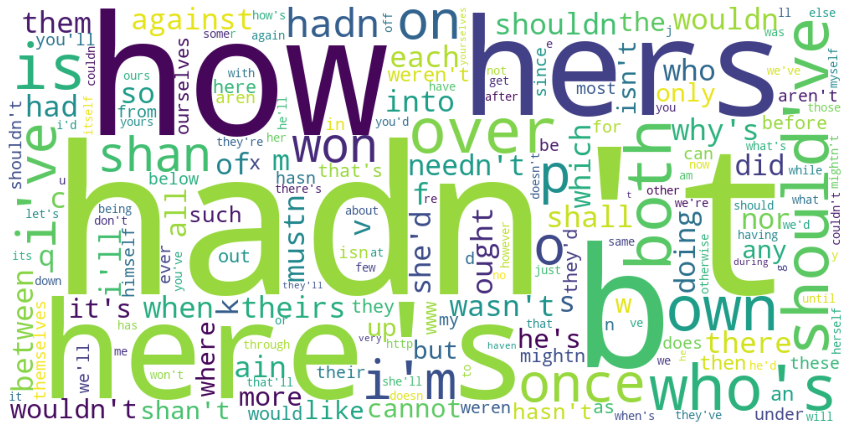

In [ ]:
# WordCLoud d'une partie des Stopwords
from collections import Counter
word_could_dict = Counter(all_stopwords)
wordcloud = WordCloud(background_color='white', width=1000,
                      height=500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## <font color='blue'>Normalisation : tokenization, lemmatization or stemming, stopword</font>

lemmatization : conservation du sens des mots utilisés par la transformation du mot par sa forme canonique. Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier. On garde donc la richesse du vocabulaire. Fonctionne pour le français et l'anglais.

stemming : conservation de la racine des mots étudiés. L'idée étant de supprimer les suffixes, préfixes des mots afin de ne conserver que leur origine : plus rapide, plus simple mais ne marche que pour l'anglais.

N_grams : pend une suite de mots pour saisir le contexte minimal d'une phrase.

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')


def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]


def stemmer_text(text):
    stemmer = SnowballStemmer("english")
    return [stemmer.stem(w) for w in text]


def normalization_df_text(df, column, lemmatizer=False, stemming=False, stopword=None):
    # 1: replace description with the lower case version
    df[column] = df[column].str.lower()

    '''utilisation possible de 
    text_data['description_tokenize'] = text_data['description'].apply(word_tokenize)
    tokenisation simple de chaque ligne du dataframe mais code supplémentaire pour majuscule, ponctuation'''

    # 2: sépare chaque string en liste de mots, supprimer caractère numérique, supprimer ponctuation
    # on ne garde que les mots avec des uniquement des lettre alphabétique d'une taille strictement supérieure à 4
    # supprimer taille 1 ou 2 mais garder mot 3
    tokenizer = nltk.RegexpTokenizer(r'[a-z]{4,}')

    df['description_tokenize_clean'] = df[column].map(
        tokenizer.tokenize)
    # 3: lemmatization or stemming
    # lemmatization : on garde la forme canonique des mots
    if lemmatizer is not False:
        df['description_tokenize_clean'] = df['description_tokenize_clean'].apply(
            lemmatize_text)

    # stemmer = racine du mot
    if stemming is not False:
        df['description_tokenize_clean'] = df['description_tokenize_clean'].apply(
            stemmer_text)

    # 4: Suppression StopWord
    df['description_tokenize_clean'] = df['description_tokenize_clean'].apply(
        lambda x: [item for item in x if item not in stopword])

    return df['description_tokenize_clean']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
normalization_df_text(text_data, 'description',
                      True, False, all_stopwords)
del text_data['description']

In [ ]:
text_data

image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                           product_name         category  \
0     Elegance Polyester Multicolor Abstract Eyelet ...  home_furnishing   
1                            Sathiyas Cotton Bath Towel        baby_care   
2                   Eurospa Cotton Terry Face Towel Set        baby_care   
3     SANTOSH ROYAL FASHION Cotton Printed King size...  home_furnishing   
4     Jaipur Print Cotton Floral King sized Double B...  home_furnishing   
...                                                 ...              ...   
1045     Oren Empower Extra Large Self Adhesive Sticker        baby_care   
1046             Wallmantra Large Vinyl Sticker Sticker        baby_care   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...        baby_care   
1048            Wallmantra Medium Vinyl Sticker Sticker        baby_care   
1049                       Uberlyfe Large Vinyl Sticker        baby_care   

                             description_tokenize_clean  
0     [feature, elegance, polyester, multicolor, abs...  
1     [specification, sathiyas, cotton, bath, towel,...  
2     [feature, eurospa, cotton, terry, face, towel,...  
3     [feature, santosh, royal, fashion, cotton, pri...  
4     [feature, jaipur, print, cotton, floral, king,...  
...                                                 ...  
1045  [oren, empower, extra, large, self, adhesive, ...  
1046  [wallmantra, large, vinyl, sticker, sticker, p...  
1047  [uberlyfe, extra, large, pigmented, polyvinyl,...  
1048  [wallmantra, medium, vinyl, sticker, sticker, ...  
1049  [uberlyfe, large, vinyl, sticker, online, uber...  

[1050 rows x 4 columns]

## <font color='blue'>Liste des mots avec le plus d'occurence : non utilisé par la suite</font>

In [ ]:
text_data

image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                           product_name         category  \
0     Elegance Polyester Multicolor Abstract Eyelet ...  home_furnishing   
1                            Sathiyas Cotton Bath Towel        baby_care   
2                   Eurospa Cotton Terry Face Towel Set        baby_care   
3     SANTOSH ROYAL FASHION Cotton Printed King size...  home_furnishing   
4     Jaipur Print Cotton Floral King sized Double B...  home_furnishing   
...                                                 ...              ...   
1045     Oren Empower Extra Large Self Adhesive Sticker        baby_care   
1046             Wallmantra Large Vinyl Sticker Sticker        baby_care   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...        baby_care   
1048            Wallmantra Medium Vinyl Sticker Sticker        baby_care   
1049                       Uberlyfe Large Vinyl Sticker        baby_care   

                             description_tokenize_clean  
0     [feature, elegance, polyester, multicolor, abs...  
1     [specification, sathiyas, cotton, bath, towel,...  
2     [feature, eurospa, cotton, terry, face, towel,...  
3     [feature, santosh, royal, fashion, cotton, pri...  
4     [feature, jaipur, print, cotton, floral, king,...  
...                                                 ...  
1045  [oren, empower, extra, large, self, adhesive, ...  
1046  [wallmantra, large, vinyl, sticker, sticker, p...  
1047  [uberlyfe, extra, large, pigmented, polyvinyl,...  
1048  [wallmantra, medium, vinyl, sticker, sticker, ...  
1049  [uberlyfe, large, vinyl, sticker, online, uber...  

[1050 rows x 4 columns]

In [ ]:
# trouver les 100 mots que l'on retrouve le plus dans toutes les descriptions
#from nltk import FreqDist
#from nltk.tokenize import word_tokenize

lists = text_data['description_tokenize_clean']
words = []
for wordList in lists:
    words += wordList

fdist = FreqDist(words)
mostcommon = fdist.most_common(100)
mclist = []
for i in range(len(mostcommon)):
    mclist.append(mostcommon[i][0])
words = [w for w in words if w not in mclist]

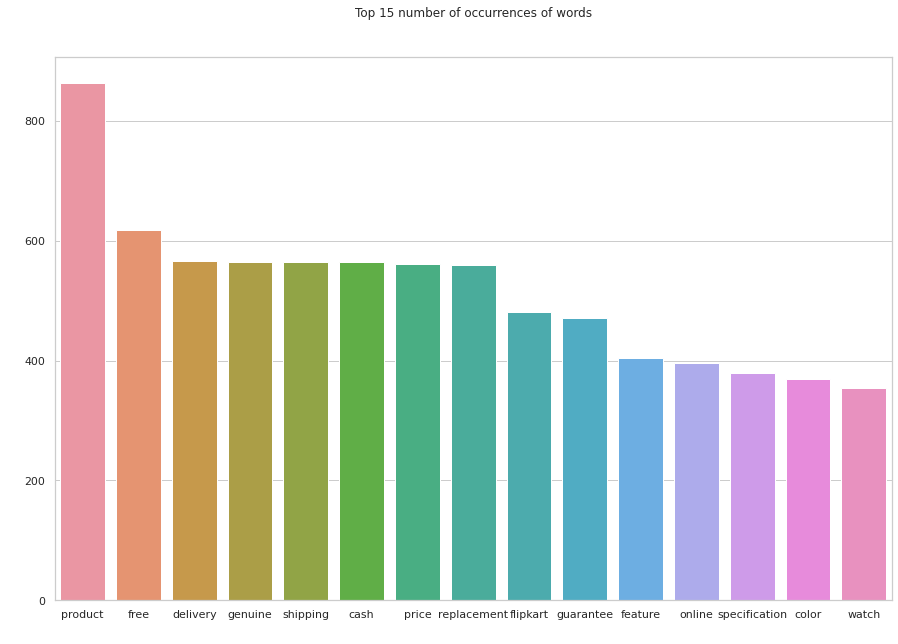

In [ ]:
df = pd.DataFrame(mostcommon)
plt.figure(figsize=(15, 10))
sns.barplot(x=df[0].head(15),
            y=df[1].head(15))
plt.title("Distribution of customers by state")
plt.title("Top 15 number of occurrences of words")
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

## <font color='blue'> non utilisé : Suppression des mots que l'on retrouve le plus</font>

In [ ]:
"""remove_mostcommon = list(df[0])"""

'remove_mostcommon = list(df[0])'

In [ ]:
"""text_data"""

'text_data'

In [ ]:
"""text_data['description_untokenize_clean'] = text_data['description_tokenize_clean'].apply(untokenize)"""

"text_data['description_untokenize_clean'] = text_data['description_tokenize_clean'].apply(untokenize)"

In [ ]:
"""del text_data['description_tokenize_clean']"""

"del text_data['description_tokenize_clean']"

In [ ]:
"""remove_mostcommon[:10]"""

'remove_mostcommon[:10]'

In [ ]:
"""normalization_df_text(text_data, 'description_untokenize_clean',
                      False, False, remove_mostcommon)"""

"normalization_df_text(text_data, 'description_untokenize_clean',\n                      False, False, remove_mostcommon)"

In [ ]:
"""del text_data['description_untokenize_clean']
text_data"""

"del text_data['description_untokenize_clean']\ntext_data"

## <font color='blue'>Dataset final</font>

Encodage des catégories en classes numériques. Il y a 7 classes root différentes car 7 catégories racine.

In [ ]:
# Encodage des catégories trouvées manuellement
le = preprocessing.LabelEncoder()
text_data['label_category'] = le.fit_transform(
    np.array(text_data['category']))

In [ ]:
label = ['0', '1', '2', '3', '4', '5', '6']
for i in range(len(label)):
    df = text_data.loc[text_data['label_category'] == i]
    cat = df['category'].iloc[0]
    print('Le label {} correspond à la catégorie {}' .format(i, cat))

Le label 0 correspond à la catégorie baby_care
Le label 1 correspond à la catégorie beauty_and_personal_care
Le label 2 correspond à la catégorie computers
Le label 3 correspond à la catégorie home_decor_and_festive_needs
Le label 4 correspond à la catégorie home_furnishing
Le label 5 correspond à la catégorie kitchen_and_dining
Le label 6 correspond à la catégorie watches


In [ ]:
text_data['category'].value_counts()

home_decor_and_festive_needs    150
watches                         150
kitchen_and_dining              150
baby_care                       150
home_furnishing                 150
computers                       150
beauty_and_personal_care        150
Name: category, dtype: int64

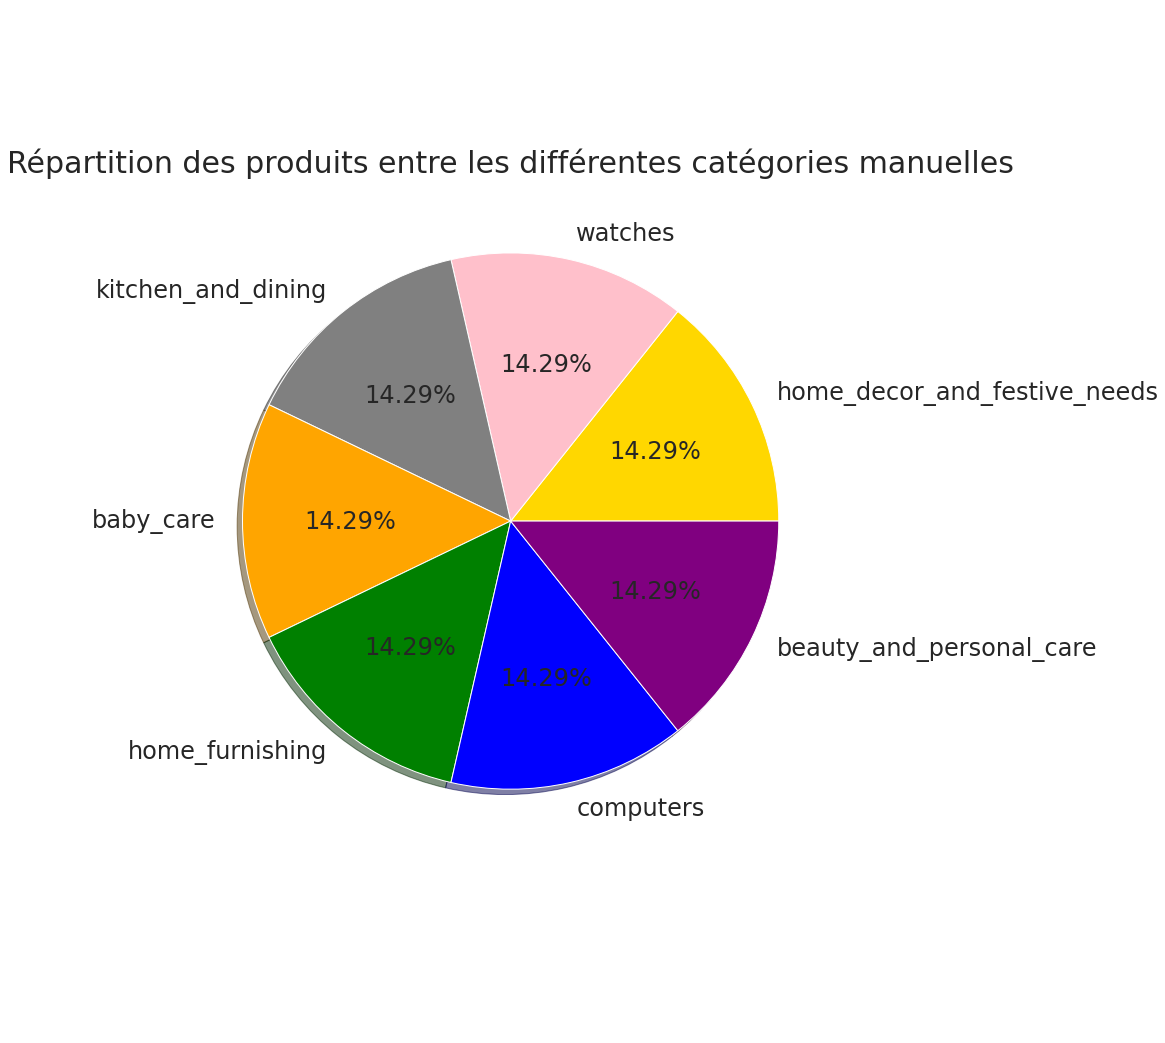

In [ ]:
values = text_data['category'].value_counts()
labels = text_data['category'].value_counts().index
colors = ['gold', 'pink', 'grey', 'orange', 'green', 'blue', 'purple']
explode = (0, 0, 0, 0, 0, 0, 0)

# Plot
plt.figure(figsize=(15, 15))
plt.pie(values, explode=explode, labels=labels, colors=colors,
        autopct='%.2f%%', shadow=True, textprops={'fontsize': 24})

ttl = plt.title(
    "Répartition des produits entre les différentes catégories manuelles", fontsize=30)
ttl.set_position([0.5, 0.8])

plt.axis('equal')
plt.tight_layout()

plt.show()

In [ ]:
text_data['description_untokenize_clean'] = text_data['description_tokenize_clean'].apply(
    untokenize)

In [ ]:
del text_data['description_tokenize_clean']
del text_data['product_name']

In [ ]:
text_data

image         category  label_category  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg  home_furnishing               4   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg        baby_care               0   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg        baby_care               0   
3     d4684dcdc759dd9cdf41504698d737d8.jpg  home_furnishing               4   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg  home_furnishing               4   
...                                    ...              ...             ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg        baby_care               0   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg        baby_care               0   
1047  5912e037d12774bb73a2048f35a00009.jpg        baby_care               0   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg        baby_care               0   
1049  f2f027ad6a6df617c9f125173da71e44.jpg        baby_care               0   

                           description_untokenize_clean  
0     feature elegance polyester multicolor abstract...  
1     specification sathiyas cotton bath towel bath ...  
2     feature eurospa cotton terry face towel size s...  
3     feature santosh royal fashion cotton printed k...  
4     feature jaipur print cotton floral king sized ...  
...                                                 ...  
1045  oren empower extra large self adhesive sticker...  
1046  wallmantra large vinyl sticker sticker pack pr...  
1047  uberlyfe extra large pigmented polyvinyl film ...  
1048  wallmantra medium vinyl sticker sticker online...  
1049  uberlyfe large vinyl sticker online uberlyfe l...  

[1050 rows x 4 columns]

In [ ]:
#y_train.to_csv('y_train.csv', index=False)

# sur google colab
from google.colab import drive
drive.mount('/content/drive')
text_data.to_csv('df_untokenize_description.csv', index=False)
!cp df_untokenize_description.csv /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <font color='green'>Extraction features </font>

## <font color='blue'>Bag Of Word</font>

Donne le nombre d'occurences d'une liste de mots : à chaque fois que l'on croise ce mot, on le met dans le sac correspondant et on fait la somme du nombre de mots. la représentation est un vecteur de fréquence d'apparition des différents mots utilisés.

https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

max_df : fréquence maximale que doit avoir un mot, sinon si sa fréquence est supérieure, le mot n'est pas pris en compte.

min_df : fréquence minimale que doit avoir un mot, sinon si sa fréquence est inférieure, le mot n'est pas pris en compte.

max_features : nombre max de mots par sac de mots

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
countvectorizer = CountVectorizer(encoding='utf-8',
                                  strip_accents=None,
                                  lowercase=None,
                                  preprocessor=None,
                                  tokenizer=None,
                                  stop_words=all_stopwords,
                                  analyzer='word',
                                  max_df=0.95,
                                  min_df=0.01)

Les paramètres principaux à spécifier sont max_df et min_df qui correspondent respectivement à la fréquence maximale et minimale d'apparition du feature dans la totalité du texte. La fréquence maximale d'apparition est de 95% et la fréquence minimale d'apparition d'un mot dans le texte est de 1%.
Max_features qui correspond au nombre de mots par sac n'est pas nécessaire ici car le nombre de données étant grand, il n'y a pas de contraintes physiques.

In [ ]:
# convert the dataframe's column into a matrix
count_wm = countvectorizer.fit_transform(
    text_data['description_untokenize_clean'])

In [ ]:
# retrieve the terms found in the corpora
count_tokens = countvectorizer.get_feature_names()
len(count_tokens)

445

Avec cette méthode, 445 tokenizes ont été trouvés.

In [ ]:
df_countvect = pd.DataFrame(data=count_wm.toarray(),
                            index=text_data.index,
                            columns=count_tokens)

In [ ]:
print("Count Vectorizer\n")
df_countvect

Count Vectorizer



abstract  accessory  actual  adapter  additional  adorable  affordable  \
0            4          0       0        0           0         0           0   
1            0          0       0        0           0         0           0   
2            0          0       0        0           0         0           0   
3            0          0       0        0           0         0           0   
4            0          0       0        0           0         0           0   
...        ...        ...     ...      ...         ...       ...         ...   
1045         0          0       0        0           0         0           0   
1046         0          0       0        0           0         0           0   
1047         0          0       0        0           0         0           0   
1048         0          0       0        0           0         0           0   
1049         0          0       0        0           0         0           0   

      aluminium  analog  antique  apple  apply  area  aroma  around  assured  \
0             0       0        0      0      0     0      0       0        0   
1             0       0        0      0      0     0      0       0        0   
2             0       0        0      0      0     0      0       0        0   
3             0       0        0      0      0     0      0       0        0   
4             0       0        0      0      0     0      0       0        0   
...         ...     ...      ...    ...    ...   ...    ...     ...      ...   
1045          0       0        0      0      6     2      0       0        0   
1046          0       0        0      0      8     0      0       0        0   
1047          0       0        0      0      0     0      0       0        0   
1048          0       0        0      0      0     0      0       0        0   
1049          0       0        0      0      0     0      0       0        0   

      attractive  audio  authentication  available  baby  back  base  bath  \
0              0      0               0          0     0     0     0     0   
1              0      0               0          0     0     0     0     6   
2              0      0               0          0     0     0     0     2   
3              0      0               0          0     0     0     0     0   
4              0      0               0          0     0     0     0     0   
...          ...    ...             ...        ...   ...   ...   ...   ...   
1045           0      0               0          0     0     0     0     0   
1046           0      0               0          0     0     0     0     0   
1047           0      0               0          0     0     0     0     0   
1048           0      0               0          0     0     0     0     0   
1049           0      0               0          0     0     0     0     0   

      battery  ...  wall  wardrobe  warm  warranty  wash  washable  watch  \
0           0  ...     0         0     0         0     0         0      0   
1           0  ...     0         0     0         0     0         1      0   
2           0  ...     0         0     0         0     3         0      0   
3           0  ...     0         0     0         0     1         1      0   
4           0  ...     0         0     0         1     0         1      0   
...       ...  ...   ...       ...   ...       ...   ...       ...    ...   
1045        0  ...    16         0     0         0     0         0      0   
1046        0  ...     6         0     0         0     0         0      0   
1047        0  ...     0         0     0         0     0         0      0   
1048        0  ...     0         0     0         0     0         0      0   
1049        0  ...     0         0     0         0     0         0      0   

      water  waterproof  wear  wedding  weight  well  white  wide  width  \
0         0           0     0        0       0     0      0     0      0   
1         0           0     0        0       0     0      0     0     

## <font color='blue'>Tf idf</font>

Le calcul tf-idf (term frequency–inverse document frequency) permet de calculer un score de proximité entre un terme de recherche et un document.

La partie tf calcule une fonction croissante de la fréquence du terme de recherche dans le document étudié, la partie idf calcule une fonction inversement proportionnelle à la fréquence du terme dans l’ensemble des documents (ou corpus).

Le score total, obtenu en multipliant les deux composantes, permet ainsi de donner un score d’autant plus élevé que le terme est surréprésenté.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

Nettoyage déjà fait donc la plupart des paramètres sont None.

max_df : fréquence maximale que doit avoir un mot, sinon si sa fréquence est supérieure, le mot n'est pas pris en compte.

min_df : fréquence minimale que doit avoir un mot, sinon si sa fréquence est inférieure, le mot n'est pas pris en compte.

In [ ]:
# instantiate the vectorizer object
tfidfvectorizer = TfidfVectorizer(encoding='utf-8',
                                  strip_accents=None,
                                  lowercase=True,
                                  preprocessor=None,
                                  tokenizer=None,
                                  analyzer='word',
                                  stop_words=all_stopwords,
                                  max_df=0.95,
                                  min_df=0.01)

Les paramètres principaux à spécifier sont max_df et min_df qui correspondent respectivement à la fréquence maximale et minimale d'apparition du feature dans la totalité du texte. La fréquence maximale d'apparition est de 95% et la fréquence minimale d'apparition d'un mot dans le texte est de 1%.

In Scikit-Learn, the resulting TF-IDF vectors are then normalized by the Euclidean norm.

In [ ]:
# convert the dataframe's column into a matrix
tfidf_wm = tfidfvectorizer.fit_transform(
    text_data['description_untokenize_clean'])

In [ ]:
# retrieve the terms found in the corpora
# if we take same parameters on both Classes(CountVectorizer and TfidfVectorizer),
# it will give same output of get_feature_names() methods)
tfidf_tokens = tfidfvectorizer.get_feature_names()
len(tfidf_tokens)

445

Avec cette méthode, 445 tokenizes ont été trouvés.

In [ ]:
df_tfidfvect = pd.DataFrame(data=tfidf_wm.toarray(),
                            index=text_data.index,
                            columns=tfidf_tokens)

In [ ]:
print("\nTD-IDF Vectorizer\n")
df_tfidfvect_total = pd.concat([text_data['image'], text_data['category'], df_tfidfvect], axis=1)
df_tfidfvect_total


TD-IDF Vectorizer



image         category  abstract  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg  home_furnishing  0.202646   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg        baby_care  0.000000   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg        baby_care  0.000000   
3     d4684dcdc759dd9cdf41504698d737d8.jpg  home_furnishing  0.000000   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg  home_furnishing  0.000000   
...                                    ...              ...       ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg        baby_care  0.000000   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg        baby_care  0.000000   
1047  5912e037d12774bb73a2048f35a00009.jpg        baby_care  0.000000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg        baby_care  0.000000   
1049  f2f027ad6a6df617c9f125173da71e44.jpg        baby_care  0.000000   

      accessory  actual  adapter  additional  adorable  affordable  aluminium  \
0           0.0     0.0      0.0         0.0       0.0         0.0        0.0   
1           0.0     0.0      0.0         0.0       0.0         0.0        0.0   
2           0.0     0.0      0.0         0.0       0.0         0.0        0.0   
3           0.0     0.0      0.0         0.0       0.0         0.0        0.0   
4           0.0     0.0      0.0         0.0       0.0         0.0        0.0   
...         ...     ...      ...         ...       ...         ...        ...   
1045        0.0     0.0      0.0         0.0       0.0         0.0        0.0   
1046        0.0     0.0      0.0         0.0       0.0         0.0        0.0   
1047        0.0     0.0      0.0         0.0       0.0         0.0        0.0   
1048        0.0     0.0      0.0         0.0       0.0         0.0        0.0   
1049        0.0     0.0      0.0         0.0       0.0         0.0        0.0   

      analog  antique  apple     apply      area  aroma  around  assured  \
0        0.0      0.0    0.0  0.000000  0.000000    0.0     0.0      0.0   
1        0.0      0.0    0.0  0.000000  0.000000    0.0     0.0      0.0   
2        0.0      0.0    0.0  0.000000  0.000000    0.0     0.0      0.0   
3        0.0      0.0    0.0  0.000000  0.000000    0.0     0.0      0.0   
4        0.0      0.0    0.0  0.000000  0.000000    0.0     0.0      0.0   
...      ...      ...    ...       ...       ...    ...     ...      ...   
1045     0.0      0.0    0.0  0.289998  0.096666    0.0     0.0      0.0   
1046     0.0      0.0    0.0  0.519530  0.000000    0.0     0.0      0.0   
1047     0.0      0.0    0.0  0.000000  0.000000    0.0     0.0      0.0   
1048     0.0      0.0    0.0  0.000000  0.000000    0.0     0.0      0.0   
1049     0.0      0.0    0.0  0.000000  0.000000    0.0     0.0      0.0   

      attractive  audio  authentication  available  baby  back  base  ...  \
0            0.0    0.0             0.0        0.0   0.0   0.0   0.0  ...   
1            0.0    0.0             0.0        0.0   0.0   0.0   0.0  ...   
2            0.0    0.0             0.0        0.0   0.0   0.0   0.0  ...   
3            0.0    0.0             0.0        0.0   0.0   0.0   0.0  ...   
4            0.0    0.0             0.0        0.0   0.0   0.0   0.0  ...   
...          ...    ...             ...        ...   ...   ...   ...  ...   
1045         0.0    0.0             0.0        0.0   0.0   0.0   0.0  ...   
1046         0.0    0.0             0.0        0.0   0.0   0.0   0.0  ...   
1047         0.0    0.0             0.0        0.0   0.0   0.0   0.0  ...   
1048         0.0    0.0             0.0        0.0   0.0   0.0   0.0  ...   
1049         0.0    0.0             0.0        0.0   0.0   0.0   0.0  ...   

          wall  wardrobe  warm  warranty      wash  washable  watch     water  \
0     0.000000       0.0   0.0    0.0000  0.000000  0.000000    0.0  0.000000   
1     0.000000       0.0   0.0    0.0000  0.000000  0.099876    0.0  0.000000   
2     0.000000       0.0   0.0    0.0000  0.136487  0.000000    0.0  0.042381   
3     0.000000       0.0 

Pour la suite des analyses, je décide de me baser sur la méthode tf-idf qui est la plus utilisée.

In [ ]:
# sur google colab
from google.colab import drive
drive.mount('/content/drive')
df_tfidfvect_total.to_csv('df_tfidfvect_total.csv', index=False)
!cp df_tfidfvect_total.csv /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# sur google colab
from google.colab import drive
drive.mount('/content/drive')
df_tfidfvect.to_csv('df_tfidfvect.csv', index=False)
!cp df_tfidfvect.csv /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""df_tfidfvect.to_csv('df_tfidfvect.csv', index=False)"""

"df_tfidfvect.to_csv('df_tfidfvect.csv', index=False)"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

df_tfidfvect = pd.read_csv('/content/drive/MyDrive/'
                           'df_tfidfvect.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
"""df_visual_word = pd.read_csv(
    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC"
    "/WORK-projet6/df_tfidfvect.csv")"""

'df_visual_word = pd.read_csv(\n    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC"\n    "/WORK-projet6/df_tfidfvect.csv")'

# <font color='green'>Clustering</font>

On réalise dans cette partie un clusterig via 3 algorithmes:

- Kmeans
- Clustering hiérarchique
- DBSCAN

Nous allons comparer les clusters obtenus et surtout le clustering sur sa qualité (coefficent de silhouette), mais aussi comparer les clusters obtenus par rapport aux classes réelles des objets grâce à l'indice de Rand ajusté (ARI). On produira des visualisations dans les plans factoriels et via T-SNE.

## <font color='blue'>Reduction de dimension</font>

### <font color='olive'>ACP</font>

* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (95%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [ ]:
df_tfidfvect.shape

(1050, 445)

In [ ]:
pca = PCA(n_components=df_tfidfvect.shape[1], random_state=40)
df = pca.fit_transform(df_tfidfvect)

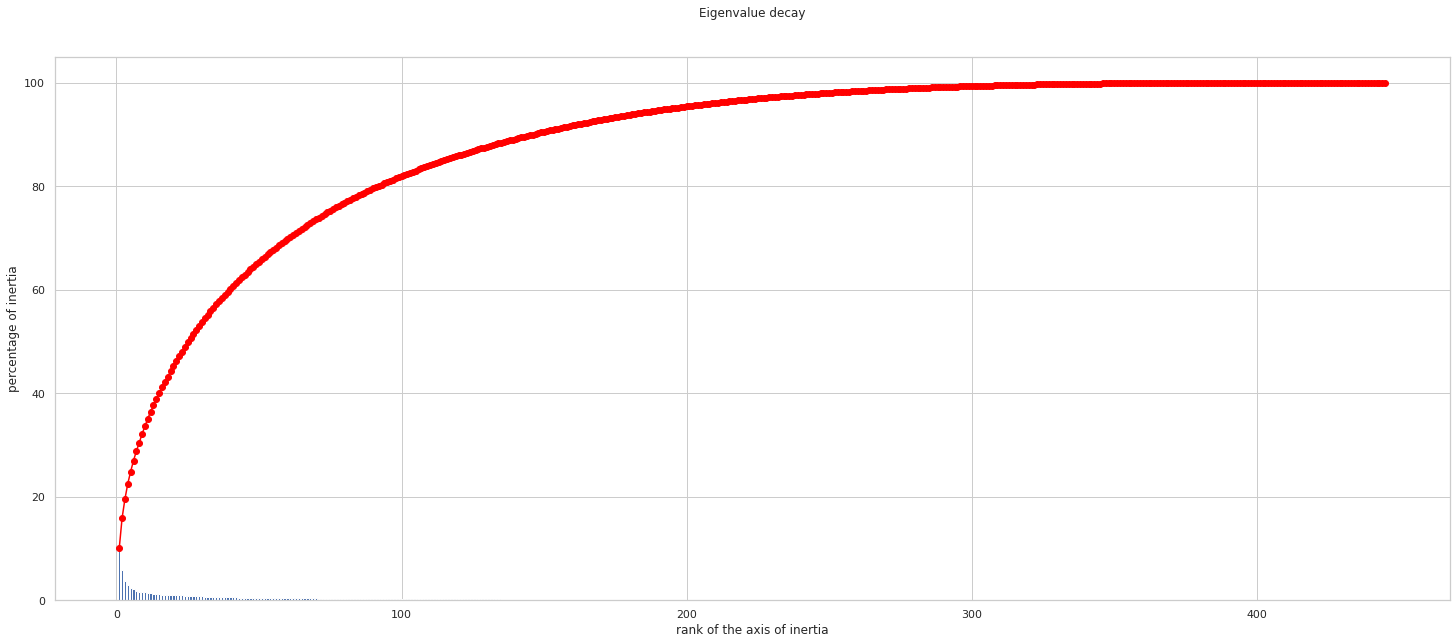

In [ ]:
plt.figure(figsize=(25, 10))
display_scree_plot(pca)

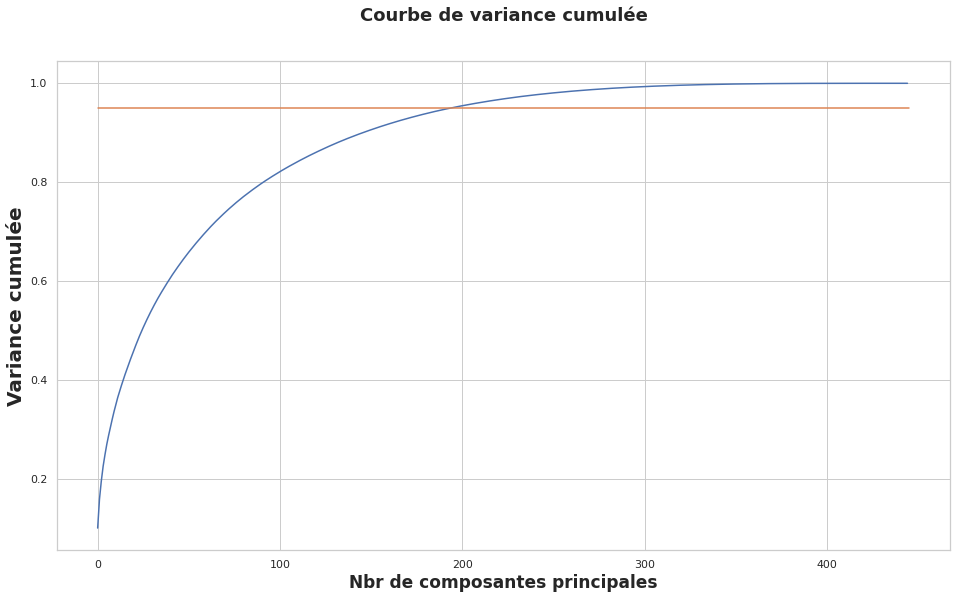

In [ ]:
plt.figure(figsize=(16, 9))
plt.ylabel("Variance cumulée", weight='bold', size=20)
plt.xlabel('Nbr de composantes principales', weight='bold', size=17)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Courbe de variance cumulée', size=18, weight='bold')
plt.plot([0, df_tfidfvect.shape[1]], [0.95, 0.95])

In [ ]:
c = 0
for i in pca.explained_variance_ratio_.cumsum():
    c += 1
    if(i > 0.95):
        print(
            'Il faut {} composantes pour expliquer 95% de la variance du dataset'.format(c))
        break

Il faut 195 composantes pour expliquer 95% de la variance du dataset


In [ ]:
composantes = pca.components_
nbre_composantes = pca.n_components
nbre_composantes

445

In [ ]:
a_show = pca.transform(df_tfidfvect)[:, 0]  # Component 1

b_show = pca.transform(df_tfidfvect)[:, 1]  # Component 2

X_pca = pca.transform(df_tfidfvect)[:, :c]

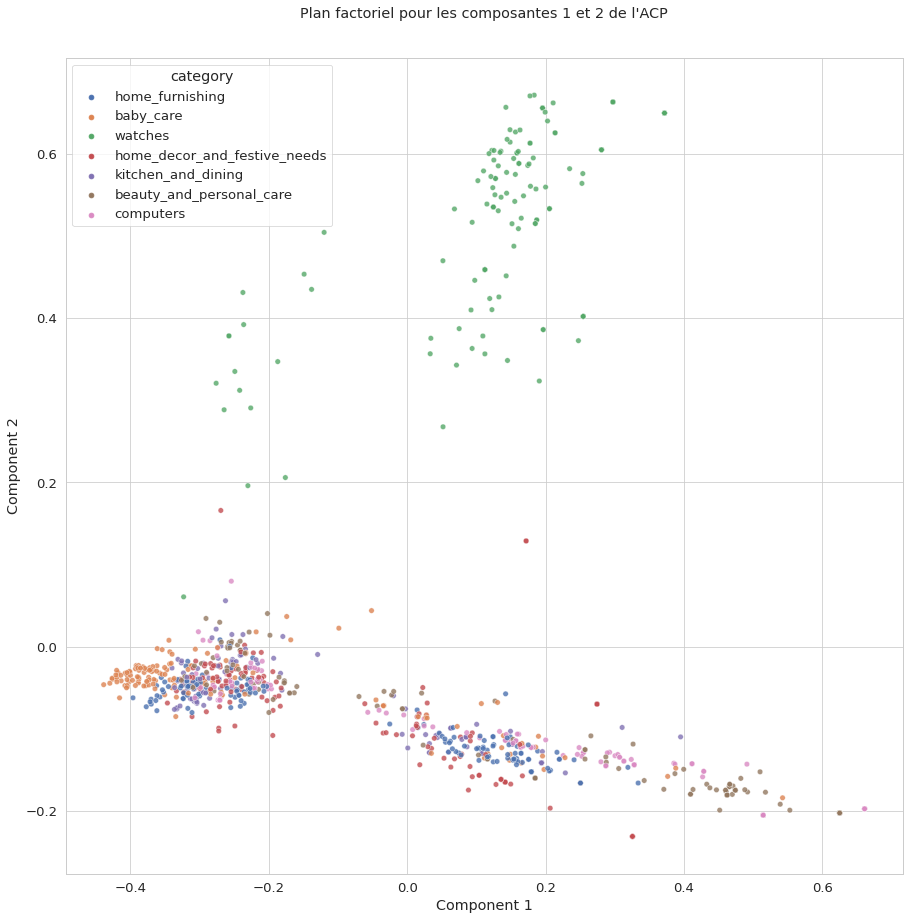

In [ ]:
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(15, 15))
chaine = "Plan factoriel pour les composantes 1 et 2 de l'ACP"
plt.title(chaine)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
ax = plt.gca()

sns.scatterplot(
    x=a_show,
    y=b_show,
    hue=text_data['category'],
    alpha=0.8,
    s=30
)
sns.set_context("paper", font_scale=1)

### <font color='olive'>T-SNE</font>

In [ ]:
tsne = TSNE(n_components=2, init="pca")
X_tsne = tsne.fit_transform(X_pca)

In [ ]:
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = text_data["category"]
print(df_tsne.shape)

(1050, 3)


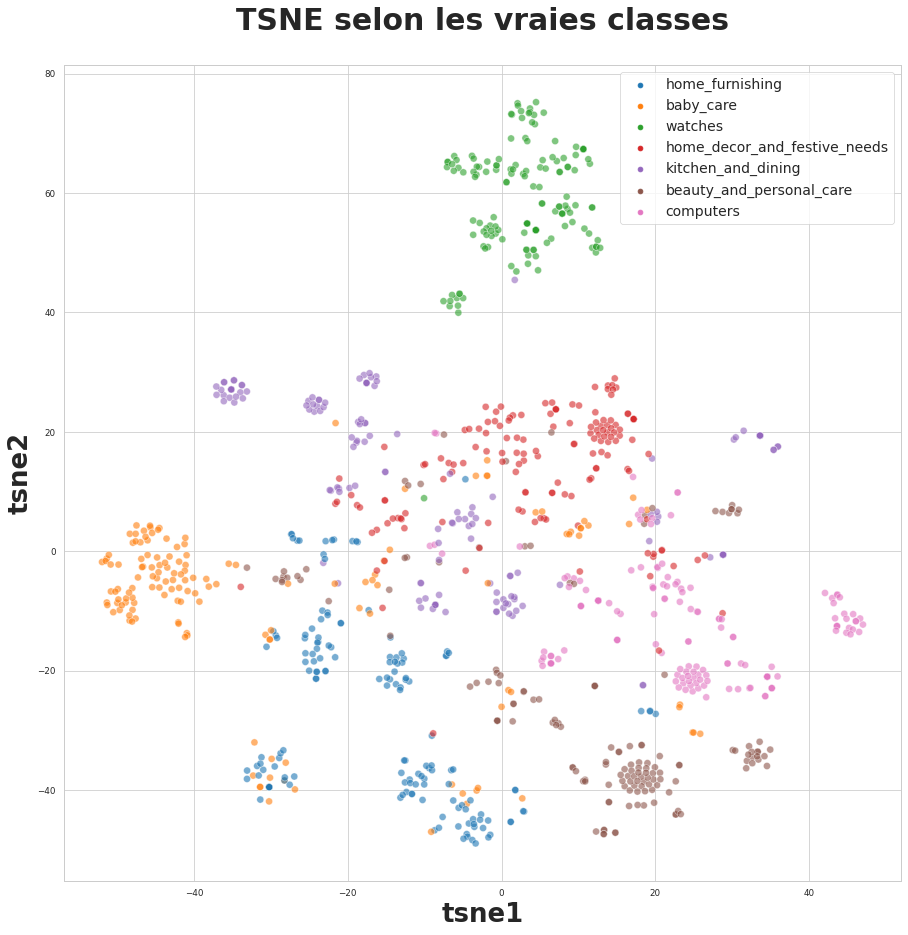

In [ ]:
plt.figure(figsize=(15,15))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

## <font color='blue'>K-means</font>

### <font color='olive'>Exécution</font>

In [ ]:
km = KMeans(n_clusters=7,
            random_state=10,
            init='k-means++')
model = km.fit(X_pca)

# save the model to disk
filename = 'clustering_model_kmeans_description.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
label = km.fit_predict(X_pca)

In [ ]:
model.labels_.shape

(1050,)

Les 1050 produits ont bien eu une catégorie (cluster) attribuée par la méthode k-means.

In [ ]:
mylist = model.labels_
mylist = list(set(mylist))
mylist

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
labels_kmeans = pd.DataFrame(model.labels_, columns=['k_means_cluster'])

In [ ]:
labels_kmeans.head()

k_means_cluster
0                2
1                2
2                2
3                2
4                2

In [ ]:
labels_kmeans["k_means_cluster"].unique()

array([2, 1, 5, 3, 6, 4, 0], dtype=int32)

### <font color='olive'>Qualité du Clustering </font>

In [ ]:
# mean Silhouette Coefficient of all samples
silhouette_kmeans = silhouette_score(X=X_pca, labels=model.labels_)
print('Le coefficient de silhouette moyen est de {} pour la méthode K-means'.format(silhouette_kmeans))

Le coefficient de silhouette moyen est de 0.12218278782058338 pour la méthode K-means


La valeur de la silhouette mesure la similitude d'un objet avec son propre cluster (cohésion) par rapport à d'autres clusters (séparation). La valeur de la silhouette est comprise entre [1, -1], où une valeur élevée indique que l'objet est bien adapté à son propre cluster et mal adapté aux clusters voisins.

Ici le coefficient de silhouette est positif mais assez proche de 0, ce qui permet de dire que les points sont globalement bien répartis entre les clusters et que les clusters sont proches les uns des autres (valeur proche de 0).

Création d'un nouveau dataframe composé du dataframe avec toutes les données associées à leurs clusters déterminés par Kmeans.

In [ ]:
tot_data_label = pd.concat(
    [text_data['category'], text_data['label_category'], labels_kmeans], axis=1)
tot_data_label

category  label_category  k_means_cluster
0     home_furnishing               4                2
1           baby_care               0                2
2           baby_care               0                2
3     home_furnishing               4                2
4     home_furnishing               4                2
...               ...             ...              ...
1045        baby_care               0                2
1046        baby_care               0                2
1047        baby_care               0                4
1048        baby_care               0                4
1049        baby_care               0                4

[1050 rows x 3 columns]

In [ ]:
# Indice de Rand ajusté.
ARI_kmeans = adjusted_rand_score(
    tot_data_label['label_category'], tot_data_label['k_means_cluster'])
print('Le score ARI est de {} pour la méthode K-means'.format(ARI_kmeans))

Le score ARI est de 0.25678254847850673 pour la méthode K-means


L'indice de Rand est la proportion de paires de points   (x1,x2) qui sont groupées de la même façon dans les deux partitions. Cet index ajusté est proche de 0 pour un clustering aléatoire et égal à 1 uniquement quand le clustering correspond exactement à la partition initiale.

Donc, plus ce score est grand, plus la prédiction corrrespondra à la répartition des catégories déterminées manuellement.

Ici, cet indice est de 0.25, ce qui veut dire que le clustering a été réalisé un peu aléatoirement.

### <font color='olive'>Visualisations</font>

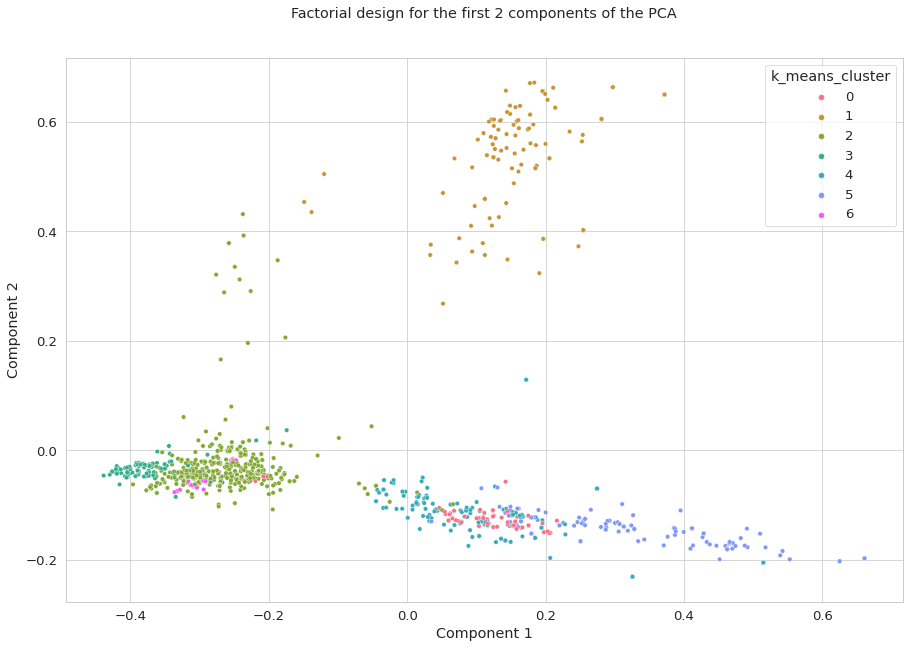

In [ ]:
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(15, 10))
chaine = "Factorial design for the first 2 components of the PCA"
plt.title(chaine)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
ax = plt.gca()

sns.scatterplot(x=a_show,
                y=b_show,
                hue=tot_data_label["k_means_cluster"],
                alpha=1, s=20, legend='full',
                palette=sns.color_palette("husl", 7))

sns.set_context("paper", font_scale=1)

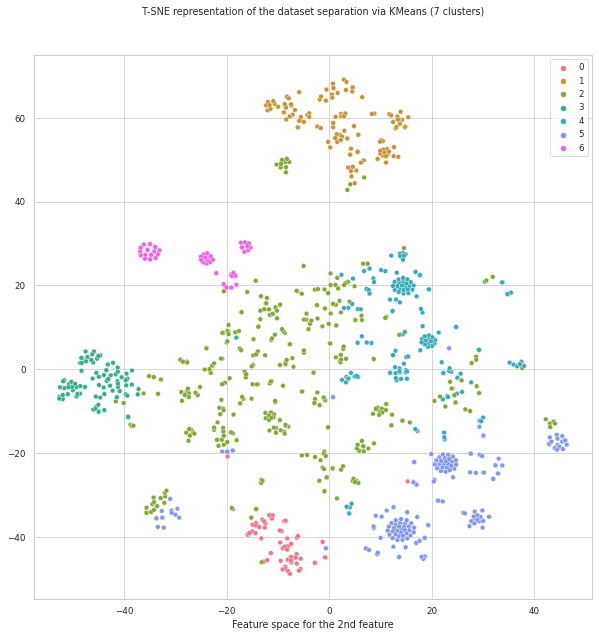

In [ ]:
tsne = TSNE(n_components=2, init="pca")
X_trans = tsne.fit_transform(X_pca)

plt.figure(figsize=(10, 10))
plt.title("T-SNE representation of the dataset separation via "
          "KMeans (7 clusters)")
sns.scatterplot(
    X_trans[:, 0],
    X_trans[:, 1],
    hue=model.labels_,
    legend="full",
    palette=sns.color_palette("husl", 7),

)
sns.set_context("paper", font_scale=1)
plt.xlabel("Feature space for the 1st feature")
plt.xlabel("Feature space for the 2nd feature")
plt.show()

In [ ]:
tot_data_label['k_means_cluster'].value_counts()

2    353
5    185
4    179
1    137
3     81
0     60
6     55
Name: k_means_cluster, dtype: int64

7


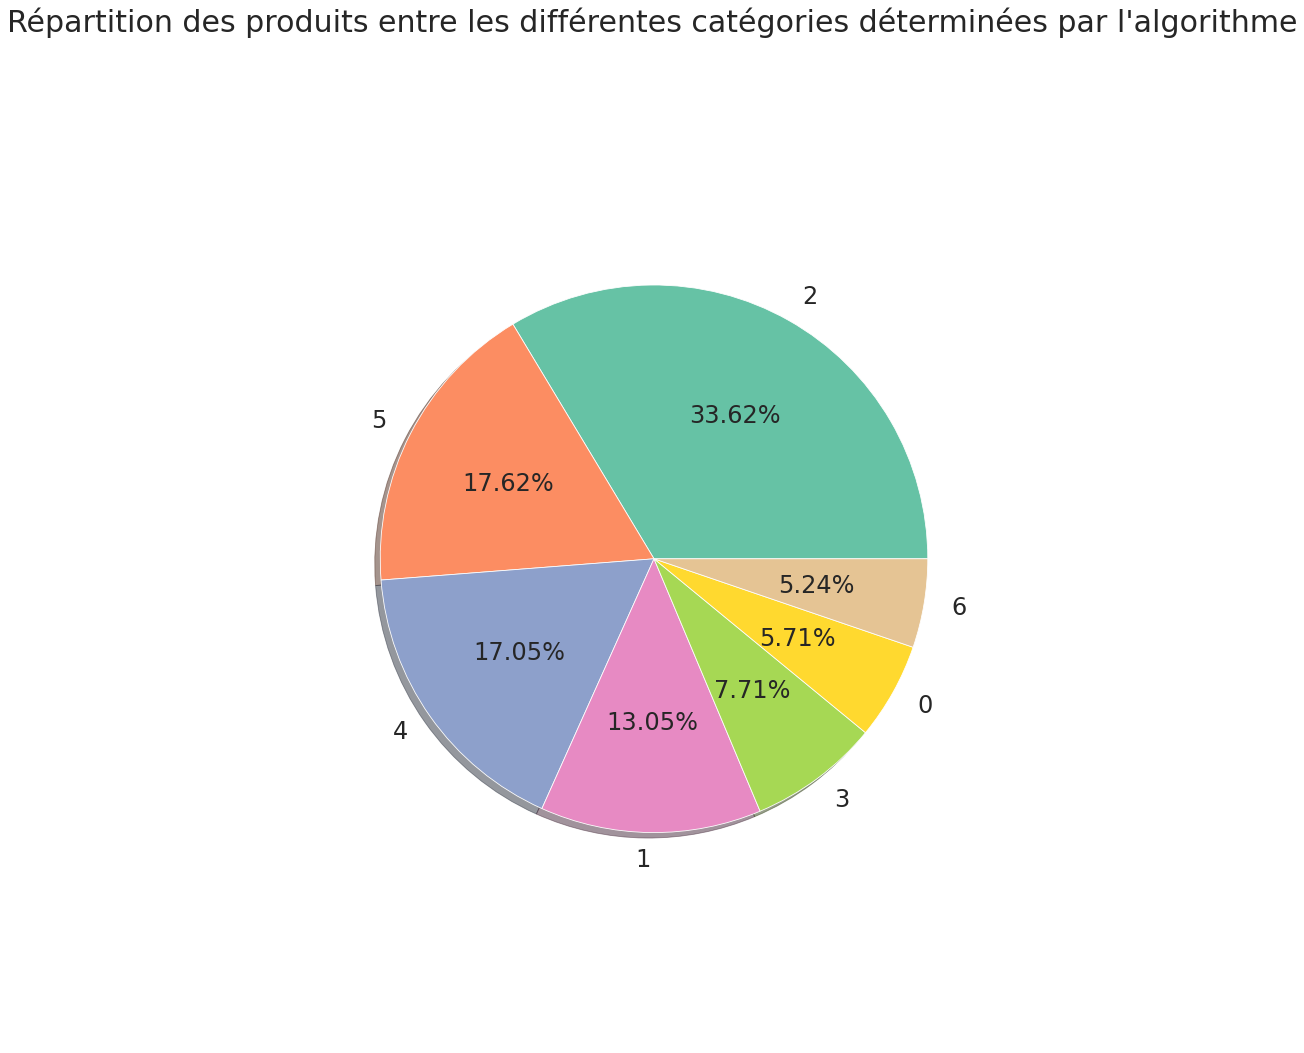

In [ ]:
from matplotlib import rcParams
rcParams['axes.titlepad'] = 40

values = tot_data_label['k_means_cluster'].value_counts()
labels = tot_data_label['k_means_cluster'].value_counts().index
#colors = ['gold', 'pink', 'grey', 'orange', 'green', 'blue', 'red']
#colors = ['#FBDD7E', '#04D8B2','#929591','#7BC8F6','#FFC0CB', '#C79FEF','#FFA500']

nb_cluster = len(tot_data_label['k_means_cluster'].value_counts().index)
print(nb_cluster)

cs = cm.Set2(np.arange(nb_cluster))

explode = (0, 0, 0, 0, 0, 0, 0)

# Plot
plt.figure(figsize=(15, 15))
plt.pie(values, explode=explode, labels=labels, colors=cs,
        autopct='%.2f%%', shadow=True, textprops={'fontsize': 24})

plt.title(
    "Répartition des produits entre les différentes catégories déterminées par l'algorithme", fontsize=30)

plt.axis('equal')
plt.tight_layout()

plt.show()

On peut voir que la répartitions des données dans les clusters déterminés par k-means est déséquilibrée comparé à la répartition des données par la détermination manuelle des colonnes. Voyons, pour chaque cluster, quelles sont les catégories déterminées manuellement que l'on retrouve dans chaque cluster et qui ont donc migrées dans d'autres clusters.

In [ ]:
label = np.arange(tot_data_label['k_means_cluster'].min(
), tot_data_label['k_means_cluster'].max()+1, 1)

for i in range(len(label)):
    df = tot_data_label.loc[tot_data_label['k_means_cluster'] == label.item(i)]
    cat = df['category'].unique()
    print('Dans le Cluster {} on retrouve des données réparties dans les catégories {} déterminées manuellement. \n \n' .format(
        label.item(i), cat))  # ['0', '1', '2', '3', '4', '5', '6']

Dans le Cluster 0 on retrouve des données réparties dans les catégories ['home_furnishing' 'baby_care'] déterminées manuellement. 
 

Dans le Cluster 1 on retrouve des données réparties dans les catégories ['watches'] déterminées manuellement. 
 

Dans le Cluster 2 on retrouve des données réparties dans les catégories ['home_furnishing' 'baby_care' 'watches' 'home_decor_and_festive_needs'
 'kitchen_and_dining' 'beauty_and_personal_care' 'computers'] déterminées manuellement. 
 

Dans le Cluster 3 on retrouve des données réparties dans les catégories ['baby_care'] déterminées manuellement. 
 

Dans le Cluster 4 on retrouve des données réparties dans les catégories ['beauty_and_personal_care' 'home_decor_and_festive_needs' 'baby_care'
 'kitchen_and_dining' 'computers'] déterminées manuellement. 
 

Dans le Cluster 5 on retrouve des données réparties dans les catégories ['home_furnishing' 'baby_care' 'beauty_and_personal_care' 'computers'
 'kitchen_and_dining'] déterminées manuellement. 


In [ ]:
table = pd.pivot_table(tot_data_label, values='label_category', index=['category'],  # , 'category'
                       columns=['k_means_cluster'], aggfunc=lambda x: len(x), fill_value=0)
table

k_means_cluster                0    1   2   3   4   5   6
category                                                 
baby_care                      5    0  35  81  13  15   1
beauty_and_personal_care       0    0  50   0  20  80   0
computers                      0    0  57   0  23  70   0
home_decor_and_festive_needs   0    0  75   0  75   0   0
home_furnishing               55    0  78   0   0  17   0
kitchen_and_dining             0    0  45   0  48   3  54
watches                        0  137  13   0   0   0   0

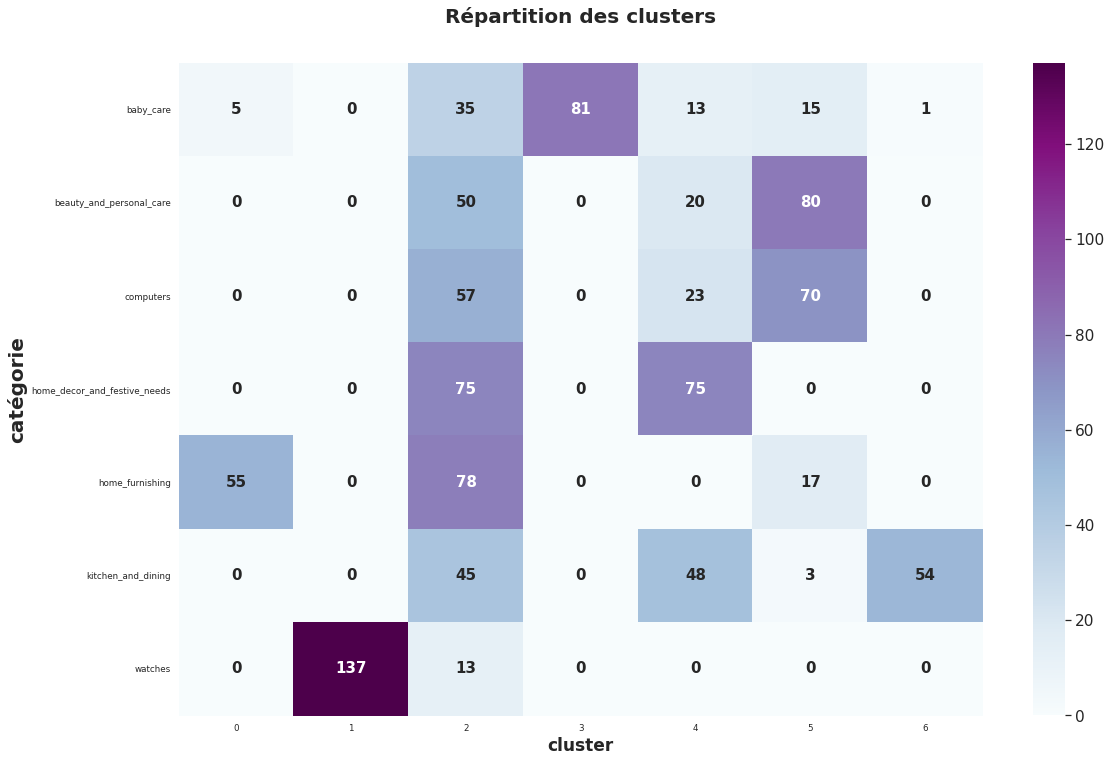

In [ ]:
plt.figure(figsize=(18, 12))
plt.title('Répartition des clusters', size=20, weight='bold')
sns.set(font_scale=1.4)  # for label size
sns.heatmap(table, annot=True,
            cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'},
            fmt='g')

plt.ylabel("catégorie", weight='bold', size=20)
plt.xlabel('cluster', weight='bold', size=17)
plt.show()

In [ ]:
clustering_resume = pd.DataFrame({})

clustering_resume = clustering_resume.append(
    pd.DataFrame(
        {
            "Algorithme": "Kmeans",
            "silhouette": silhouette_kmeans,
            "ARI": ARI_kmeans
        },
        index=[0],
    )
)

In [ ]:
clustering_resume

Algorithme  silhouette       ARI
0     Kmeans    0.122183  0.256783

## <font color='blue'>Clustering Hiérarchique</font>

In [ ]:
hierarchique = AgglomerativeClustering(n_clusters=7)

Exécution 
 
Nombre de lignes pris en compte pour le clustering 1050 
 

Qualité du Clustering 
 
 
Le coefficient de silhouette moyen est de 0.10958587963008497 pour la méthode clustering hiérarchique.
 
 
Le score ARI est de 0.22712963285698592 pour la méthode clustering hiérarchique. 
 

Visualisation 
 
 


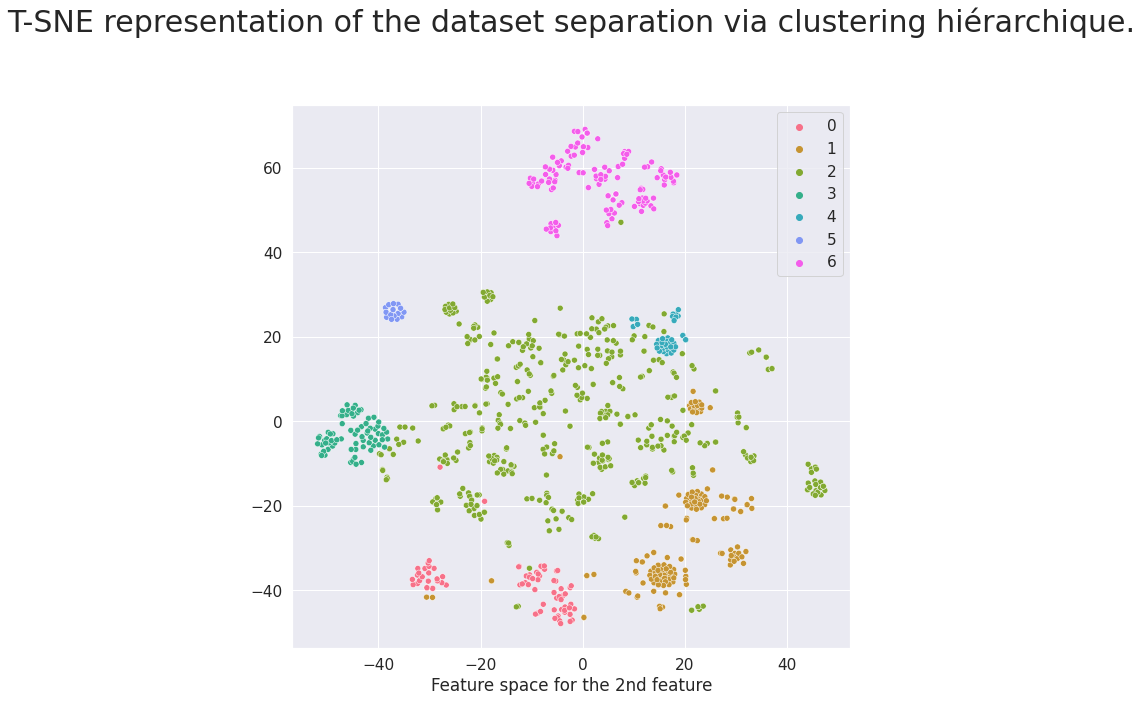

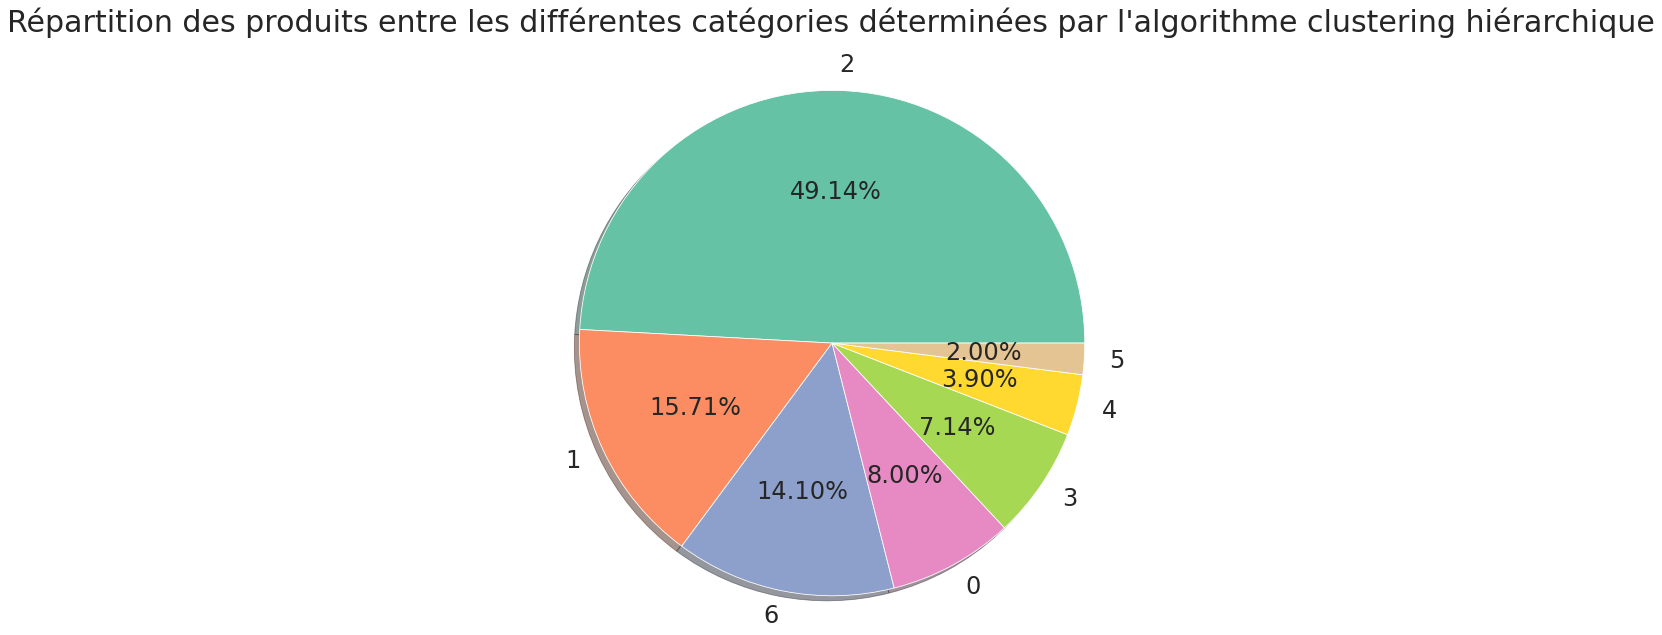

In [ ]:
silhouette, ARI, tot_data_label = clustering(
    hierarchique, X_pca, text_data['category'], text_data['label_category'], 'clustering hiérarchique')

Ici le coefficient de silhouette est positif mais assez proche de 0, ce qui permet de dire que les points sont globalement bien répartis entre les clusters et que les clusters sont proches les uns des autres (valeur proche de 0). Le clustering par la méthode du clustering hiérarchique est moins bon que celui par la méthode k-means.

Ici, l'indice ARI est de 0.22, ce qui veut dire que le clustering a été réalisé un peu aléatoirement. Ce clustering est moins efficace que le clustering par la méthode k-means.

In [ ]:
label = np.arange(tot_data_label['algo_cluster'].min(
), tot_data_label['algo_cluster'].max()+1, 1)
for i in range(len(label)):
    df = tot_data_label.loc[tot_data_label['algo_cluster'] == label.item(i)]
    cat = df['category'].unique()
    print('Dans le Cluster {} on retrouve des données réparties dans les catégories {} déterminées manuellement. \n \n' .format(label.item(i), cat))

Dans le Cluster 0 on retrouve des données réparties dans les catégories ['baby_care' 'home_furnishing'] déterminées manuellement. 
 

Dans le Cluster 1 on retrouve des données réparties dans les catégories ['home_furnishing' 'beauty_and_personal_care' 'baby_care'
 'kitchen_and_dining' 'home_decor_and_festive_needs' 'computers'] déterminées manuellement. 
 

Dans le Cluster 2 on retrouve des données réparties dans les catégories ['home_furnishing' 'watches' 'home_decor_and_festive_needs'
 'kitchen_and_dining' 'beauty_and_personal_care' 'computers' 'baby_care'] déterminées manuellement. 
 

Dans le Cluster 3 on retrouve des données réparties dans les catégories ['baby_care'] déterminées manuellement. 
 

Dans le Cluster 4 on retrouve des données réparties dans les catégories ['home_decor_and_festive_needs'] déterminées manuellement. 
 

Dans le Cluster 5 on retrouve des données réparties dans les catégories ['kitchen_and_dining'] déterminées manuellement. 
 

Dans le Cluster 6 on retrouv

In [ ]:
table = pd.pivot_table(tot_data_label, values='label_category', index=['category'],  # , 'category'
                       columns=['algo_cluster'], aggfunc=lambda x: len(x), fill_value=0)
table

algo_cluster                   0   1    2   3   4   5    6
category                                                  
baby_care                     17   9   49  75   0   0    0
beauty_and_personal_care       0  83   67   0   0   0    0
computers                      0  54   96   0   0   0    0
home_decor_and_festive_needs   0   1  108   0  41   0    0
home_furnishing               67  11   72   0   0   0    0
kitchen_and_dining             0   7  122   0   0  21    0
watches                        0   0    2   0   0   0  148

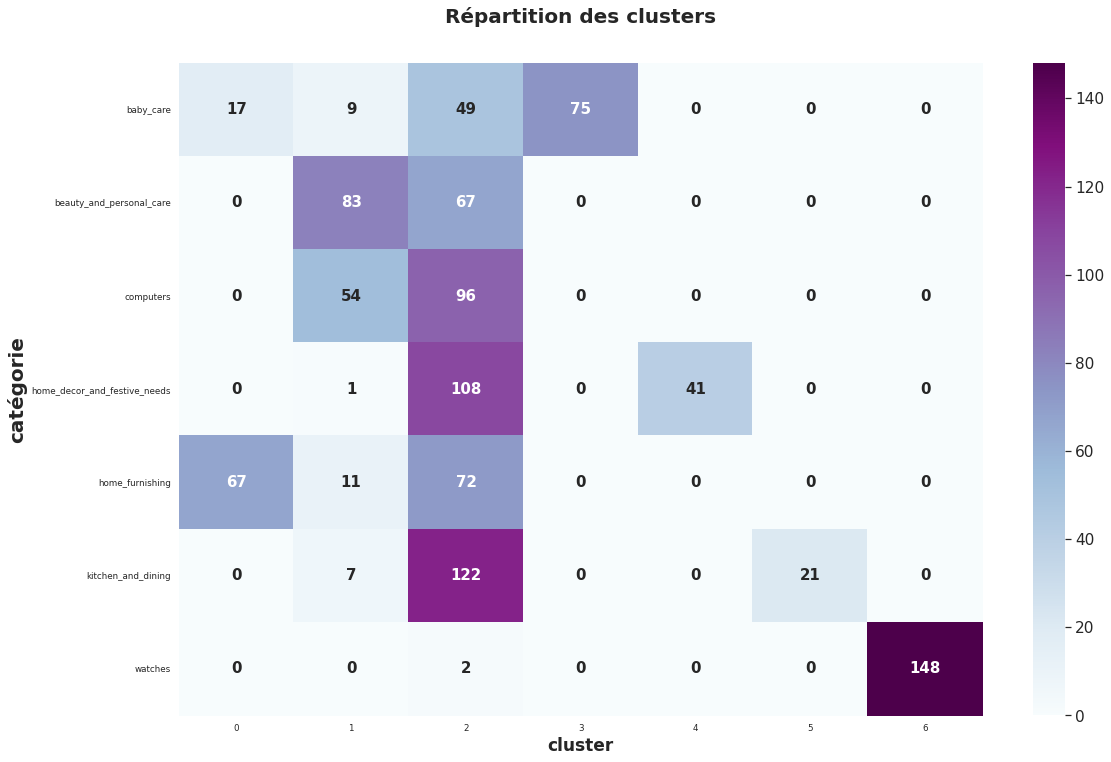

In [ ]:
plt.figure(figsize=(18, 12))
plt.title('Répartition des clusters', size=20, weight='bold')
sns.set(font_scale=1.4)  # for label size
sns.heatmap(table, annot=True,
            cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'},
            fmt='g')

plt.ylabel("catégorie", weight='bold', size=20)
plt.xlabel('cluster', weight='bold', size=17)
plt.show()

In [ ]:
clustering_resume = clustering_resume.append(
    pd.DataFrame(
        {
            "Algorithme": "clustering hiérarchique",
            "silhouette": silhouette,
            "ARI": ARI
        },
        index=[1],
    )
)

In [ ]:
clustering_resume

Algorithme  silhouette       ARI
0                   Kmeans    0.122183  0.256783
1  clustering hiérarchique    0.109586  0.227130

Dans notre cas, le clustering devrait être fait par k-means qui donne les meilleurs résultats (silhouette max et ARI max). Mais il faut tout de même trouver un algorithme qui donnera de meilleurs résultats car ici le clustering est peu efficace.

# <font color='green'>Classification avec réduction de dimension</font>

On réalise dans cette partie une classification via 3 algorithmes:

- Kmeans
- random forest
- sklearn.naive_bayes.MultinomialNB

Nous allons comparer les clusters obtenus ainsi que la classification sur sa qualité par le score de l'accuracy, de la précision mais aussi comparer les clusters obtenus par rapport aux classes réelles des objets grâce à l'indice de Rand ajusté (ARI). On produira des visualisations par pie plot.

### <font color='olive'>Préparation</font>

fichier avec les descriptions nettoyées

In [ ]:
text_data.head()

image         category  label_category  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  home_furnishing               4   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        baby_care               0   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        baby_care               0   
3  d4684dcdc759dd9cdf41504698d737d8.jpg  home_furnishing               4   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  home_furnishing               4   

                        description_untokenize_clean  
0  feature elegance polyester multicolor abstract...  
1  specification sathiyas cotton bath towel bath ...  
2  feature eurospa cotton terry face towel size s...  
3  feature santosh royal fashion cotton printed k...  
4  feature jaipur print cotton floral king sized ...

#### <font color='grey'>Séparation en train/test test</font>

In [ ]:
X = text_data.copy()
y = X['category']
X = X.drop(['category'], axis=1)
X = X[X.columns]
# Split en training/testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2  # 20% des données dans le jeu de test = 20% de short data
                                                    , random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(840, 3) (210, 3) (840,) (210,)


In [ ]:
tfidfvectorizer = TfidfVectorizer(encoding='utf-8',
                                  strip_accents=None,
                                  lowercase=True,
                                  preprocessor=None,
                                  tokenizer=None,
                                  analyzer='word',
                                  stop_words=all_stopwords,
                                  max_df=0.95,
                                  min_df=0.01)

#### <font color='grey'>tfidf train set</font>

In [ ]:
X_train.head()

image  label_category  \
554   b144a363c107c7bdd91f32d6e28ba6f2.jpg               6   
1012  29def171d7e31d48571a52f0fb3e6b07.jpg               3   
481   9f9bb0ef3bb8af571bcfbfa1a22150bd.jpg               2   
432   7f2f1f3039d1f5bc23226fc36577eab9.jpg               2   
626   73901494efea71869576898c68b5eee4.jpg               4   

                           description_untokenize_clean  
554   timewel analog watch timewel analog watch onli...  
1012  ceramic inside fitting hookah mouth black pric...  
481   lapguard pavilion series cell laptop battery f...  
432   feature smartpro replacement charger vaio seri...  
626   feature ville style polyester maroon floral ey...

In [ ]:
# convert the dataframe's column into a matrix
X_train_tfidf = tfidfvectorizer.fit_transform(
    X_train['description_untokenize_clean'])

In [ ]:
X_train_tokens = tfidfvectorizer.get_feature_names()
len(X_train_tokens)

435

In [ ]:
df_tfidf_Xtrain = pd.DataFrame(data=X_train_tfidf.toarray(),
                               index=X_train.index,
                               columns=X_train_tokens)

In [ ]:
print("\nTD-IDF Vectorizer train test\n")
df_tfidf_Xtrain


TD-IDF Vectorizer train test



abstract  accessory   actual   adapter  additional  adorable  \
554        0.0   0.000000  0.00000  0.000000    0.000000       0.0   
1012       0.0   0.000000  0.00000  0.000000    0.000000       0.0   
481        0.0   0.000000  0.00000  0.000000    0.000000       0.0   
432        0.0   0.042656  0.04316  0.619666    0.000000       0.0   
626        0.0   0.000000  0.00000  0.000000    0.051256       0.0   
...        ...        ...      ...       ...         ...       ...   
330        0.0   0.000000  0.00000  0.000000    0.000000       0.0   
466        0.0   0.000000  0.00000  0.000000    0.102668       0.0   
121        0.0   0.000000  0.00000  0.000000    0.000000       0.0   
1044       0.0   0.000000  0.00000  0.000000    0.000000       0.0   
860        0.0   0.000000  0.00000  0.000000    0.000000       0.0   

      affordable    analog  apply  area  aroma  around   assured  attractive  \
554          0.0  0.545941    0.0   0.0    0.0     0.0  0.000000         0.0   
1012         0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
481          0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
432          0.0  0.000000    0.0   0.0    0.0     0.0  0.045522         0.0   
626          0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
...          ...       ...    ...   ...    ...     ...       ...         ...   
330          0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
466          0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
121          0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
1044         0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
860          0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   

         audio  authentication  available      baby     back  base  bath  \
554   0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   
1012  0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   
481   0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   
432   0.046993        0.046227        0.0  0.000000  0.03787   0.0   0.0   
626   0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   
...        ...             ...        ...       ...      ...   ...   ...   
330   0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   
466   0.000000        0.000000        0.0  0.292953  0.00000   0.0   0.0   
121   0.000000        0.000000        0.0  0.365204  0.00000   0.0   0.0   
1044  0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   
860   0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   

       battery  beautiful  beautifully  bedroom  ...   voltage  wall  \
554   0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   
1012  0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   
481   0.320023   0.000000          0.0      0.0  ...  0.000000   0.0   
432   0.035625   0.000000          0.0      0.0  ...  0.136566   0.0   
626   0.000000   0.064212          0.0      0.0  ...  0.000000   0.0   
...        ...        ...          ...      ...  ...       ...   ...   
330   0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   
466   0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   
121   0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   
1044  0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   
860   0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   

      wardrobe      warm  warranty      wash  washable    watch     water  \
554        0.0  0.000000  0.000000  0.000000       0.0  0.52066  0.000000   
1012       0.0  0.000000  0.000000  0.000000       0.0  0.00000  0.000000   
481        0.0  0.000000  0.000000  0.000000       0.0  0.00000  0.000000   
432        0.0  0.000000  0.307845  0.000000       0.0  0.00000  0.000000   
626        0.0  0.074919  0.000000  0.102

#### <font color='grey'>tfidf test set</font>

In [ ]:
X_test.head()

image  label_category  \
352  833a87b0af3b84fe246d2ebf271af177.jpg               2   
689  55195de3873fffaa9e37b041533d7305.jpg               5   
485  44b963eb856b4831dfdd21b666593c95.jpg               2   
388  98ad5b99ad96695568d8f143b11ab740.jpg               1   
31   29b1ca231e10d5269516b80bf9d0dffc.jpg               6   

                          description_untokenize_clean  
352  zyxel flipkart genuine product replacement gua...  
689  philip bulb online philip bulb best price free...  
485  lapguard lenovo ideapad cell laptop battery pr...  
388  flipkart anna andre paris dark fire numero deo...  
31   lenco bdblue tango analog watch boy lenco bdbl...

In [ ]:
# convert the dataframe's column into a matrix
X_test_tfidf = tfidfvectorizer.transform(  # transform se base sur un modèle dejà créé alors que fit_tansform recalcul le modèle
    X_test['description_untokenize_clean'])

In [ ]:
# retrieve the terms found in the corpora
# if we take same parameters on both Classes(CountVectorizer and TfidfVectorizer),
# it will give same output of get_feature_names() methods)
X_test_tokens = tfidfvectorizer.get_feature_names()
len(X_test_tokens)

435

In [ ]:
df_tfidf_Xtest = pd.DataFrame(data=X_test_tfidf.toarray(),
                              index=X_test.index,
                              columns=X_test_tokens)

In [ ]:
print("\nTD-IDF Vectorizer\n")
df_tfidf_Xtest


TD-IDF Vectorizer



abstract  accessory    actual  adapter  additional  adorable  affordable  \
352  0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   
689  0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   
485  0.000000        0.0  0.099575      0.0    0.000000       0.0    0.000000   
388  0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   
31   0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   
..        ...        ...       ...      ...         ...       ...         ...   
694  0.119227        0.0  0.000000      0.0    0.000000       0.0    0.154708   
539  0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   
449  0.000000        0.0  0.000000      0.0    0.091757       0.0    0.000000   
622  0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   
209  0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   

       analog  apply  area  aroma  around   assured  attractive  audio  \
352  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
689  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
485  0.000000    0.0   0.0    0.0     0.0  0.105024         0.0    0.0   
388  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
31   0.330851    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
..        ...    ...   ...    ...     ...       ...         ...    ...   
694  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
539  0.277420    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
449  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
622  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
209  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   

     authentication  available      baby      back  base  bath   battery  \
352        0.000000        0.0  0.000000  0.000000   0.0   0.0  0.000000   
689        0.000000        0.0  0.000000  0.000000   0.0   0.0  0.000000   
485        0.106651        0.0  0.000000  0.000000   0.0   0.0  0.616434   
388        0.000000        0.0  0.000000  0.000000   0.0   0.0  0.000000   
31         0.000000        0.0  0.000000  0.000000   0.0   0.0  0.000000   
..              ...        ...       ...       ...   ...   ...       ...   
694        0.000000        0.0  0.000000  0.000000   0.0   0.0  0.000000   
539        0.000000        0.0  0.000000  0.193041   0.0   0.0  0.000000   
449        0.000000        0.0  0.349092  0.000000   0.0   0.0  0.000000   
622        0.000000        0.0  0.312674  0.000000   0.0   0.0  0.000000   
209        0.000000        0.0  0.000000  0.000000   0.0   0.0  0.000000   

     beautiful  beautifully  bedroom  ...   voltage  wall  wardrobe  warm  \
352   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
689   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
485   0.000000          0.0      0.0  ...  0.105024   0.0       0.0   0.0   
388   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
31    0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
..         ...          ...      ...  ...       ...   ...       ...   ...   
694   0.257409          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
539   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
449   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
622   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
209   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   

     warranty      wash  washable     watch     water      wear  wedding  \
352       0.0  0.000000       0.0  0.000000  0.000000  0.000000      0.0   
689       0.0  0.000000       0.0  0.000000  0.000000  0.000000      0.0   
485       0.0  0.000000       0.0  0.000000  0.000000  0.000000      0.0   
3

#### <font color='grey'>Reduction de dimension PCA</font>

In [ ]:
df_tfidf_Xtrain.shape

(840, 435)

In [ ]:
pca = PCA(n_components=df_tfidf_Xtrain.shape[1], random_state=40)
pca.fit_transform(df_tfidf_Xtrain)

array([[ 3.57268676e-01,  6.59385346e-01,  1.03294860e-02, ...,
        -4.74104885e-18,  4.75376482e-17, -4.93573222e-18],
       [-3.06965041e-01, -2.22020180e-02,  3.66946805e-02, ...,
         1.39378362e-19,  2.42866647e-18, -2.06242984e-18],
       [ 1.46876237e-01, -1.06292064e-01, -6.82393897e-02, ...,
        -1.41139875e-17,  4.67235140e-17, -1.74352425e-18],
       ...,
       [-3.56645851e-01, -3.27831051e-02, -2.05330169e-01, ...,
        -5.44374529e-18,  5.23713693e-18,  2.29574386e-17],
       [-3.19897873e-02, -7.04151880e-02,  1.08555955e-01, ...,
         1.72529217e-17, -4.25527651e-18,  1.02716318e-17],
       [ 1.70259827e-01, -1.19213810e-01,  1.54907172e-01, ...,
         1.42923335e-17,  1.05468087e-17, -3.64099946e-18]])

In [ ]:
X_pca_train = pca.transform(df_tfidf_Xtrain)[:, :c]
X_pca_test = pca.transform(df_tfidf_Xtest)[:, :c]

### <font color='olive'>Knn classifier</font>

In [ ]:
# GridSearch
# create new a knn model
knn2 = KNeighborsClassifier()

# create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
score = 'accuracy'

# use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

# Fit sur le training set.
knn_gscv.fit(X_pca_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
best_param = knn_gscv.best_estimator_
print("Best paramètres: {}".format(best_param))

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
    knn_gscv.cv_results_['mean_test_score'],  # score moyen
    knn_gscv.cv_results_['std_test_score'],  # écart-type du score
    knn_gscv.cv_results_['params']           # valeur de l'hyperparamètre
):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ))

Best paramètres: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Résultats de la validation croisée :
accuracy = 0.867 (+/-0.039) for {'n_neighbors': 1}
accuracy = 0.844 (+/-0.029) for {'n_neighbors': 2}
accuracy = 0.871 (+/-0.026) for {'n_neighbors': 3}
accuracy = 0.873 (+/-0.018) for {'n_neighbors': 4}
accuracy = 0.877 (+/-0.019) for {'n_neighbors': 5}
accuracy = 0.876 (+/-0.032) for {'n_neighbors': 6}
accuracy = 0.873 (+/-0.032) for {'n_neighbors': 7}
accuracy = 0.858 (+/-0.049) for {'n_neighbors': 8}
accuracy = 0.865 (+/-0.039) for {'n_neighbors': 9}
accuracy = 0.862 (+/-0.036) for {'n_neighbors': 10}
accuracy = 0.870 (+/-0.030) for {'n_neighbors': 11}
accuracy = 0.864 (+/-0.042) for {'n_neighbors': 12}
accuracy = 0.863 (+/-0.043) for {'n_neighbors': 13}
accuracy = 0.862 (+/-0.046) for {'n_neighbors': 14}
accuracy = 0.864 (+/-0.046) for {'n_neig

Exécution 
 
Qualité de la classification 
 
 
L'accuracy score est de 0.861904761904762 pour la méthode knn PCA.
 
 
Le score de précision est de 0.8631773399014778 pour la méthode knn PCA.
 
 
Le score recall est de 0.861904761904762 pour la méthode knn PCA.
 
 
Le score f1 est de 0.8612876012876013 pour la méthode knn PCA.
 
 
Visualisation 
 
 


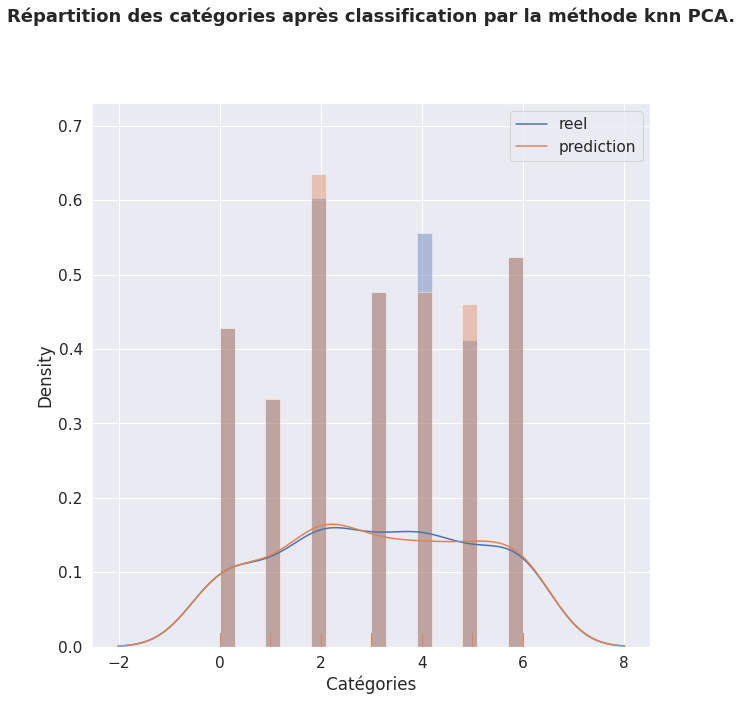

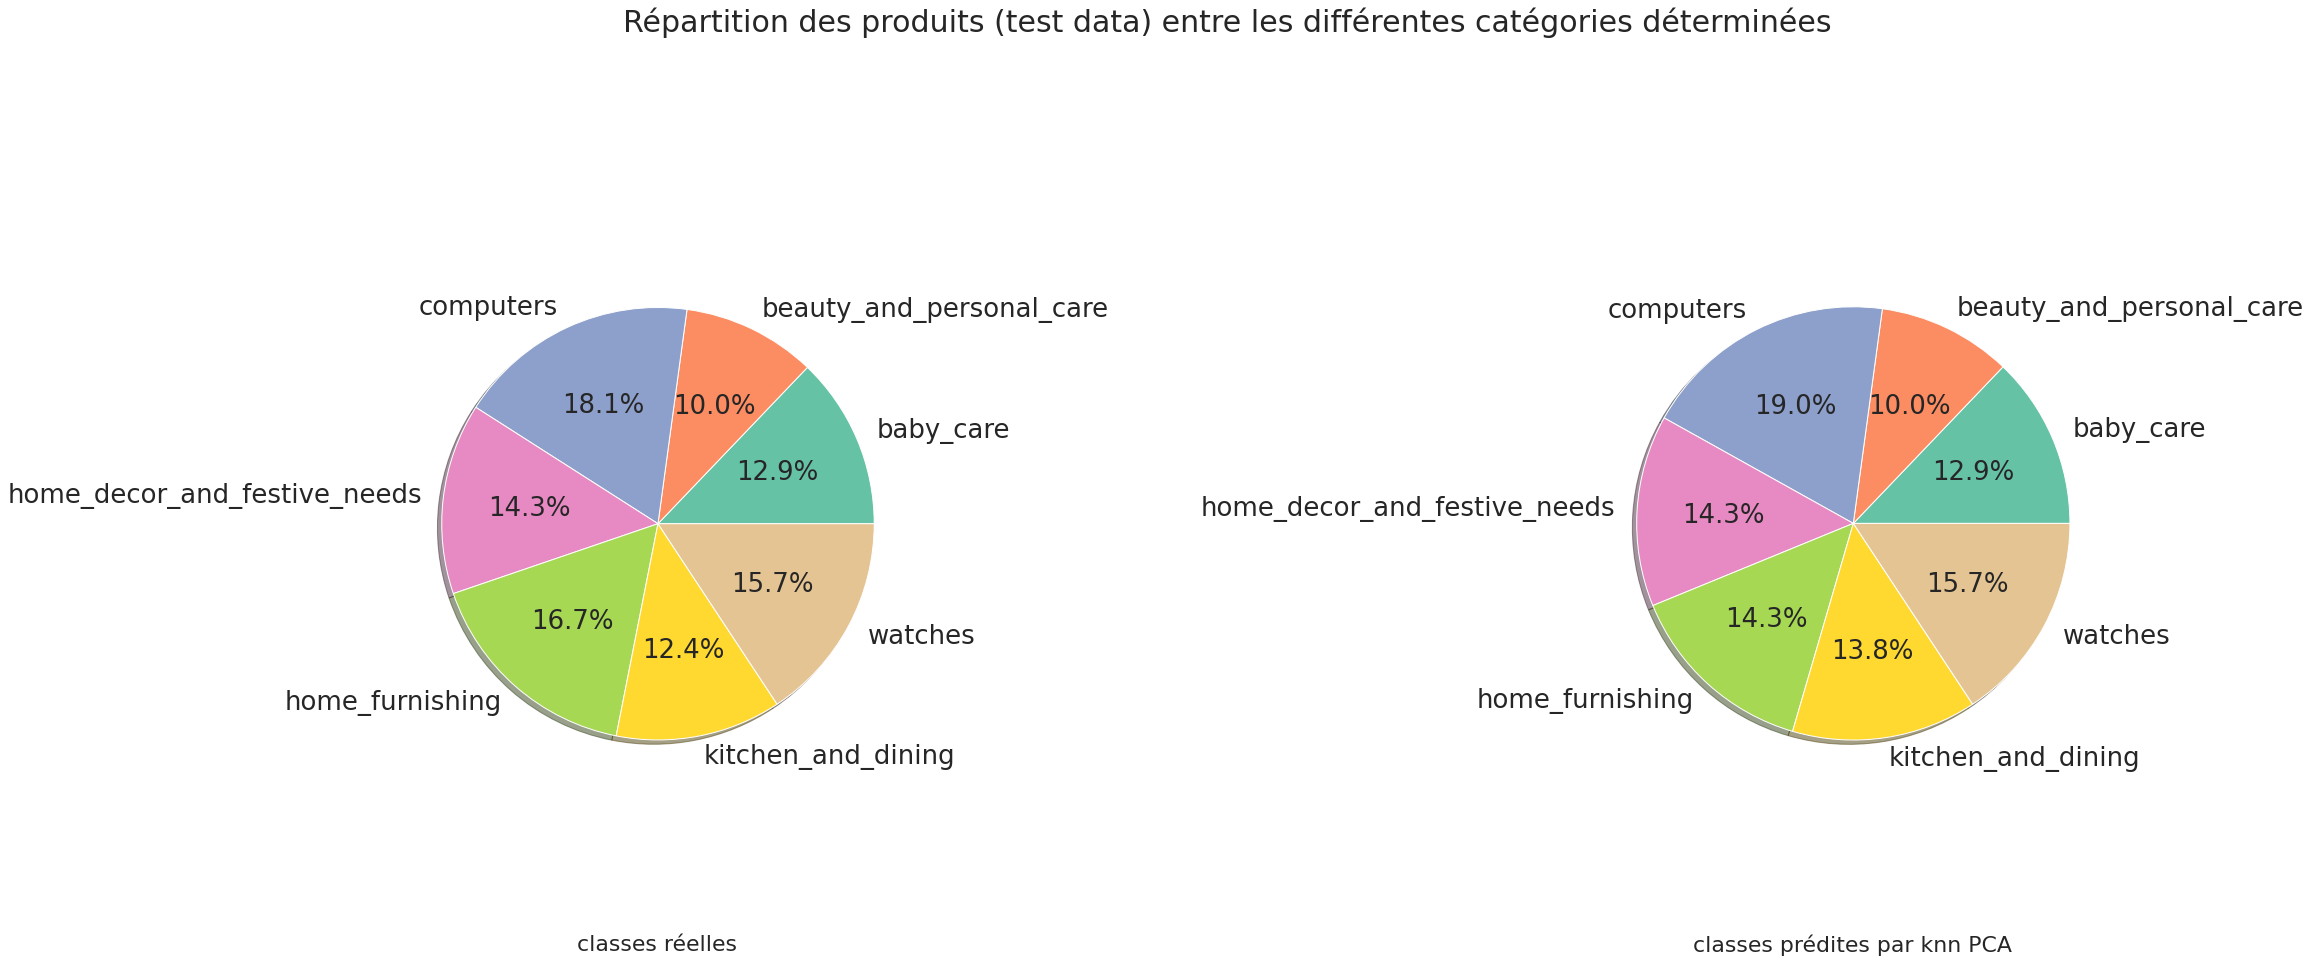

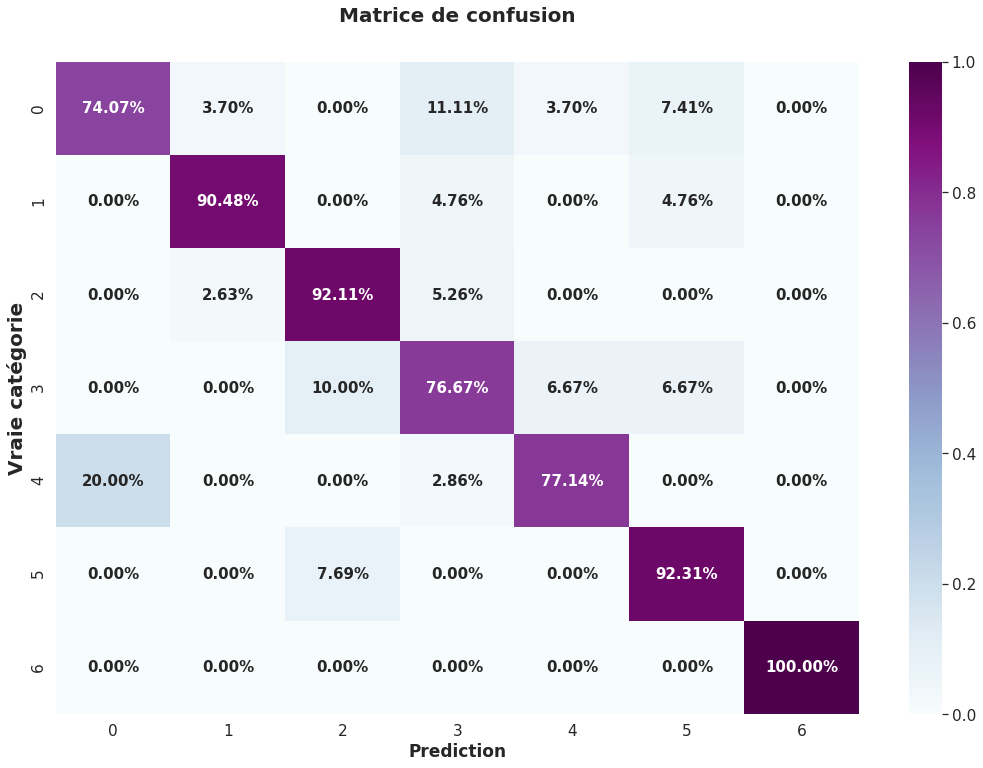

In [ ]:
accuracy, precision, recall, f1, resume_class = classification(
    best_param, X_pca_train, y_train, X_pca_test, y_test, 'knn PCA')

Score d'exactitude de la classification.

Dans la classification multi-label, cette fonction calcule la précision du sous-ensemble : l'ensemble des étiquettes prédites pour un échantillon doit correspondre exactement à l'ensemble correspondant des étiquettes dans y_true. Plus ce score est grand et plus la prédiction des catégories des produits correspond aux catégories déterminées manuellement. Il est donc à maximiser. Il indique le pourcentage de bonnes prédictions. 
Ici le score d'accuracy est de 0.86 ce qui montre que la classification fonctionne bien avec une grande précision.



La précision est la capacité du classificateur à ne pas étiqueter un produit avec la mauvaise catégorie.
Ici le score de précision est de 0.86 montre que la classification est assez précise car le score est proche de 1.


Le rappel est le rapport tp / (tp + fn) où tp est le nombre de vrais positifs et fn le nombre de faux négatifs. Il correspond à la part de faux négatifs.
La meilleure valeur est 1 et la plus mauvaise valeur est 0.
Ici le score de recall est de 0.86 montre que la classification fait en majorité des vrais positifs car le score est proche de 1.

Le score F1 peut être interprété comme une moyenne pondérée de la précision et du recall, où un score F1 atteint sa meilleure valeur à 1 et son plus mauvais score à 0. La formule pour le score F1 est la suivante :
F1 = 2 * (précision * rappel) / (précision + rappel)

Les labels des catégories prédites correspondent aux labels des catégories réelles pour les donnéees test. Avec ce graphique, on peut voir que les catégories prédites sont proches de la classification manuelle. On peut voir aussi que pour la categorie 4, la classification par knn regroupe moins de produits dans ces catégorie par rapport à la réalité. La conclusion inverse peut être faîte pour les categories 2 et 5. Pour les catégories 0, 1, 3 et 6, la classification par knn regroupe autant de produits dans ces catégories par rapport à la réalité. 


L'algorithme fait des erreurs lors de la classification des catégories 0, 3, 4.

In [ ]:
classification_resume_PCA = pd.DataFrame({})

classification_resume_PCA = classification_resume_PCA.append(
    pd.DataFrame(
        {
            "Algorithme": "knn",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        },
        index=[0],
    )
)

In [ ]:
classification_resume_PCA

Algorithme  accuracy  precision    recall  f1_score
0        knn  0.861905   0.863177  0.861905  0.861288

### <font color='olive'>Random Forest</font>

In [ ]:
# GridSearch
param_grid = [{'max_depth': range(2, 10, 2)}]
gridSearch = GridSearchCV(RandomForestClassifier(),
                          param_grid, cv=5, scoring='accuracy')
score = 'accuracy'


# Fit sur le training set.
gridSearch.fit(X_pca_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
best_param = gridSearch.best_estimator_
print("Best paramètres: {}".format(best_param))

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
    gridSearch.cv_results_['mean_test_score'],  # score moyen
    gridSearch.cv_results_['std_test_score'],  # écart-type du score
    gridSearch.cv_results_['params']           # valeur de l'hyperparamètre
):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ))

Best paramètres: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Résultats de la validation croisée :
accuracy = 0.821 (+/-0.069) for {'max_depth': 2}
accuracy = 0.861 (+/-0.033) for {'max_depth': 4}
accuracy = 0.873 (+/-0.048) for {'max_depth': 6}
accuracy = 0.880 (+/-0.028) for {'max_depth': 8}


Exécution 
 
Qualité de la classification 
 
 
L'accuracy score est de 0.9095238095238095 pour la méthode Random Forest PCA.
 
 
Le score de précision est de 0.9102215640205836 pour la méthode Random Forest PCA.
 
 
Le score recall est de 0.9095238095238095 pour la méthode Random Forest PCA.
 
 
Le score f1 est de 0.9088152967680333 pour la méthode Random Forest PCA.
 
 
Visualisation 
 
 


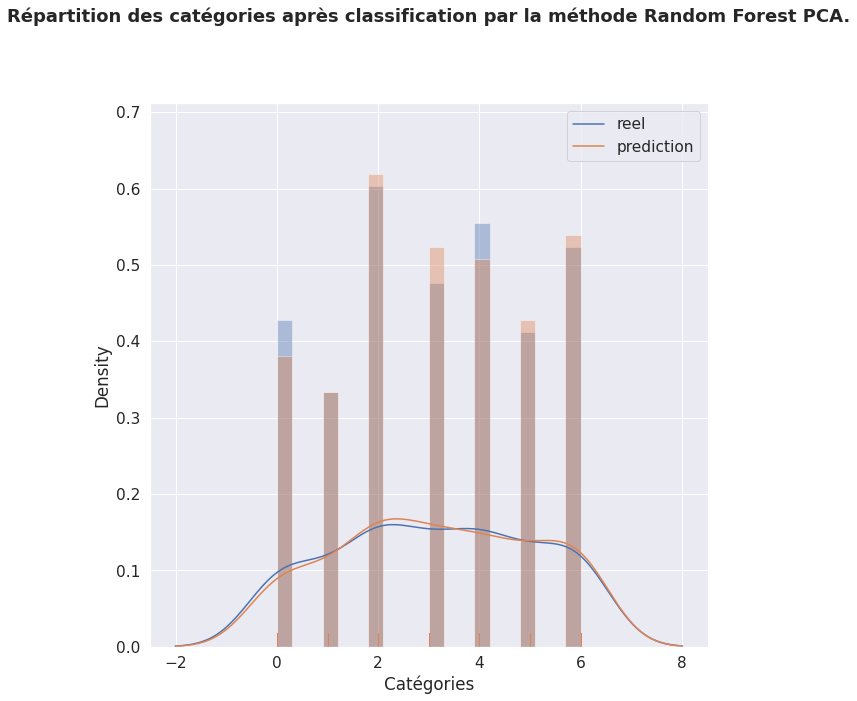

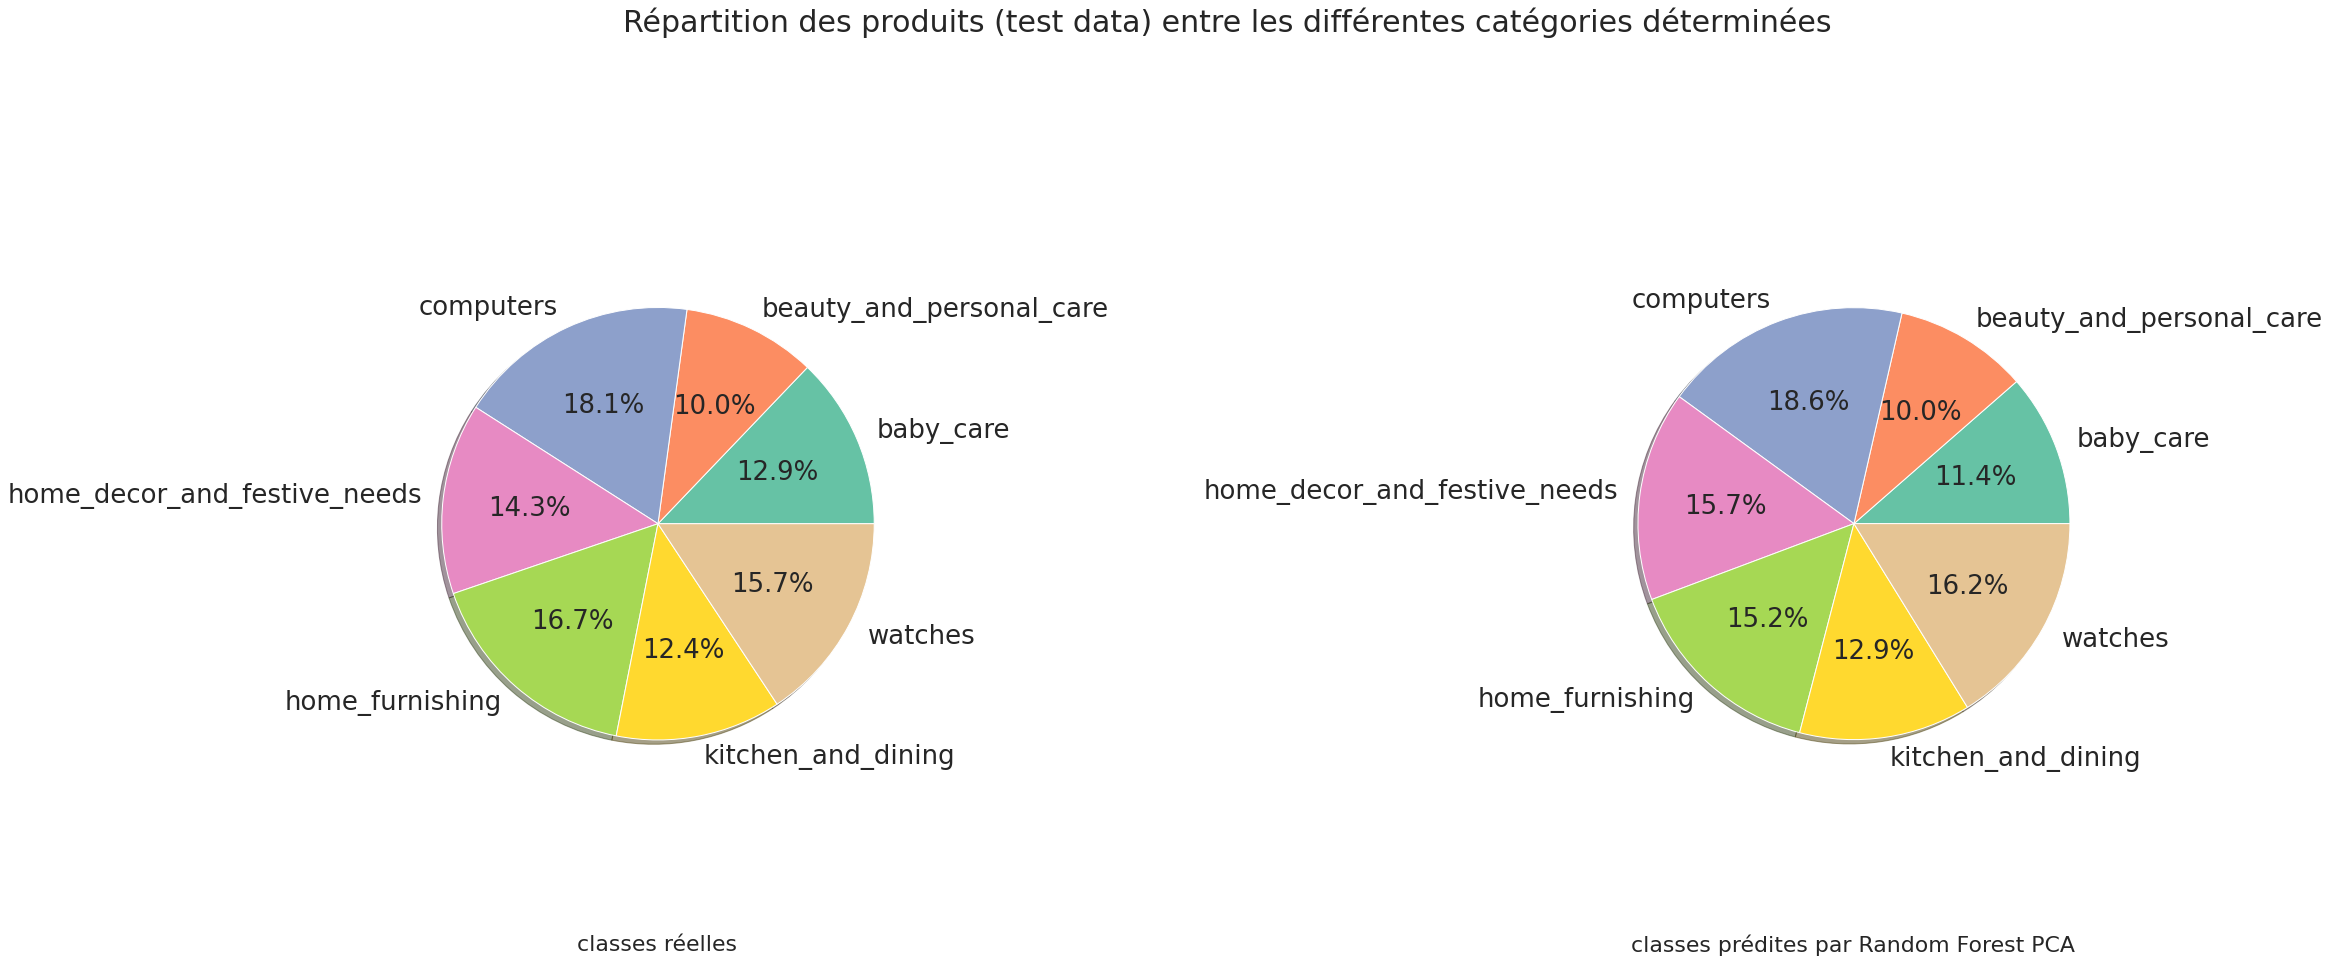

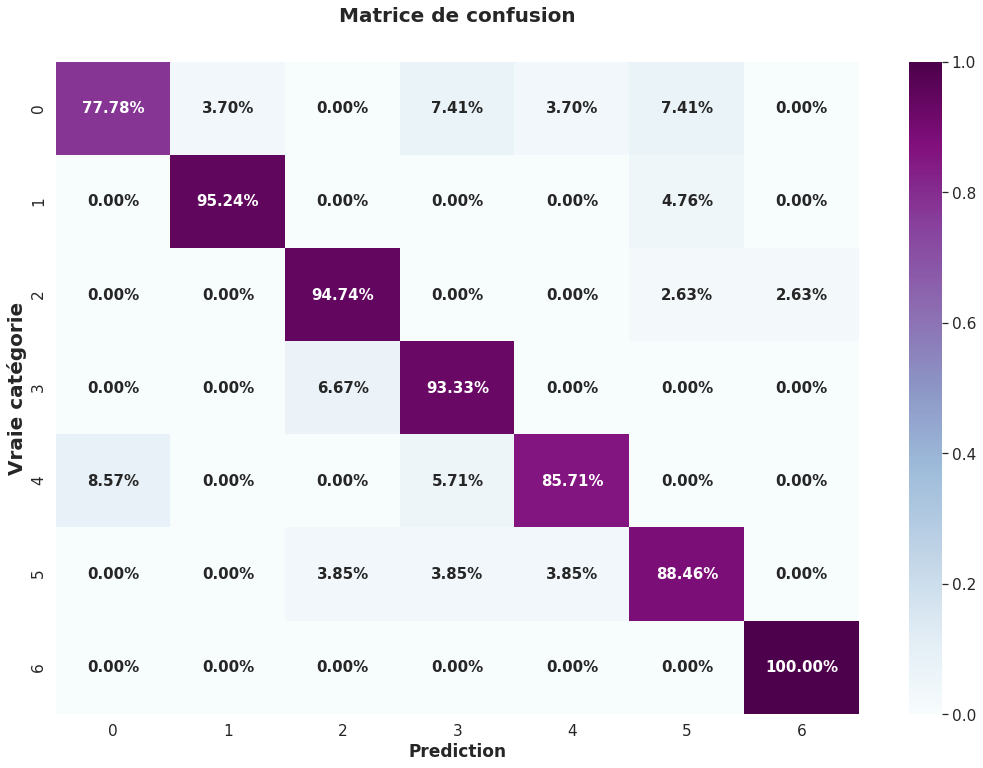

In [ ]:
accuracy, precision, recall, f1, resume_class = classification(
    best_param, X_pca_train, y_train, X_pca_test, y_test, 'Random Forest PCA', 'classification_model_random_forest_description.sav')

Ici le score d'accuracy est de 0.909 ce qui montre que la classification fonctionne bien avec une grande précision.

Ici le score de précision est de 0.910 montre que la classification est assez précise car le score est proche de 1.

Ici le score de recall est de 0.909 montre que la classification fait en majorité des vrais positifs car le score est proche de 1.

Les labels des catégories prédites correspondent aux labels des catégories réelles pour les donnéees test. Avec ce graphique, on peut voir que les catégories prédites sont proches de la classification manuelle. On peut voir aussi que pour les categories 0 et 4, la classification regroupe moins de produits dans ces catégorie par rapport à la réalité. La conclusion inverse peut être faîte pour les catégories 2, 3, 5 et 6. Pour la catégorie 1, la classification par random forest regroupe autant de produits dans cette catégorie par rapport à la réalité. 

L'algorithme a plus de mal à prédire la catégorie 0.

In [ ]:
classification_resume_PCA = classification_resume_PCA.append(
    pd.DataFrame(
        {
            "Algorithme": "Random Forest",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        },
        index=[1],
    )
)

In [ ]:
classification_resume_PCA

Algorithme  accuracy  precision    recall  f1_score
0            knn  0.861905   0.863177  0.861905  0.861288
1  Random Forest  0.909524   0.910222  0.909524  0.908815

### <font color='olive'>naive_bayes.MultinomialNB </font>

Cet algorithme ne peut pas fonctionner avec des valeurs négatives. Or ici il y en a, c'est pourquoi je décide de transformer mes valeurs et de les mettre à la même échelle dans l'intervalle [0,1].

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# transform data
X_pca_train = scaler.fit_transform(X_pca_train)
X_pca_test = scaler.fit_transform(X_pca_test)

Classificateur Naive Bayes pour les modèles multinomiaux

Les méthodes de Bayes naïves sont un ensemble d'algorithmes d'apprentissage supervisé basés sur l'application du théorème de Bayes (probabilités conditionnelles) avec l'hypothèse "naïve" d'indépendance conditionnelle entre chaque paire de caractéristiques étant donné la valeur de la variable de classe.

Le classificateur Naive Bayes multinomial convient à la classification avec des caractéristiques discrètes (par exemple, le nombre de mots pour la classification de textes). La distribution multinomiale requiert normalement des nombres entiers de caractéristiques. Cependant, dans la pratique, des comptes fractionnaires tels que tf-idf peuvent également fonctionner.


Le problème de classification revient à estimer la probabilité de chaque classe sachant un vecteur de caractéristiques. Par exemple, on veut estimer la probabilité d’un animal étant: un chien, un chat, une vache ou autre (4 classes) en utilisant quelques caractéristiques: poids, longueur, longueur des pattes et le type de nourriture.

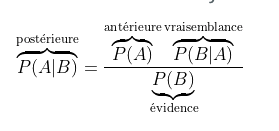

Les probabilités calculées servent à sélectionner la classe la plus probable sachant un vecteur de caractéristiques donné. Donc, la classe estimée (c ) est celle qui maximise la probabilité conditionnelle. la probabilité d’apparition d’une classe c-i est estimée comme étant le nombre de ses échantillons divisé par le nombre total des échantillons d’entrainement.

In [ ]:
# GridSearch
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10.0]
              }

gridSearch = GridSearchCV(MultinomialNB(), param_grid,
                          cv=5, scoring='accuracy')
score = 'accuracy'


# Fit sur le training set.
gridSearch.fit(X_pca_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
best_param = gridSearch.best_estimator_
print("Best paramètres: {}".format(best_param))

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
    gridSearch.cv_results_['mean_test_score'],  # score moyen
    gridSearch.cv_results_['std_test_score'],  # écart-type du score
    gridSearch.cv_results_['params']           # valeur de l'hyperparamètre
):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ))

Best paramètres: MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)
Résultats de la validation croisée :
accuracy = 0.817 (+/-0.058) for {'alpha': 0.0001}
accuracy = 0.817 (+/-0.058) for {'alpha': 0.001}
accuracy = 0.817 (+/-0.058) for {'alpha': 0.01}
accuracy = 0.817 (+/-0.058) for {'alpha': 0.1}
accuracy = 0.815 (+/-0.060) for {'alpha': 0.5}
accuracy = 0.814 (+/-0.063) for {'alpha': 1.0}
accuracy = 0.796 (+/-0.072) for {'alpha': 10.0}


Exécution 
 
Qualité de la classification 
 
 
L'accuracy score est de 0.8952380952380953 pour la méthode MultinomialNB PCA.
 
 
Le score de précision est de 0.9052119837834124 pour la méthode MultinomialNB PCA.
 
 
Le score recall est de 0.8952380952380953 pour la méthode MultinomialNB PCA.
 
 
Le score f1 est de 0.8947588902167917 pour la méthode MultinomialNB PCA.
 
 
Visualisation 
 
 


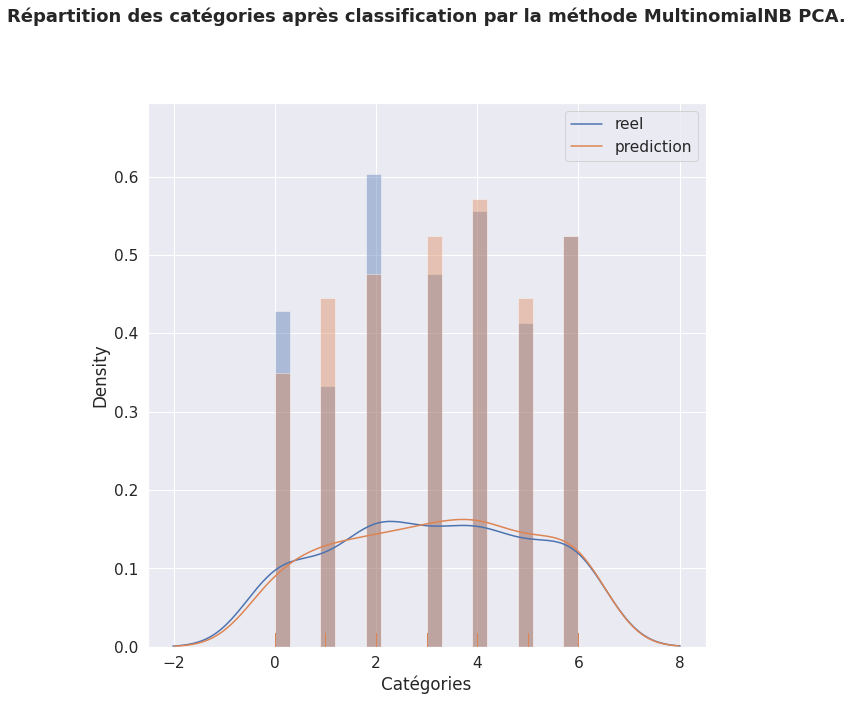

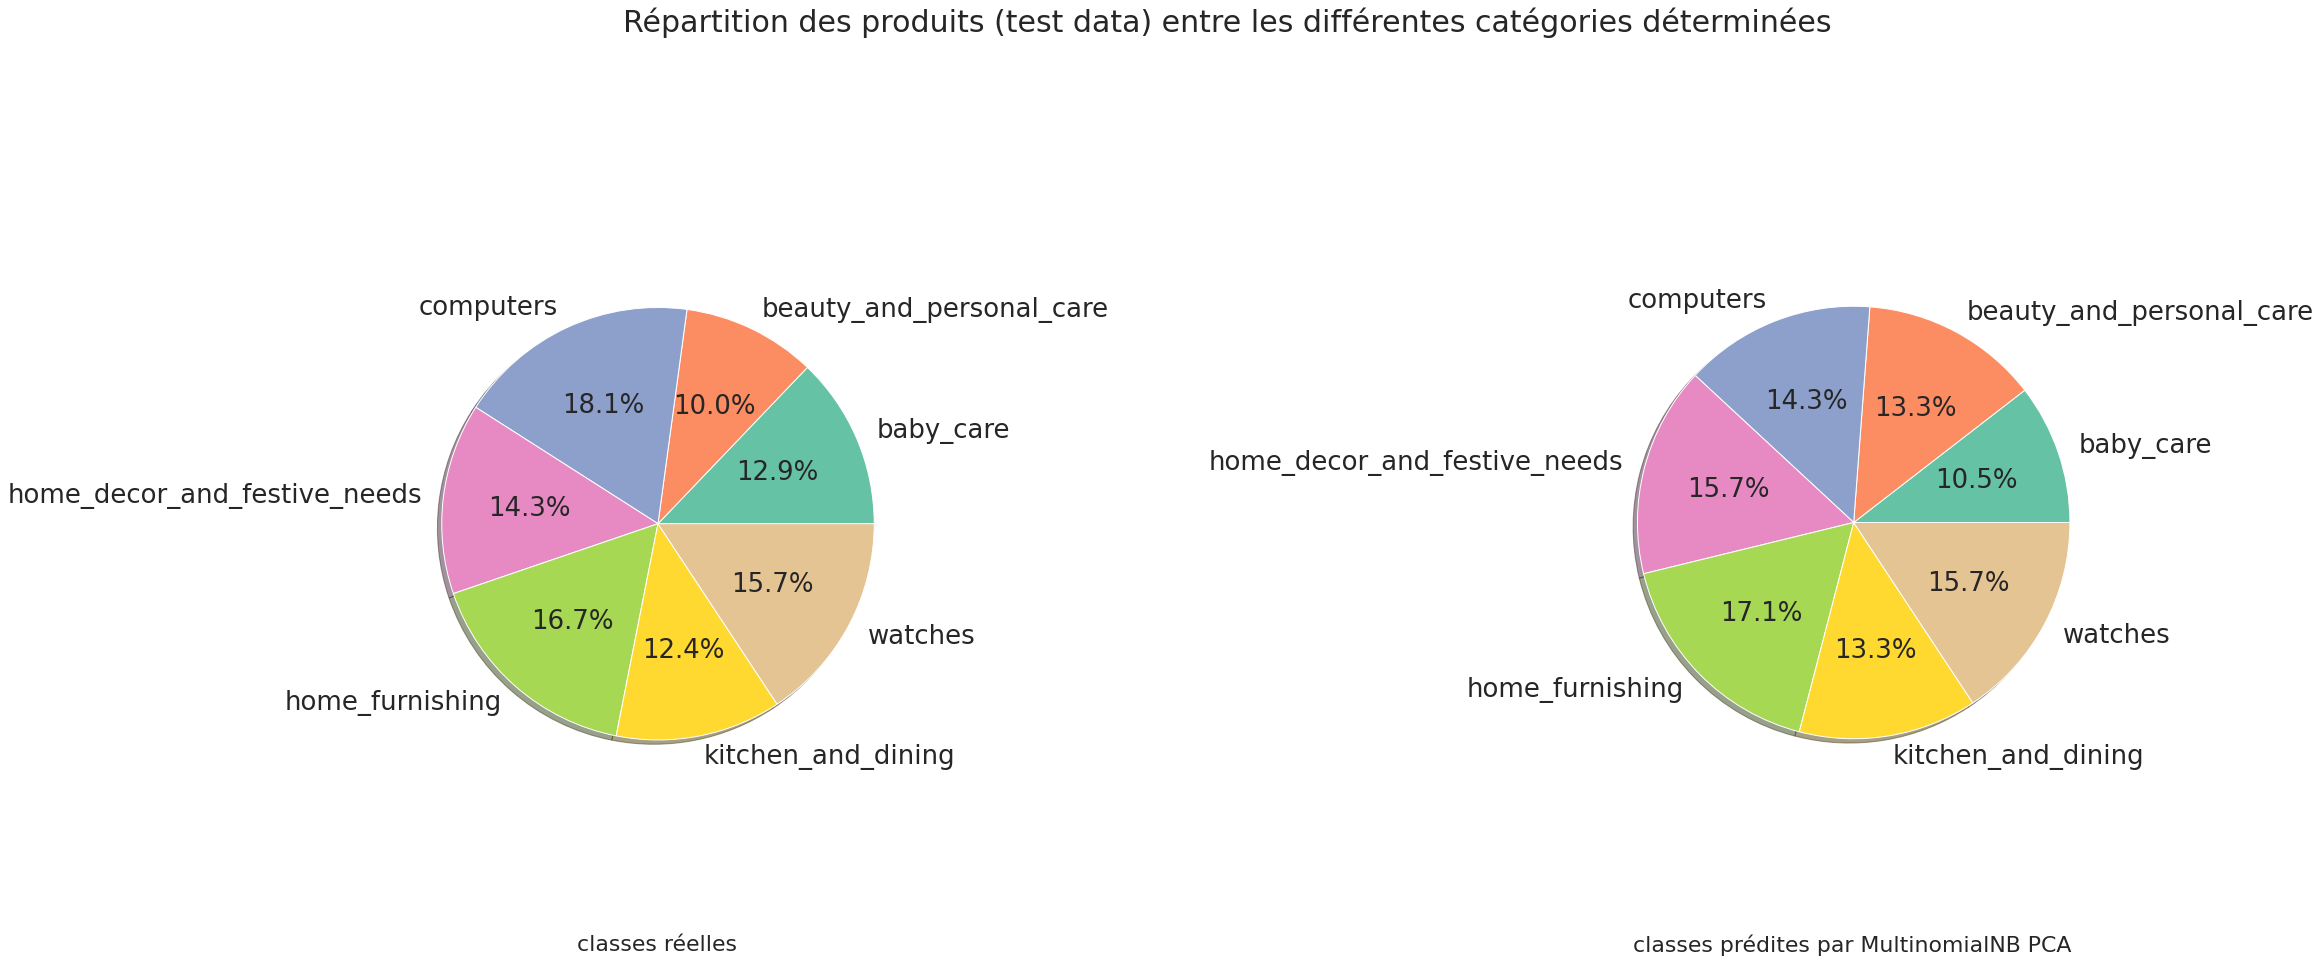

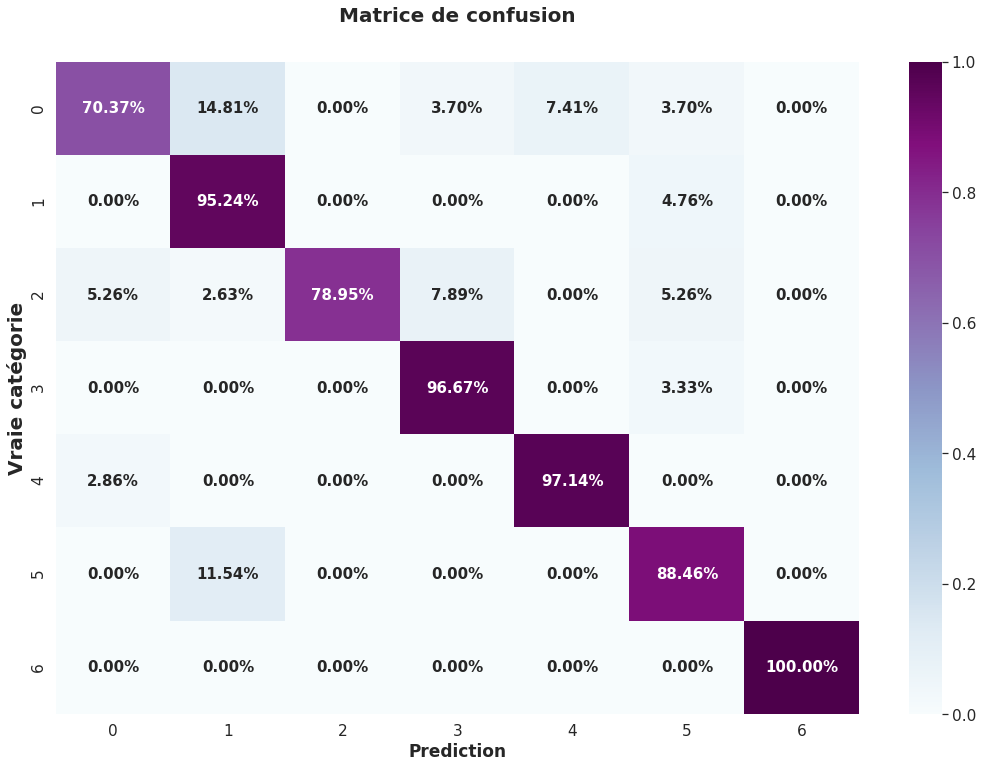

In [ ]:
accuracy, precision, recall, f1, resume_class = classification(
    best_param, X_pca_train, y_train, X_pca_test, y_test, 'MultinomialNB PCA')

Ici le score d'accuracy est de 0.89 ce qui montre que la classification fonctionne bien avec une grande précision.

Ici le score de précision est de 0.90 montre que la prédiction est assez précise car le score est proche de 1.

Ici le score de recall est de 0.89 montre que la prédiction fait en majorité des vrais positifs car le score est proche de 1.

Les labels des catégories prédites correspondent aux labels des catégories réelles pour les donnéees test. Avec ce graphique, on peut voir que les catégories prédites sont proches de la classification manuelle. On peut voir aussi que pour les categories 0 et 2, la classification regroupe moins de produits dans ces catégorie par rapport à la réalité. La conclusion inverse peut être faîte pour les catégories 1, 3, 4 et 5. L'algorithme de prédiction associe à la catégorie 6 le même nombre de produit.



L'algorithme fait des erreurs lors de la classification des catégories 0 et 2. 

In [ ]:
classification_resume_PCA = classification_resume_PCA.append(
    pd.DataFrame(
        {
            "Algorithme": "MultinomialNB",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        },
        index=[2],
    )
)

In [ ]:
classification_resume_PCA

Algorithme  accuracy  precision    recall  f1_score
0            knn  0.861905   0.863177  0.861905  0.861288
1  Random Forest  0.909524   0.910222  0.909524  0.908815
2  MultinomialNB  0.895238   0.905212  0.895238  0.894759

# <font color='green'>Conclusion de cette partie</font>

Le clustering trouve bien des clusters pour séparer les données, il peut également être intéressant de voir l'effet d'une classification.

Les algorithmes les mieux adaptés à nos données pour une classification est l'algorithmes du random forest avec une PCA ainsi que l'algorithme Multinomial NB (qui est mieux adapté à des données transfomées par CountVectorizer ou tfidf) avec une précision de 90% dans la prédiction des catégories pour chaque produit (très bonne exactitude dans la classification et très grande capacité à ne pas donner la mauvaise catégorie avec 80% des catégories prédites exactes par rapport au catégories déterminées manuellement). 

Pour le Clustering, il s'agit de l'algorithme du k-means qui nous donne les meilleurs résultats pour nos données avec 25% de similarité (donné par ARI) entre les catégories prédites et celles déterminées manuellement.

# <font color='pink'>Annexe : Classification sans réduction de dimension</font>

### <font color='olive'>Préparation</font>

fichier avec les descriptions nettoyées

In [ ]:
text_data.head()

image         category  label_category  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  home_furnishing               4   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        baby_care               0   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        baby_care               0   
3  d4684dcdc759dd9cdf41504698d737d8.jpg  home_furnishing               4   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  home_furnishing               4   

                        description_untokenize_clean  
0  feature elegance polyester multicolor abstract...  
1  specification sathiyas cotton bath towel bath ...  
2  feature eurospa cotton terry face towel size s...  
3  feature santosh royal fashion cotton printed k...  
4  feature jaipur print cotton floral king sized ...

#### <font color='grey'>Séparation en train/test test</font>

In [ ]:
X = text_data.copy()
y = X['category']
X = X.drop(['category'], axis=1)
X = X[X.columns]
# Split en training/testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2  # 20% des données dans le jeu de test = 20% de short data
                                                    , random_state=42)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(840, 3) (210, 3) (840,) (210,)


In [ ]:
tfidfvectorizer = TfidfVectorizer(encoding='utf-8',
                                  strip_accents=None,
                                  lowercase=True,
                                  preprocessor=None,
                                  tokenizer=None,
                                  analyzer='word',
                                  stop_words=all_stopwords,
                                  max_df=0.95,
                                  min_df=0.01)

#### <font color='grey'>tfidf train set</font>

In [ ]:
X_train.head()

image  label_category  \
554   b144a363c107c7bdd91f32d6e28ba6f2.jpg               6   
1012  29def171d7e31d48571a52f0fb3e6b07.jpg               3   
481   9f9bb0ef3bb8af571bcfbfa1a22150bd.jpg               2   
432   7f2f1f3039d1f5bc23226fc36577eab9.jpg               2   
626   73901494efea71869576898c68b5eee4.jpg               4   

                           description_untokenize_clean  
554   timewel analog watch timewel analog watch onli...  
1012  ceramic inside fitting hookah mouth black pric...  
481   lapguard pavilion series cell laptop battery f...  
432   feature smartpro replacement charger vaio seri...  
626   feature ville style polyester maroon floral ey...

In [ ]:
# convert the dataframe's column into a matrix
X_train_tfidf = tfidfvectorizer.fit_transform(
    X_train['description_untokenize_clean'])

In [ ]:
X_train_tokens = tfidfvectorizer.get_feature_names()
len(X_train_tokens)

435

In [ ]:
df_tfidf_Xtrain = pd.DataFrame(data=X_train_tfidf.toarray(),
                               index=X_train.index,
                               columns=X_train_tokens)

In [ ]:
print("\nTD-IDF Vectorizer train test\n")
df_tfidf_Xtrain


TD-IDF Vectorizer train test



abstract  accessory   actual   adapter  additional  adorable  \
554        0.0   0.000000  0.00000  0.000000    0.000000       0.0   
1012       0.0   0.000000  0.00000  0.000000    0.000000       0.0   
481        0.0   0.000000  0.00000  0.000000    0.000000       0.0   
432        0.0   0.042656  0.04316  0.619666    0.000000       0.0   
626        0.0   0.000000  0.00000  0.000000    0.051256       0.0   
...        ...        ...      ...       ...         ...       ...   
330        0.0   0.000000  0.00000  0.000000    0.000000       0.0   
466        0.0   0.000000  0.00000  0.000000    0.102668       0.0   
121        0.0   0.000000  0.00000  0.000000    0.000000       0.0   
1044       0.0   0.000000  0.00000  0.000000    0.000000       0.0   
860        0.0   0.000000  0.00000  0.000000    0.000000       0.0   

      affordable    analog  apply  area  aroma  around   assured  attractive  \
554          0.0  0.545941    0.0   0.0    0.0     0.0  0.000000         0.0   
1012         0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
481          0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
432          0.0  0.000000    0.0   0.0    0.0     0.0  0.045522         0.0   
626          0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
...          ...       ...    ...   ...    ...     ...       ...         ...   
330          0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
466          0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
121          0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
1044         0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   
860          0.0  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0   

         audio  authentication  available      baby     back  base  bath  \
554   0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   
1012  0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   
481   0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   
432   0.046993        0.046227        0.0  0.000000  0.03787   0.0   0.0   
626   0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   
...        ...             ...        ...       ...      ...   ...   ...   
330   0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   
466   0.000000        0.000000        0.0  0.292953  0.00000   0.0   0.0   
121   0.000000        0.000000        0.0  0.365204  0.00000   0.0   0.0   
1044  0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   
860   0.000000        0.000000        0.0  0.000000  0.00000   0.0   0.0   

       battery  beautiful  beautifully  bedroom  ...   voltage  wall  \
554   0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   
1012  0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   
481   0.320023   0.000000          0.0      0.0  ...  0.000000   0.0   
432   0.035625   0.000000          0.0      0.0  ...  0.136566   0.0   
626   0.000000   0.064212          0.0      0.0  ...  0.000000   0.0   
...        ...        ...          ...      ...  ...       ...   ...   
330   0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   
466   0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   
121   0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   
1044  0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   
860   0.000000   0.000000          0.0      0.0  ...  0.000000   0.0   

      wardrobe      warm  warranty      wash  washable    watch     water  \
554        0.0  0.000000  0.000000  0.000000       0.0  0.52066  0.000000   
1012       0.0  0.000000  0.000000  0.000000       0.0  0.00000  0.000000   
481        0.0  0.000000  0.000000  0.000000       0.0  0.00000  0.000000   
432        0.0  0.000000  0.307845  0.000000       0.0  0.00000  0.000000   
626        0.0  0.074919  0.000000  0.102

#### <font color='grey'>tfidf test set</font>

In [ ]:
X_test.head()

image  label_category  \
352  833a87b0af3b84fe246d2ebf271af177.jpg               2   
689  55195de3873fffaa9e37b041533d7305.jpg               5   
485  44b963eb856b4831dfdd21b666593c95.jpg               2   
388  98ad5b99ad96695568d8f143b11ab740.jpg               1   
31   29b1ca231e10d5269516b80bf9d0dffc.jpg               6   

                          description_untokenize_clean  
352  zyxel flipkart genuine product replacement gua...  
689  philip bulb online philip bulb best price free...  
485  lapguard lenovo ideapad cell laptop battery pr...  
388  flipkart anna andre paris dark fire numero deo...  
31   lenco bdblue tango analog watch boy lenco bdbl...

In [ ]:
# convert the dataframe's column into a matrix
X_test_tfidf = tfidfvectorizer.transform(
    X_test['description_untokenize_clean'])

In [ ]:
# retrieve the terms found in the corpora
# if we take same parameters on both Classes(CountVectorizer and TfidfVectorizer),
# it will give same output of get_feature_names() methods)
X_test_tokens = tfidfvectorizer.get_feature_names()
len(X_test_tokens)

435

In [ ]:
df_tfidf_Xtest = pd.DataFrame(data=X_test_tfidf.toarray(),
                              index=X_test.index,
                              columns=X_test_tokens)

In [ ]:
print("\nTD-IDF Vectorizer\n")
df_tfidf_Xtest


TD-IDF Vectorizer



abstract  accessory    actual  adapter  additional  adorable  affordable  \
352  0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   
689  0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   
485  0.000000        0.0  0.099575      0.0    0.000000       0.0    0.000000   
388  0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   
31   0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   
..        ...        ...       ...      ...         ...       ...         ...   
694  0.119227        0.0  0.000000      0.0    0.000000       0.0    0.154708   
539  0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   
449  0.000000        0.0  0.000000      0.0    0.091757       0.0    0.000000   
622  0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   
209  0.000000        0.0  0.000000      0.0    0.000000       0.0    0.000000   

       analog  apply  area  aroma  around   assured  attractive  audio  \
352  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
689  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
485  0.000000    0.0   0.0    0.0     0.0  0.105024         0.0    0.0   
388  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
31   0.330851    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
..        ...    ...   ...    ...     ...       ...         ...    ...   
694  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
539  0.277420    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
449  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
622  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   
209  0.000000    0.0   0.0    0.0     0.0  0.000000         0.0    0.0   

     authentication  available      baby      back  base  bath   battery  \
352        0.000000        0.0  0.000000  0.000000   0.0   0.0  0.000000   
689        0.000000        0.0  0.000000  0.000000   0.0   0.0  0.000000   
485        0.106651        0.0  0.000000  0.000000   0.0   0.0  0.616434   
388        0.000000        0.0  0.000000  0.000000   0.0   0.0  0.000000   
31         0.000000        0.0  0.000000  0.000000   0.0   0.0  0.000000   
..              ...        ...       ...       ...   ...   ...       ...   
694        0.000000        0.0  0.000000  0.000000   0.0   0.0  0.000000   
539        0.000000        0.0  0.000000  0.193041   0.0   0.0  0.000000   
449        0.000000        0.0  0.349092  0.000000   0.0   0.0  0.000000   
622        0.000000        0.0  0.312674  0.000000   0.0   0.0  0.000000   
209        0.000000        0.0  0.000000  0.000000   0.0   0.0  0.000000   

     beautiful  beautifully  bedroom  ...   voltage  wall  wardrobe  warm  \
352   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
689   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
485   0.000000          0.0      0.0  ...  0.105024   0.0       0.0   0.0   
388   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
31    0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
..         ...          ...      ...  ...       ...   ...       ...   ...   
694   0.257409          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
539   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
449   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
622   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   
209   0.000000          0.0      0.0  ...  0.000000   0.0       0.0   0.0   

     warranty      wash  washable     watch     water      wear  wedding  \
352       0.0  0.000000       0.0  0.000000  0.000000  0.000000      0.0   
689       0.0  0.000000       0.0  0.000000  0.000000  0.000000      0.0   
485       0.0  0.000000       0.0  0.000000  0.000000  0.000000      0.0   
3

### <font color='olive'>Knn classifier</font>

#### <font color='grey'>Exécution</font>

In [ ]:
# GridSearch
# create new a knn model
knn2 = KNeighborsClassifier()

# create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
score = 'accuracy'

# use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

# Fit sur le training set.
knn_gscv.fit(df_tfidf_Xtrain, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
best_param = knn_gscv.best_estimator_
print("Best paramètres: {}".format(best_param))

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
    knn_gscv.cv_results_['mean_test_score'],  # score moyen
    knn_gscv.cv_results_['std_test_score'],  # écart-type du score
    knn_gscv.cv_results_['params']           # valeur de l'hyperparamètre
):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ))

Best paramètres: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                     weights='uniform')
Résultats de la validation croisée :
accuracy = 0.855 (+/-0.035) for {'n_neighbors': 1}
accuracy = 0.844 (+/-0.017) for {'n_neighbors': 2}
accuracy = 0.867 (+/-0.021) for {'n_neighbors': 3}
accuracy = 0.869 (+/-0.023) for {'n_neighbors': 4}
accuracy = 0.864 (+/-0.046) for {'n_neighbors': 5}
accuracy = 0.868 (+/-0.040) for {'n_neighbors': 6}
accuracy = 0.868 (+/-0.040) for {'n_neighbors': 7}
accuracy = 0.854 (+/-0.051) for {'n_neighbors': 8}
accuracy = 0.861 (+/-0.043) for {'n_neighbors': 9}
accuracy = 0.861 (+/-0.050) for {'n_neighbors': 10}
accuracy = 0.871 (+/-0.037) for {'n_neighbors': 11}
accuracy = 0.873 (+/-0.054) for {'n_neighbors': 12}
accuracy = 0.869 (+/-0.048) for {'n_neighbors': 13}
accuracy = 0.865 (+/-0.049) for {'n_neighbors': 14}
accuracy = 0.865 (+/-0.048) for {'n_nei

In [ ]:
#best_param = KNeighborsClassifier(n_neighbors = 12)
# best_param.fit(X_train,y_train)
#prediction = best_param.predict(X_test)

# Fit the classifier to the data
best_param.fit(df_tfidf_Xtrain, y_train)
prediction = best_param.predict(df_tfidf_Xtest)

In [ ]:
knn_class = pd.DataFrame(
    {'cat_reel': y_test, 'cat_predit': prediction}).reset_index()

In [ ]:
knn_class.head()

index                  cat_reel                cat_predit
0    352                 computers                 computers
1    689        kitchen_and_dining        kitchen_and_dining
2    485                 computers                 computers
3    388  beauty_and_personal_care  beauty_and_personal_care
4     31                   watches                   watches

In [ ]:
knn_class["cat_predit"].nunique()

7

#### <font color='grey'>Qualité de la classification</font>

In [ ]:
# Accuracy score : check accuracy of our model on the test data knn.score(X_test, y_test)
accuracy_knn = accuracy_score(y_test, prediction)
print('L\'accuracy score est de {} pour la méthode knn'.format(accuracy_knn))

L'accuracy score est de 0.8809523809523809 pour la méthode knn


In [ ]:
precision_knn = precision_score(y_test, prediction, average='weighted')
print('Le score de précision est de {} pour la méthode knn'.format(precision_knn))

Le score de précision est de 0.8850566893424036 pour la méthode knn


In [ ]:
recall_knn = recall_score(y_test, prediction, average='weighted')
print('Le score recall est de {} pour la méthode Knn'.format(recall_knn))

Le score recall est de 0.8809523809523809 pour la méthode Knn


In [ ]:
f1_knn = f1_score(y_test, prediction, average='weighted')
print('Le score f1 est de {} pour la méthode Knn'.format(f1_knn))

Le score f1 est de 0.8812965469123105 pour la méthode Knn


#### <font color='grey'>Visualisations</font>

In [ ]:
le = preprocessing.LabelEncoder()
knn_class['label_cat_reel'] = le.fit_transform(
    np.array(knn_class['cat_reel']))
knn_class['label_cat_predit'] = le.transform(
    np.array(knn_class['cat_predit']))
knn_class

index                      cat_reel                    cat_predit  \
0      352                     computers                     computers   
1      689            kitchen_and_dining            kitchen_and_dining   
2      485                     computers                     computers   
3      388      beauty_and_personal_care      beauty_and_personal_care   
4       31                       watches                       watches   
..     ...                           ...                           ...   
205    694  home_decor_and_festive_needs  home_decor_and_festive_needs   
206    539                       watches                       watches   
207    449                     baby_care                     baby_care   
208    622                     baby_care                     baby_care   
209    209  home_decor_and_festive_needs  home_decor_and_festive_needs   

     label_cat_reel  label_cat_predit  
0                 2                 2  
1                 5                 5  
2                 2                 2  
3                 1                 1  
4                 6                 6  
..              ...               ...  
205               3                 3  
206               6                 6  
207               0                 0  
208               0                 0  
209               3                 3  

[210 rows x 5 columns]

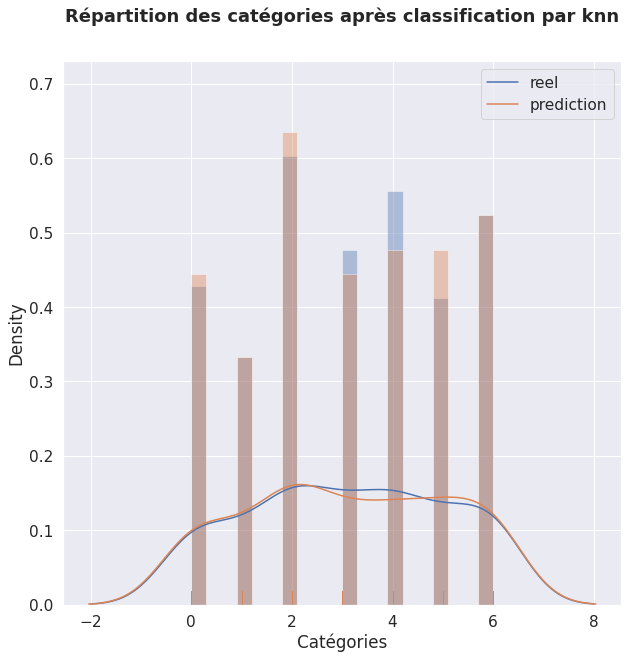

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Répartition des catégories après classification par knn',
          fontsize=18, fontweight="bold")
sns.distplot(knn_class['label_cat_reel'], bins=20, rug=True)
sns.distplot(knn_class['label_cat_predit'], bins=20, rug=True)
plt.xlabel("Catégories")
plt.legend(['reel', 'prediction'])

Les labels des categories prédites correspondent aux labels des catégories réelles pour les donnéees test. Avec ce graphique, on peut voir que les catégories prédites sont proches de la classification manuelle. On peut voir aussi que pour les catégories 3 et 4 (home_decor_&_festive_needs, home_furnishing), la classification par knn regroupe moins de produits dans ces catégories par rapport à la réalité. La conclusion inverse peut être faîte pour les catégories 0, 2 et 5 (baby_care, computers, kitchen_and_dining). Pour les catégories 1 et 6 (beauty_and_personal_care, watches) la classification par knn regroupe autant de produits dans ces catégories par rapport à la réalité. 

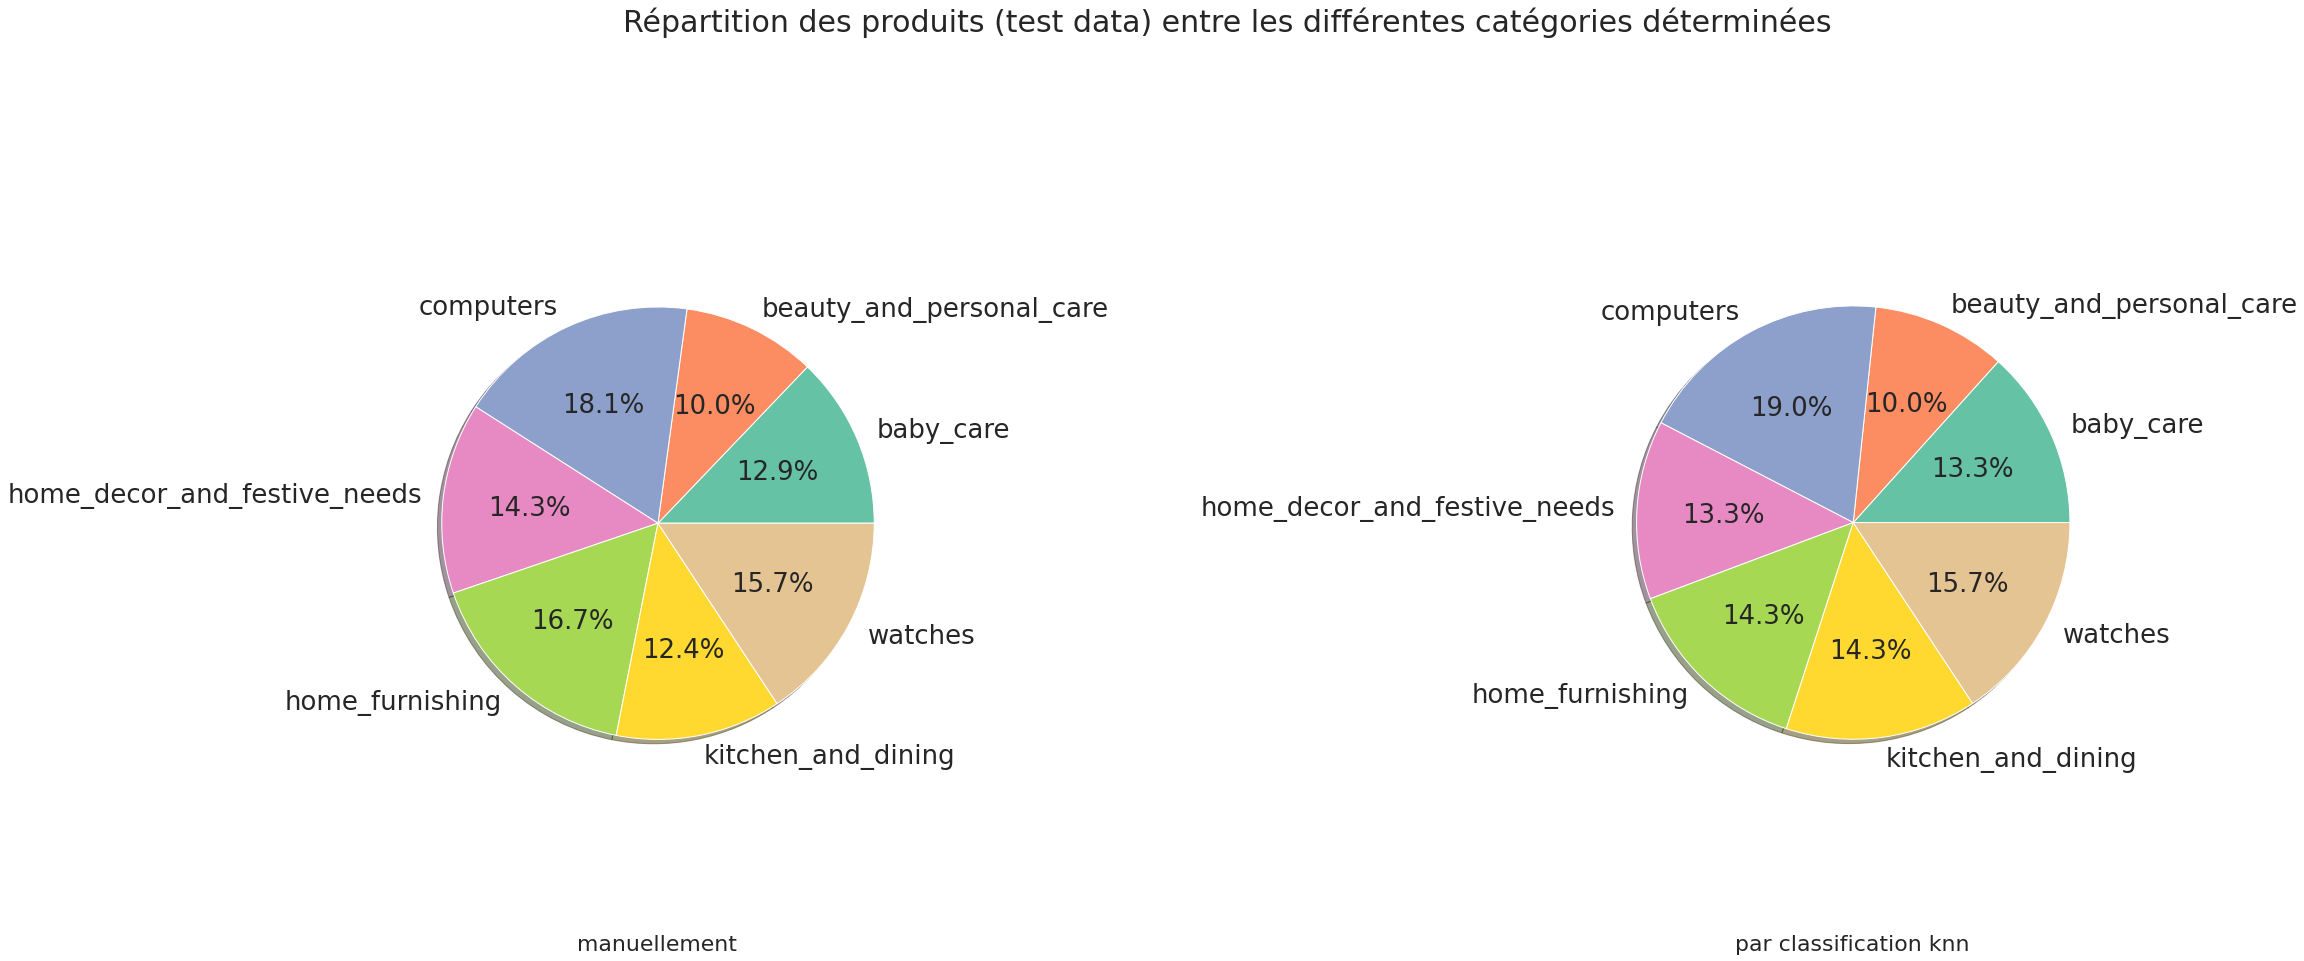

In [ ]:
fig = plt.figure(figsize=(30, 15))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

nb_label_real = knn_class['cat_reel'].nunique()
cs_nb_label_real = cm.Set2(np.arange(nb_label_real))
nb_label_predit = knn_class['cat_predit'].nunique()
cs_nb_label_predit = cm.Set2(np.arange(nb_label_predit))

ax1 = knn_class.groupby('cat_reel').count().plot(kind='pie',
                                                 y='label_cat_reel',
                                                 ax=ax1,
                                                 legend=False,
                                                 shadow=True,
                                                 startangle=0,
                                                 autopct='%1.1f%%',
                                                 textprops={'fontsize': 26},
                                                 colors = cs_nb_label_real)
ax1.axis('equal')
ax1.set_xlabel("manuellement", fontsize=22)
ax1.set_ylabel(" ")


ax2 = knn_class.groupby('cat_predit').count().plot(kind='pie',
                                                   y='label_cat_predit',
                                                   ax=ax2,
                                                   legend=False,
                                                   shadow=True,
                                                   startangle=0,
                                                   autopct='%1.1f%%',
                                                   textprops={'fontsize': 26},
                                                   colors = cs_nb_label_predit)
ax2.axis('equal')
ax2.set_xlabel("par classification knn", fontsize=22)
ax2.set_ylabel(" ")

plt.suptitle('Répartition des produits (test data) entre les différentes catégories déterminées',
             fontsize=30)

plt.subplots_adjust(wspace=1.5)

plt.show()

Une matrice de confusion permet de mesurer la qualité de notre système de classification et de voir facilement les mauvaises répartitions entre les catégories.

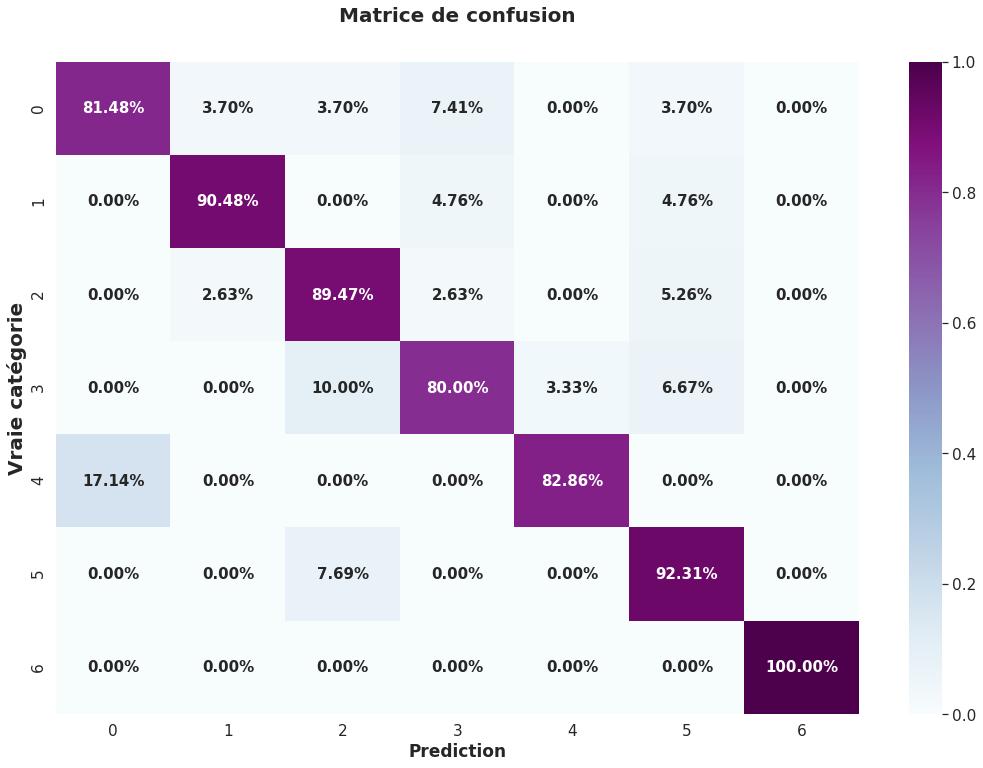

In [ ]:
cf_matrix = confusion_matrix(
    knn_class["cat_reel"], knn_class["cat_predit"], normalize='true')
plt.figure(figsize=(18, 12))
plt.title('Matrice de confusion', size=20, weight='bold')
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cf_matrix, annot=True,  # cf_matrix/np.sum(cf_matrix)=normalize=all
            fmt='.2%', cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'})
plt.ylabel("Vraie catégorie", weight='bold', size=20)
plt.xlabel('Prediction', weight='bold', size=17)
plt.show()

L'algorithme se trompe surtout sur la prédiction des catégories 0, 3 et 4.

In [ ]:
classification_resume = pd.DataFrame({})

classification_resume = classification_resume.append(
    pd.DataFrame(
        {
            "Algorithme": "knn",
            "accuracy": accuracy_knn,
            "precision": precision_knn,
            "recall": recall_knn,
            "f1_score": f1_knn
        },
        index=[0],
    )
)

In [ ]:
classification_resume

Algorithme  accuracy  precision    recall  f1_score
0        knn  0.880952   0.885057  0.880952  0.881297

### <font color='olive'>Random Forest</font>

In [ ]:
# GridSearch
param_grid = [{'max_depth': range(2, 10, 2)}]
gridSearch = GridSearchCV(RandomForestClassifier(),
                          param_grid, cv=5, scoring='accuracy')
score = 'accuracy'


# Fit sur le training set.
gridSearch.fit(df_tfidf_Xtrain, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
best_param = gridSearch.best_estimator_
print("Best paramètres: {}".format(best_param))

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
    gridSearch.cv_results_['mean_test_score'],  # score moyen
    gridSearch.cv_results_['std_test_score'],  # écart-type du score
    gridSearch.cv_results_['params']           # valeur de l'hyperparamètre
):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ))

Best paramètres: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Résultats de la validation croisée :
accuracy = 0.708 (+/-0.052) for {'max_depth': 2}
accuracy = 0.785 (+/-0.061) for {'max_depth': 4}
accuracy = 0.819 (+/-0.052) for {'max_depth': 6}
accuracy = 0.844 (+/-0.036) for {'max_depth': 8}


Exécution 
 
Qualité de la classification 
 
 
L'accuracy score est de 0.861904761904762 pour la méthode Random Forest.
 
 
Le score de précision est de 0.8893750345666722 pour la méthode Random Forest.
 
 
Le score recall est de 0.861904761904762 pour la méthode Random Forest.
 
 
Le score f1 est de 0.8602202176890708 pour la méthode Random Forest.
 
 
Visualisation 
 
 


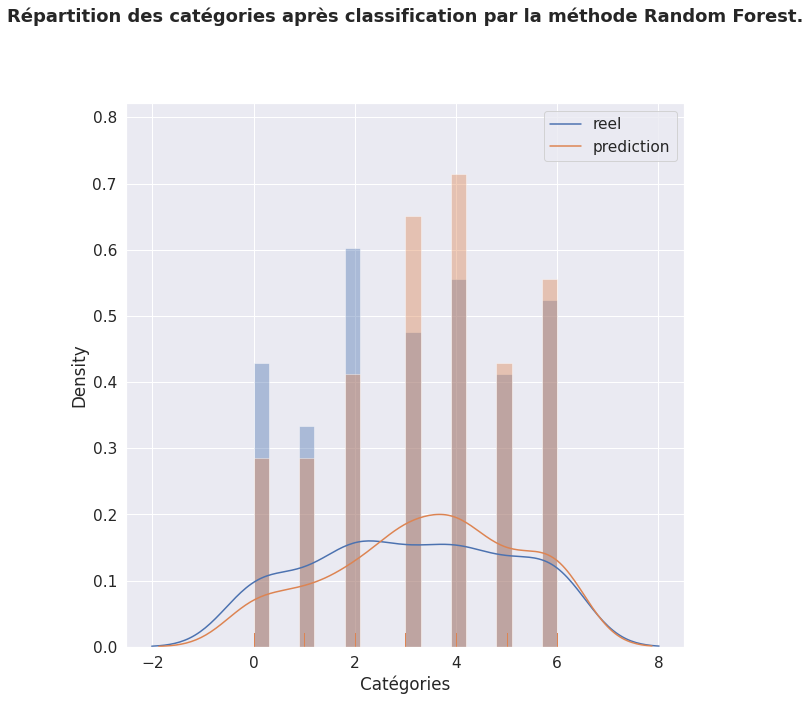

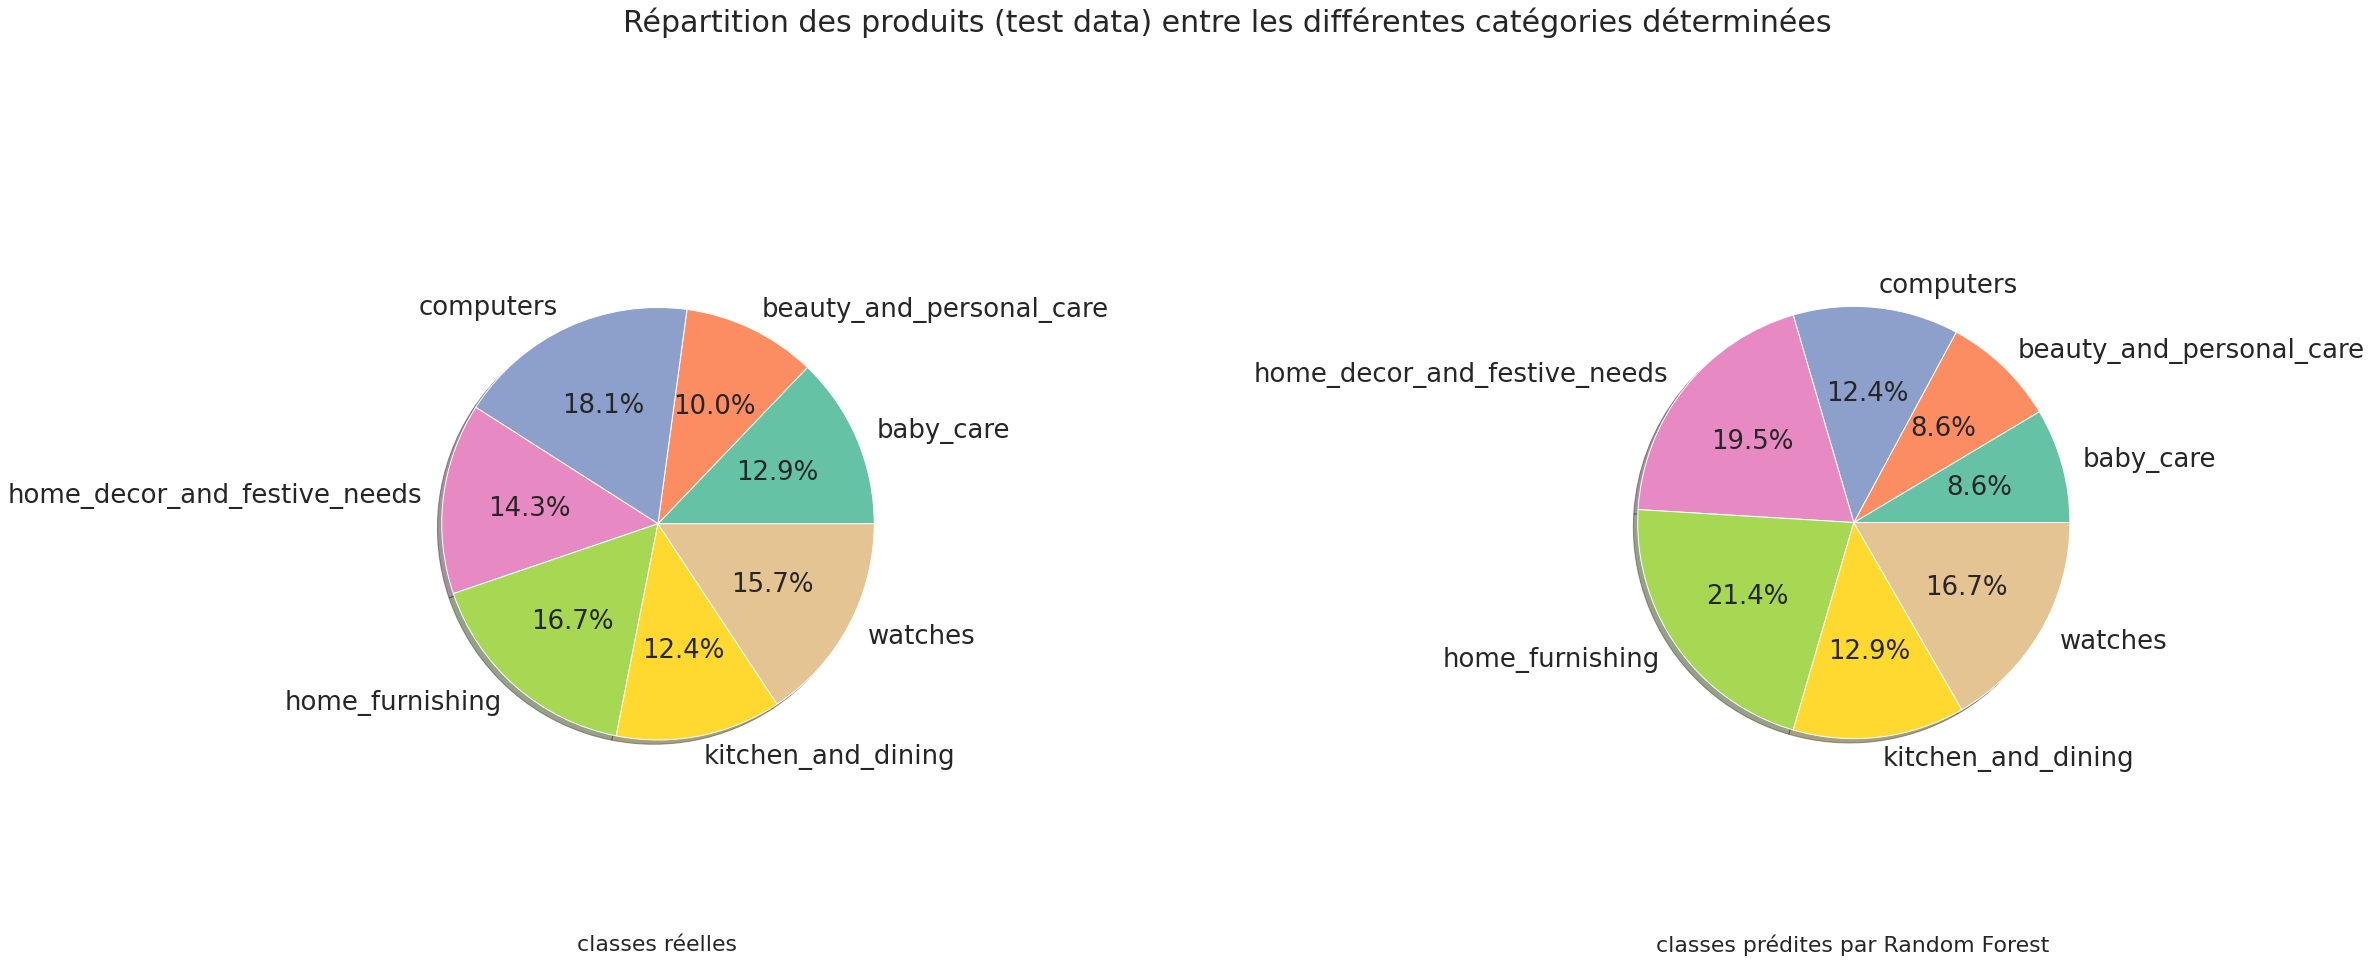

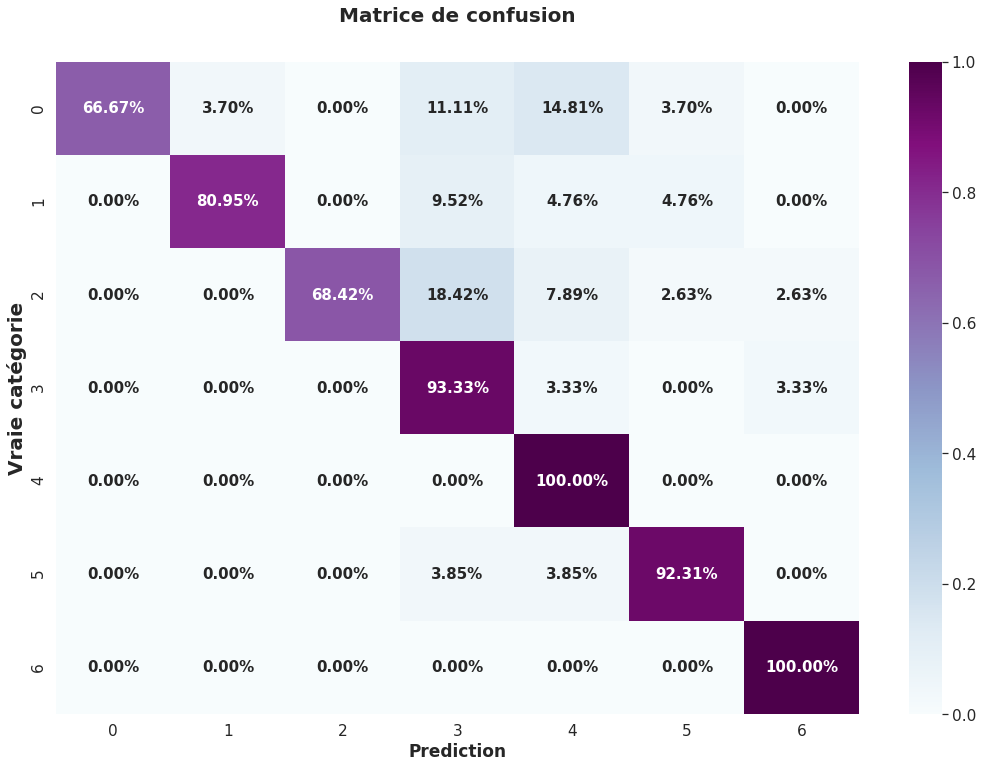

In [ ]:
accuracy, precision, recall, f1, resume_class = classification(
    best_param, df_tfidf_Xtrain, y_train, df_tfidf_Xtest, y_test, 'Random Forest')

Ici le score d'accuracy est de 0.83 ce qui montre que la classification fonctionne bien avec une très grande précision.

Ici le score de précision est de 0.85 montre que la prédiction est assez précise car le score est proche de 1.

Ici le score de recall est de 0.83 montre que la prédiction fait en majorité des vrais positifs car le score est proche de 1.

Les labels des catégories prédites correspondent aux labels des catégories réelles pour les donnéees test. Avec ce graphique, on peut voir que les catégories prédites sont proches de la classification manuelle. On peut voir aussi que pour les catégories 0, 2, 3 et 5, la classification regroupe moins de produits dans ces catégories par rapport à la réalité. La conclusion inverse peut être faîte pour les catégories 4 et 6. La classification refroupe autant de produits qu'en réalité pour la catégorie 1.

Une matrice de confusion permet de mesurer la qualité de notre système de classification et de voir facilement les mauvaises répartitions entre catégories.

L'algorithme se trompe surtout sur la classification des catégories 0, 2 et 3.

In [ ]:
classification_resume = classification_resume.append(
    pd.DataFrame(
        {
            "Algorithme": "Random Forest",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        },
        index=[1],
    )
)

In [ ]:
classification_resume

Algorithme  accuracy  precision    recall  f1_score
0            knn  0.880952   0.885057  0.880952  0.881297
1  Random Forest  0.861905   0.889375  0.861905  0.860220

### <font color='olive'>naive_bayes.MultinomialNB</font>

In [ ]:
# GridSearch
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10.0]
              }

gridSearch = GridSearchCV(MultinomialNB(), param_grid,
                          cv=5, scoring='accuracy')
score = 'accuracy'


# Fit sur le training set.
gridSearch.fit(df_tfidf_Xtrain, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
best_param = gridSearch.best_estimator_
print("Best paramètres: {}".format(best_param))

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
    gridSearch.cv_results_['mean_test_score'],  # score moyen
    gridSearch.cv_results_['std_test_score'],  # écart-type du score
    gridSearch.cv_results_['params']           # valeur de l'hyperparamètre
):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ))

Best paramètres: MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
Résultats de la validation croisée :
accuracy = 0.845 (+/-0.049) for {'alpha': 0.0001}
accuracy = 0.848 (+/-0.047) for {'alpha': 0.001}
accuracy = 0.849 (+/-0.040) for {'alpha': 0.01}
accuracy = 0.852 (+/-0.028) for {'alpha': 0.1}
accuracy = 0.850 (+/-0.024) for {'alpha': 0.5}
accuracy = 0.845 (+/-0.020) for {'alpha': 1.0}
accuracy = 0.808 (+/-0.068) for {'alpha': 10.0}


alpha représente le paramètre de lissage.

Exécution 
 
Qualité de la classification 
 
 
L'accuracy score est de 0.8761904761904762 pour la méthode MultinomialNB.
 
 
Le score de précision est de 0.8988747657813742 pour la méthode MultinomialNB.
 
 
Le score recall est de 0.8761904761904762 pour la méthode MultinomialNB.
 
 
Le score f1 est de 0.879101533605851 pour la méthode MultinomialNB.
 
 
Visualisation 
 
 


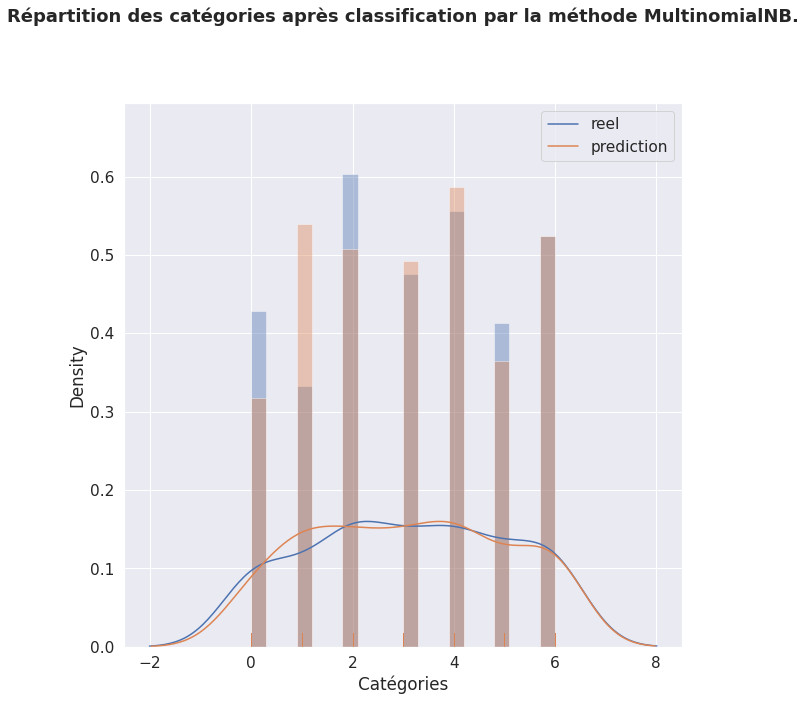

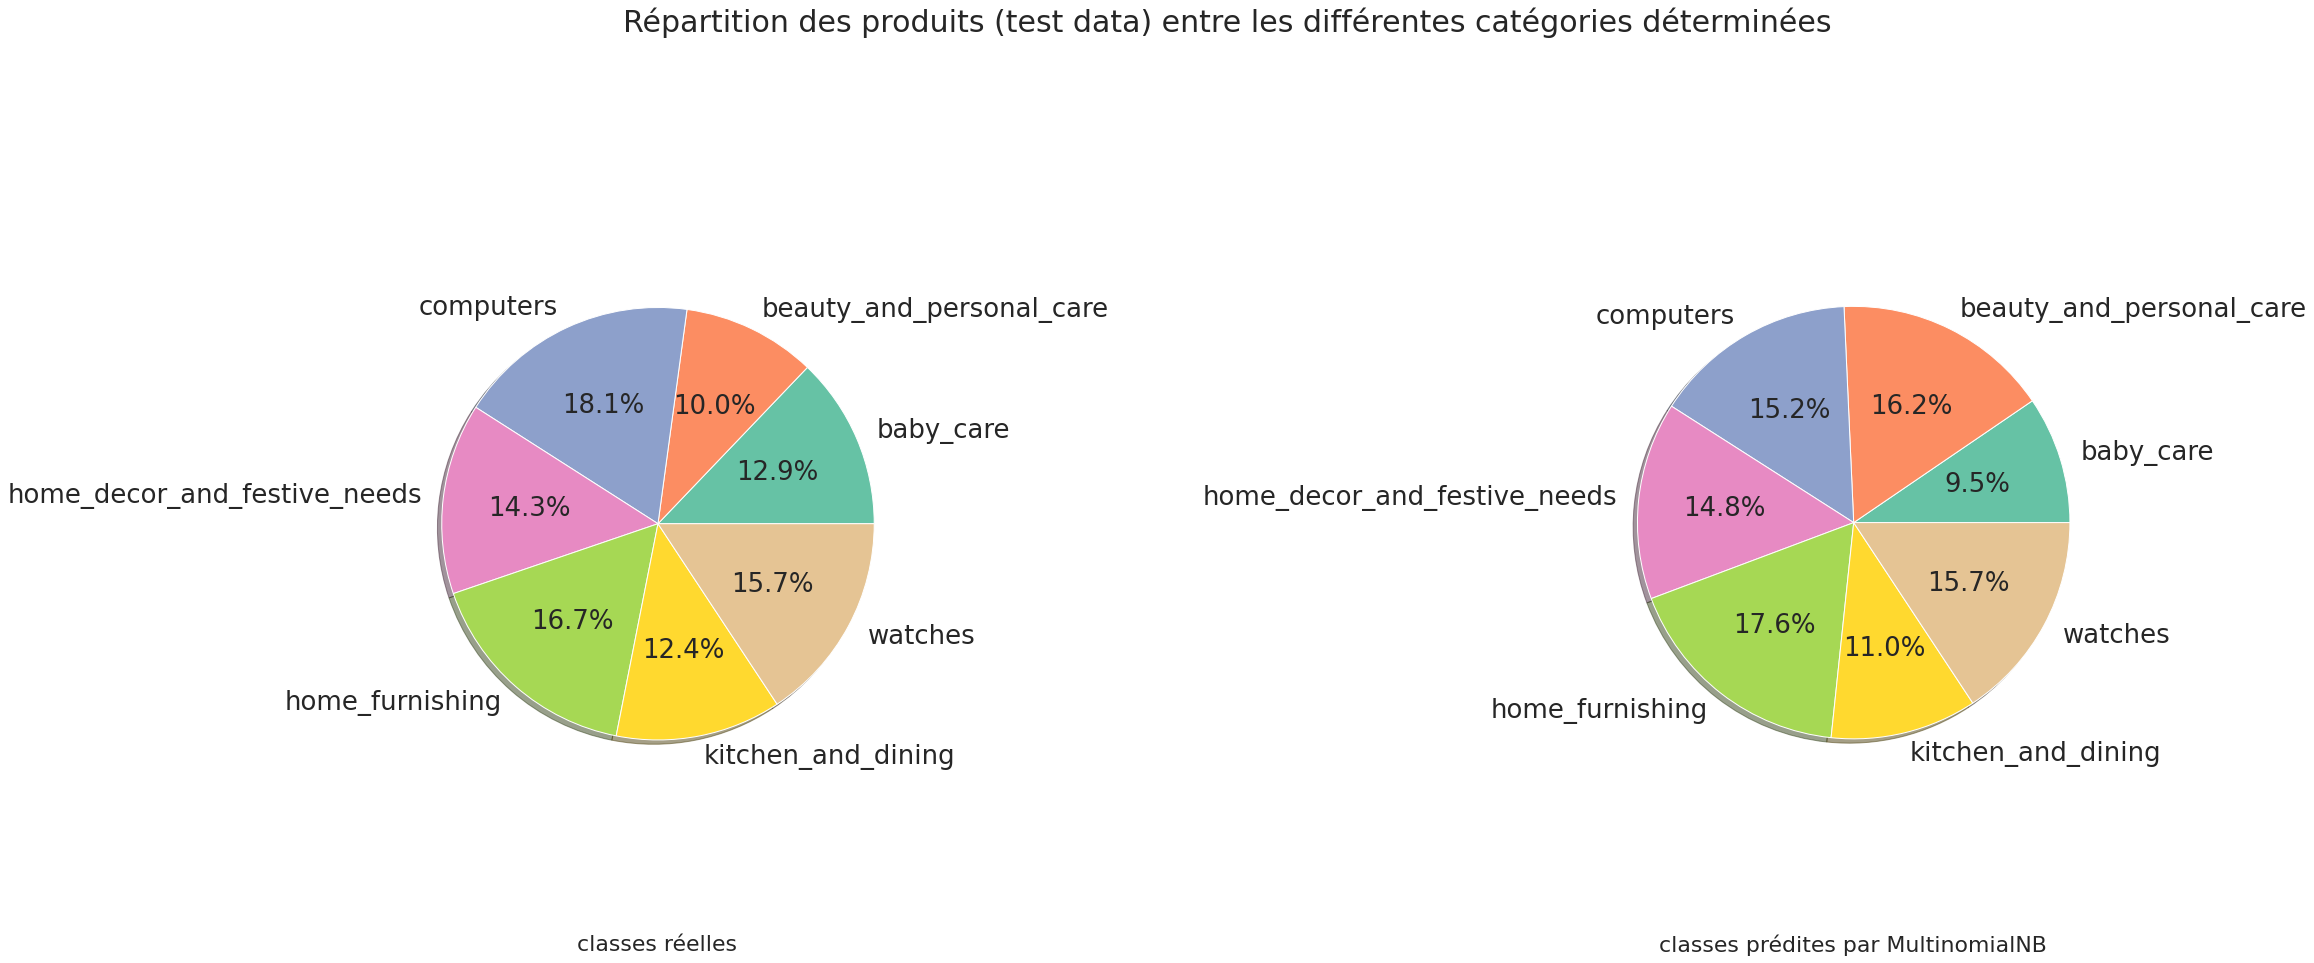

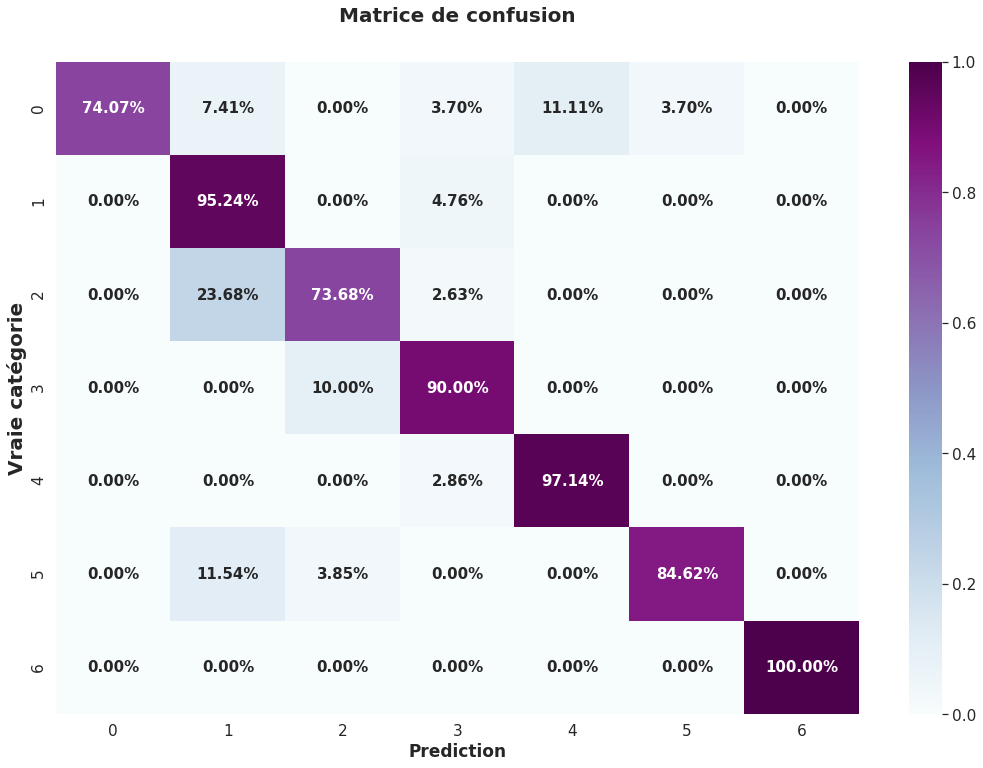

In [ ]:
accuracy, precision, recall, f1, resume_class = classification(
    best_param, df_tfidf_Xtrain, y_train, df_tfidf_Xtest, y_test, 'MultinomialNB')

Ici le score d'accuracy est de 0.87 ce qui montre que la classification fonctionne bien avec une précision très grande.

Ici le score de précision est de 0.89 montre que la prédiction est assez précise car le score est proche de 1.

Ici le score de f1 est de 0.87 montre que la prédiction fait en majorité des vrais positifs car le score est proche de 1.

Les labels des catégories prédites correspondent aux labels des catégories réelles pour les donnéees test. Avec ce graphique, on peut voir que les catégories prédites sont proches de la classification manuelle. On peut voir aussi que pour les categories 0, 2 et 5, la classification regroupe moins de produits dans ces catégorie par rapport à la réalité. La conclusion inverse peut être faîte pour les catégories 1, 3 et 4. L'algorithme de prédiction associe à la catégorie 6 le même nombre de produit.

L'algorithme se trompe surtout sur la prédiction des catégories 0 et 2.

In [ ]:
classification_resume = classification_resume.append(
    pd.DataFrame(
        {
            "Algorithme": "MultinomialNB",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        },
        index=[2],
    )
)

In [ ]:
classification_resume

Algorithme  accuracy  precision    recall  f1_score
0            knn  0.880952   0.885057  0.880952  0.881297
1  Random Forest  0.861905   0.889375  0.861905  0.860220
2  MultinomialNB  0.876190   0.898875  0.876190  0.879102